### Исследование демографии группы проекта DonorSearch

**Задача:**
 - Обработать статистику собранную Вконтакте
 - Рассмотреть состав участников в разрезе пола и возраста на всём протяжении времени наблюдений
 - Проследить географию участников группы
 - Сделать анализ активности в группе
 - Проанализировать эффективность рекламных кампаний ВК

In [ ]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import requests
from urllib.parse import urlencode
import json
import plotly.graph_objs as go 

In [2]:
#Загружаем файлы
vk2011 = pd.read_excel('social_networks/vkontakte_group21179173_2011-01-01_2011-12-31.xls')
vk2012 = pd.read_excel('social_networks/vkontakte_group21179173_2012-01-01_2012-12-31.xls')
vk2013 = pd.read_excel('social_networks/vkontakte_group21179173_2013-01-01_2013-12-31.xls')
vk2014 = pd.read_excel('social_networks/vkontakte_group21179173_2014-01-01_2014-12-31.xls')
vk2015 = pd.read_excel('social_networks/vkontakte_group21179173_2015-01-01_2015-12-31.xls')
vk2016 = pd.read_excel('social_networks/vkontakte_group21179173_2016-01-01_2016-12-31.xls')
vk2017 = pd.read_excel('social_networks/vkontakte_group21179173_2017-01-01_2017-12-31.xls')
vk2018 = pd.read_excel('social_networks/vkontakte_group21179173_2018-01-01_2018-12-31.xls')
vk2019 = pd.read_excel('social_networks/vkontakte_group21179173_2019-01-01_2019-12-31.xls')
vk2020 = pd.read_excel('social_networks/vkontakte_group21179173_2020-01-01_2020-12-31.xls')
vk2021 = pd.read_excel('social_networks/vkontakte_group21179173_2021-01-01_2021-12-27.xls')
vk_reach = pd.read_excel('social_networks/vkontakte_group21179173_reach_2016-01-01_2021-12-27.xls')

#Загрузим датасет с населением городов
cities = pd.read_csv('settlements/data.csv')

#Выведем все колонки без сокращений
pd.set_option('display.max_columns', None)

### Загрузим таблицы и посмотрим на данные

In [3]:
vk2011.head()

Дата  Критерий Парам. №1 Парам. №2  Значение
0  31.12.2011     views       NaN       NaN        45
1  31.12.2011  visitors       NaN       NaN        25
2  31.12.2011    gender         Ж       NaN        15
3  31.12.2011    gender         М       NaN         9
4  31.12.2011       age      1-18       NaN         4

In [4]:
cities.head()

id             region           municipality  settlement type  population  \
0   0  Орловская область             Болховский  Колонтаева    д           0   
1   1    Республика Крым                 Алушта     Пушкино    с         273   
2   2   Липецкая область  Лев-Толстовский район    Барятино    с           7   
3   3   Тверская область    Селижаровский район      Хилово    д           2   
4   4    Томская область     Парабельский район   Басмасово    д           6   

   children latitude_dms longitude_dms  latitude_dd  longitude_dd  \
0         0     53.22.07     035.54.36    53.368611     35.910000   
1         0     44.35.45     034.20.27    44.595833     34.340833   
2         1     53.15.46     039.30.14    53.262778     39.503889   
3         0     56.54.20     033.25.09    56.905556     33.419167   
4         0     58.38.12     082.02.40    58.636667     82.044444   

          oktmo  dadata  rosstat  
0  5.460442e+10       0        1  
1  3.570300e+10       0        1  
2  4.263641e+10       0        1  
3  2.865043e+10       0        1  
4  6.964444e+10       0        1

In [5]:
#создание словаря для переименования столбцов
new_columns = { 
    'Дата':'date',
    'Критерий':'criterion',
    'Парам. №1':'param_1',
    'Парам. №2':'param_2',
    'Значение':'value'

}

#применяем метод rename для переименования столбцов
vk2011 = vk2011.rename(columns=new_columns)
vk2012 = vk2012.rename(columns=new_columns)
vk2013 = vk2013.rename(columns=new_columns)
vk2014 = vk2014.rename(columns=new_columns)
vk2015 = vk2015.rename(columns=new_columns)
vk2016 = vk2016.rename(columns=new_columns)
vk2017 = vk2017.rename(columns=new_columns)
vk2018 = vk2018.rename(columns=new_columns)
vk2019 = vk2019.rename(columns=new_columns)
vk2020 = vk2020.rename(columns=new_columns)
vk2021 = vk2021.rename(columns=new_columns)

In [6]:
vk2011

date criterion          param_1 param_2  value
0      31.12.2011     views              NaN     NaN     45
1      31.12.2011  visitors              NaN     NaN     25
2      31.12.2011    gender                Ж     NaN     15
3      31.12.2011    gender                М     NaN      9
4      31.12.2011       age             1-18     NaN      4
...           ...       ...              ...     ...    ...
19250  01.01.2011    cities      Новосибирск     NaN      1
19251  01.01.2011    cities  Нижний Новгород     NaN      1
19252  01.01.2011    cities  Санкт-Петербург     NaN      1
19253  01.01.2011    cities   Ростов-на-Дону     NaN      1
19254  01.01.2011    cities             Азов     NaN      1

[19255 rows x 5 columns]

In [7]:
#Функция выводит информацию по колонке - название, уникальные значения, количество нулей, распределение значений
def column_describe(data, column):
    print('Column:',column)
    print()
    print('Unique elements: ',data[column].unique())
    print()
    print('Zeroes count:',data[data[column] ==0][column].count())
    display(data[data[column] != data[column].isna()][[column]].describe([.001,.1,.95]).T)
    print('-'*80)
    print()

In [8]:
#Запустим функцию для таблицы vk2011

for col in vk2011.columns:
    column_describe(vk2011, col)

Column: date

Unique elements:  ['31.12.2011' '30.12.2011' '29.12.2011' '28.12.2011' '27.12.2011'
 '26.12.2011' '25.12.2011' '24.12.2011' '23.12.2011' '22.12.2011'
 '21.12.2011' '20.12.2011' '19.12.2011' '18.12.2011' '17.12.2011'
 '16.12.2011' '15.12.2011' '14.12.2011' '13.12.2011' '12.12.2011'
 '11.12.2011' '10.12.2011' '09.12.2011' '08.12.2011' '07.12.2011'
 '06.12.2011' '05.12.2011' '04.12.2011' '03.12.2011' '02.12.2011'
 '01.12.2011' '30.11.2011' '29.11.2011' '28.11.2011' '27.11.2011'
 '26.11.2011' '25.11.2011' '24.11.2011' '23.11.2011' '22.11.2011'
 '21.11.2011' '20.11.2011' '19.11.2011' '18.11.2011' '17.11.2011'
 '16.11.2011' '15.11.2011' '14.11.2011' '13.11.2011' '12.11.2011'
 '11.11.2011' '10.11.2011' '09.11.2011' '08.11.2011' '07.11.2011'
 '06.11.2011' '05.11.2011' '04.11.2011' '03.11.2011' '02.11.2011'
 '01.11.2011' '31.10.2011' '30.10.2011' '29.10.2011' '28.10.2011'
 '27.10.2011' '26.10.2011' '25.10.2011' '24.10.2011' '23.10.2011'
 '22.10.2011' '21.10.2011' '20.10.2011' '19.

count unique         top freq
date  19255    365  15.02.2011   63

--------------------------------------------------------------------------------

Column: criterion

Unique elements:  ['views' 'visitors' 'gender' 'age' 'gender_age' 'cities' 'countries'
 'feedback' 'members' 'activity']

Zeroes count: 0


count unique     top  freq
criterion  19255     10  cities  8369

--------------------------------------------------------------------------------

Column: param_1

Unique elements:  [nan 'Ж' 'М' '1-18' '18-21' '21-24' '24-27' '27-30' 'Казань' 'Москва'
 'Череповец' 'Санкт-Петербург' 'Хабаровск' 'Миасс' 'Краснодар' 'Качканар'
 'Уфа' 'Нижнекамск' 'Комсомольский' 'Нравится' 'Рассказали друзьям'
 'Комментарии' 'Новые участники' '35-45' 'Киев' 'Berlin' 'Чита' 'Алатырь'
 'Сыктывкар' 'Рязань' 'Набережные Челны' 'Омск' 'Стерлитамак'
 'Калининград' 'Вологда' 'Бугульма' 'Вышедшие участники' '30-35' '45+'
 'Зеленодольск' 'Анапа' 'Новосибирск' 'Саратов' 'Рыбинск' 'Самара' 'Орск'
 'Черкассы' 'Саранск' 'Львов' 'Ярославль' 'Днепропетровск (Днепр)' 'Минск'
 'Новоазовск' 'Киров' 'Кропивницкий / Кировоград' 'Киселевск'
 'Комментарии к фотографиям' 'Комментарии к обсуждениям' 'Пермь'
 'Волгоград' 'Ростов-на-Дону' 'Пенза' 'Курск' 'Мурмаши' 'Харьков'
 'Евпатория' 'Калуш' 'Мытищи' 'Нижний Новгород' 'Херсон' 'Псков' 'Салават'
 'Мурманск' 'Екатеринбург' 'Белгород' 'Нягань' 

count unique top  freq
param_1  18160    901   Ж  2788

--------------------------------------------------------------------------------

Column: param_2

Unique elements:  [nan '1-18' '18-21' '21-24' '24-27' '27-30' '35-45' '30-35' '45+']

Zeroes count: 0


count unique    top freq
param_2  4666      8  18-21  726

--------------------------------------------------------------------------------

Column: value

Unique elements:  [ 45  25  15   9   4   5   2   3   1   6  24  64  34  18   8  33  78  43
  12   7  42 104  57  36  20  10  56 138  67  40  26  14  13  66 139  70
  37  32  16  69 136  11  65  22 127  68  17 146  73  27  72 124  54  39
  53 148  35  28  63 135  30  55 125 154  41 188  88  61  87 161  60 140
  76  75 142  44  91  50  90  58  29  19 116  59 132  71 158  47 175  97
  96  31 190  95  21 180  83  82  80  52  79 194  23 126 286 172 129 171
 106 105  51 100  98  92 117 110  49  48 111  62 119  99 181  89  77  93
 131  38 150  85  84 108 109  46 123 178 200 103 102 145 122 134 195  94
 121 156 128 144 147 164 155 168  86 162  74 107 166 204 217  81 355 170
 141 207 120 115 152 174 189 183 149 173 300 199 191 193 143 133 167 165
 113 202 153 218 101 182 248 205 112 118 325 160 159 446 576 330 206 329
 369 216 442 247 246 215 252 130 209 278 272 157 310 348 187 282 151 241
 238 249 

count       mean        std  min  0.1%  10%  50%   95%    max
value  19255.0  11.896806  33.065737  1.0   1.0  1.0  3.0  58.0  955.0

--------------------------------------------------------------------------------



In [9]:
vk2011['criterion'].unique()

array(['views', 'visitors', 'gender', 'age', 'gender_age', 'cities',
       'countries', 'feedback', 'members', 'activity'], dtype=object)

In [10]:
#Создадим список из датафреймов
vks = [vk2011, vk2012, vk2013, vk2014, vk2015, vk2016, vk2017, vk2018, vk2019, vk2020, vk2021]

#Сложим все датафреймы в один
vk_all = pd.concat(vks)
vk_all

date           criterion                  param_1 param_2  value
0      31.12.2011               views                      NaN     NaN     45
1      31.12.2011            visitors                      NaN     NaN     25
2      31.12.2011              gender                        Ж     NaN     15
3      31.12.2011              gender                        М     NaN      9
4      31.12.2011                 age                     1-18     NaN      4
...           ...                 ...                      ...     ...    ...
27696  28.11.2021  community_messages       Новые пользователи     NaN      4
27697  27.11.2021  community_messages       Получено сообщений     NaN      3
27698  27.11.2021  community_messages     Отправлено сообщений     NaN      1
27699  27.11.2021  community_messages       Новые пользователи     NaN      1
27700  27.11.2021  community_messages  Уникальные пользователи     NaN      1

[290754 rows x 5 columns]

In [11]:
#Зададим формат даты
time_format = '%d.%m.%Y'

#Переведём дату в нужный формат
vk_all['date'] = pd.to_datetime(vk_all['date'], format = time_format)
    


#Создадим колонки дат для соотвествующих группировок
vk_all['year'] = vk_all['date'].dt.year
vk_all['month'] = vk_all['date'].dt.month
#vk_all['week'] = vk_all['date'].dt.week
vk_all['day'] = vk_all['date'].dt.day
vk_all

date           criterion                  param_1 param_2  value  \
0     2011-12-31               views                      NaN     NaN     45   
1     2011-12-31            visitors                      NaN     NaN     25   
2     2011-12-31              gender                        Ж     NaN     15   
3     2011-12-31              gender                        М     NaN      9   
4     2011-12-31                 age                     1-18     NaN      4   
...          ...                 ...                      ...     ...    ...   
27696 2021-11-28  community_messages       Новые пользователи     NaN      4   
27697 2021-11-27  community_messages       Получено сообщений     NaN      3   
27698 2021-11-27  community_messages     Отправлено сообщений     NaN      1   
27699 2021-11-27  community_messages       Новые пользователи     NaN      1   
27700 2021-11-27  community_messages  Уникальные пользователи     NaN      1   

       year  month  day  
0      2011     12   31  
1      2011     12   31  
2      2011     12   31  
3      2011     12   31  
4      2011     12   31  
...     ...    ...  ...  
27696  2021     11   28  
27697  2021     11   27  
27698  2021     11   27  
27699  2021     11   27  
27700  2021     11   27  

[290754 rows x 8 columns]

### Посмотрим на срез по критерию пол участника

In [12]:
vk_gen = vk_all.query('criterion == "gender"').copy()
#Отрежем колонки criterion и param_2
vk_gen = vk_gen.drop(['param_2','criterion'], axis=1)
#Переименуем колонку param_1 в значение criterion
vk_gen = vk_gen.rename(columns={'param_1': 'gender'})
display(vk_gen)

date gender  value  year  month  day
2     2011-12-31      Ж     15  2011     12   31
3     2011-12-31      М      9  2011     12   31
36    2011-12-30      Ж     18  2011     12   30
37    2011-12-30      М     15  2011     12   30
76    2011-12-29      Ж     24  2011     12   29
...          ...    ...    ...   ...    ...  ...
25921 2021-01-03      М    109  2021      1    3
25990 2021-01-02      Ж    150  2021      1    2
25991 2021-01-02      М    128  2021      1    2
26065 2021-01-01      Ж     67  2021      1    1
26066 2021-01-01      М     88  2021      1    1

[8028 rows x 6 columns]

In [13]:
vk_gen.sort_values(by='value', ascending=False).head()

date gender   value  year  month  day
15876 2017-06-14      Ж  246793  2017      6   14
15877 2017-06-14      М  158620  2017      6   14
15786 2017-06-15      Ж   90742  2017      6   15
15787 2017-06-15      М   55545  2017      6   15
15697 2017-06-16      Ж   10203  2017      6   16

In [14]:
def vk_graph(data, grouping,value,title, y_label):
    """
    Функция строит линейный график из датасета, группируя по году, месяцу или дню события. 
    Результатом группировки является является сумма значений.
    """
    #Зададим список для группировок
    group_date = ['day', 'year', 'month']

    #Словарь для подписей на графиках
    groupd_label = {'day':'Дни', 
                   'year':'Годы', 
                   'month':'Месяцы'}
    #Построим графики в зависимости от временного периода
#    for group in group_date:
    dat = data.groupby(grouping).agg({value:'sum'}).plot(figsize=(15,6));
    dat.set_title(title)
    dat.set_xlabel(groupd_label[grouping])
    dat.set_ylabel(y_label)
    plt.xticks(rotation=0)
    dat.axes.grid()

In [15]:
def vk_graph_bar(data, grouping,value, title, y_label):
    """
    Функция строит столбчатый график из датасета, группируя по году, месяцу или дню события. 
    Результатом группировки является является сумма значений.
    """
    #Зададим список для группировок
    group_date = ['day', 'year', 'month']

    #Словарь для подписей на графиках
    groupd_label = {'day':'Дни', 
                   'year':'Годы', 
                   'month':'Месяцы'}
    #Построим графики в зависимости от временного периода
#    for group in group_date:
    dat = data.groupby(grouping).agg({value:'sum'}).plot.bar(figsize=(15,6));
    dat.set_title(title)
    dat.set_xlabel(groupd_label[grouping])
    dat.set_ylabel(y_label)
    plt.xticks(rotation=0)
    dat.axes.grid()

In [16]:
#Соберём таблицу по полу
vk_gen_new = pd.pivot_table(vk_gen, index='date', columns='gender', values='value').reset_index()
vk_gen_new = vk_gen_new.rename(columns={'Ж': 'women', 'М': 'men' })
vk_gen_new['year'] = vk_gen_new['date'].dt.year
vk_gen_new['month'] = vk_gen_new['date'].dt.month
vk_gen_new['day'] = vk_gen_new['date'].dt.day
vk_gen_new

gender       date  women  men  year  month  day
0      2011-01-01      9   11  2011      1    1
1      2011-01-02     15   21  2011      1    2
2      2011-01-03      8   20  2011      1    3
3      2011-01-04     21   28  2011      1    4
4      2011-01-05     60   34  2011      1    5
...           ...    ...  ...   ...    ...  ...
4009   2021-12-23     54   75  2021     12   23
4010   2021-12-24     51  109  2021     12   24
4011   2021-12-25     48   72  2021     12   25
4012   2021-12-26     71  108  2021     12   26
4013   2021-12-27     45   64  2021     12   27

[4014 rows x 6 columns]

In [17]:
#Создаём словарь для обозначений
group_label = {"М":'Мужчины', 
               "Ж":'Женщины' 
            }

#Применяем словарь для создания нового столбца
vk_gen_pie = vk_gen.groupby(['year','gender']).agg({'value':'sum'}).reset_index()
vk_gen_pie['label']=vk_gen_pie['gender'].map(group_label)

vk_gen_pie

year gender   value    label
0   2011      Ж   17924  Женщины
1   2011      М   11552  Мужчины
2   2012      Ж   15590  Женщины
3   2012      М    8248  Мужчины
4   2013      Ж   33604  Женщины
5   2013      М   18448  Мужчины
6   2014      Ж   34890  Женщины
7   2014      М   18782  Мужчины
8   2015      Ж   49269  Женщины
9   2015      М   27180  Мужчины
10  2016      Ж   46800  Женщины
11  2016      М   36019  Мужчины
12  2017      Ж  494631  Женщины
13  2017      М  320482  Мужчины
14  2018      Ж  118809  Женщины
15  2018      М   97674  Мужчины
16  2019      Ж  121165  Женщины
17  2019      М  101648  Мужчины
18  2020      Ж   56495  Женщины
19  2020      М   45708  Мужчины
20  2021      Ж   32621  Женщины
21  2021      М   30275  Мужчины

Построим круговые диаграммы

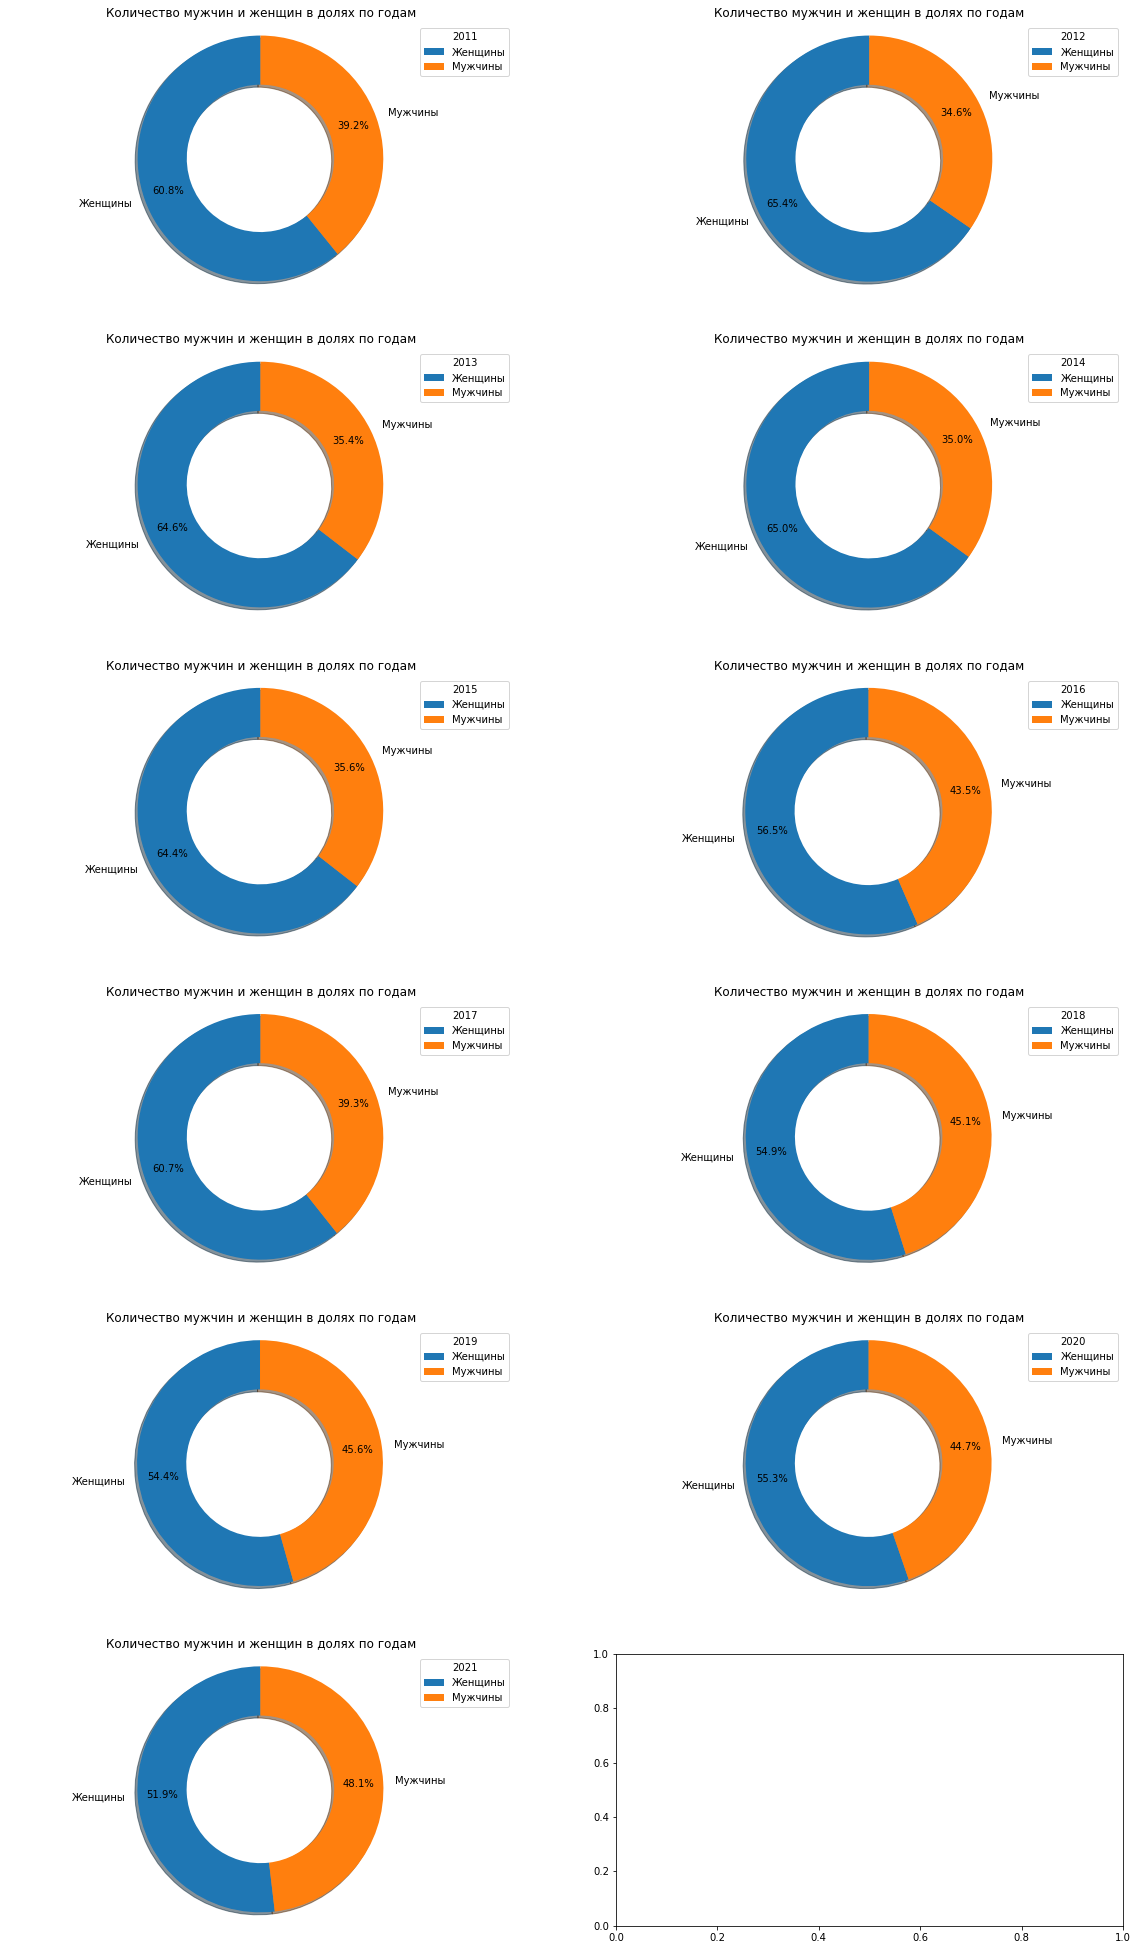

In [18]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(20, 35));

ax_dict = { 
    2011:(0,0),
    2012:(0,1),
    2013:(1,0),
    2014:(1,1),
    2015:(2,0),
    2016:(2,1),
    2017:(3,0),
    2018:(3,1),
    2019:(4,0),
    2020:(4,1),
    2021:(5,0)
}

for y in vk_gen_pie['year'].unique():
    i,j = ax_dict[y]
    #axes[i,j].set_ylabel('Медианная стоимость')
    axes[i,j].set_title('Количество мужчин и женщин в долях по годам')
    axes[i,j].pie(vk_gen_pie.query('year == @y')['value'],
        labels=vk_gen_pie['label'].unique(),
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90,  
        wedgeprops={'width':0.4}, 
        pctdistance=0.8, 
        labeldistance=1.1)
    axes[i,j].legend(title = y)
    axes[i,j].axis('equal');  


In [19]:
vk_gen_plot = vk_gen_new.groupby('year').agg({'women':'sum', 'men':'sum'}).reset_index()
vk_gen_plot

year   women     men
0   2011   17924   11552
1   2012   15590    8248
2   2013   33604   18448
3   2014   34890   18782
4   2015   49269   27180
5   2016   46800   36019
6   2017  494631  320482
7   2018  118809   97674
8   2019  121165  101648
9   2020   56495   45708
10  2021   32621   30275

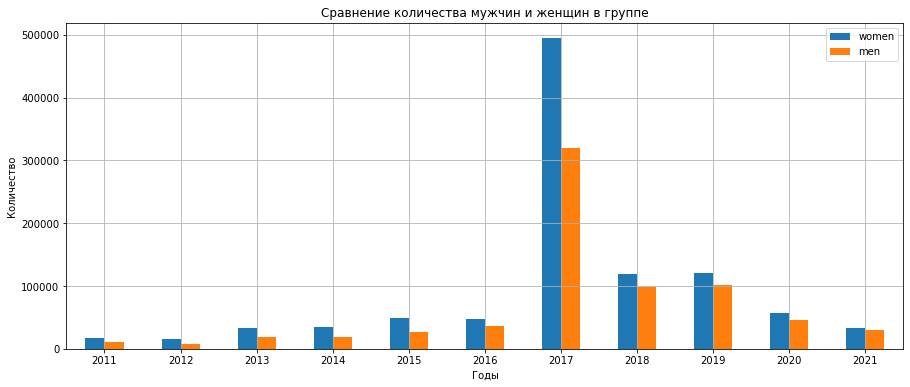

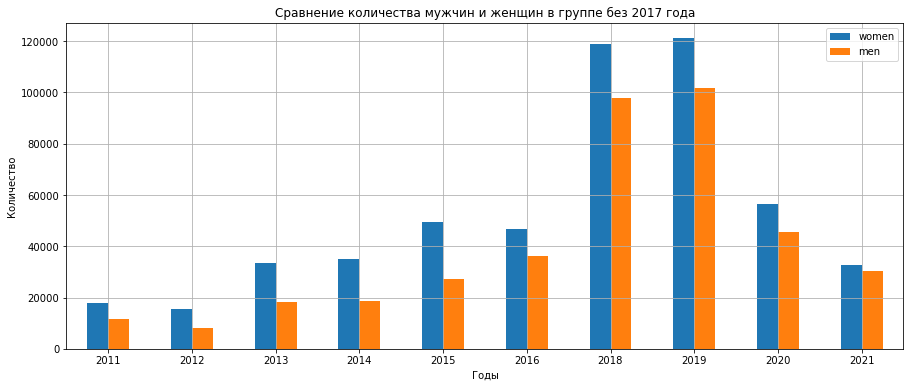

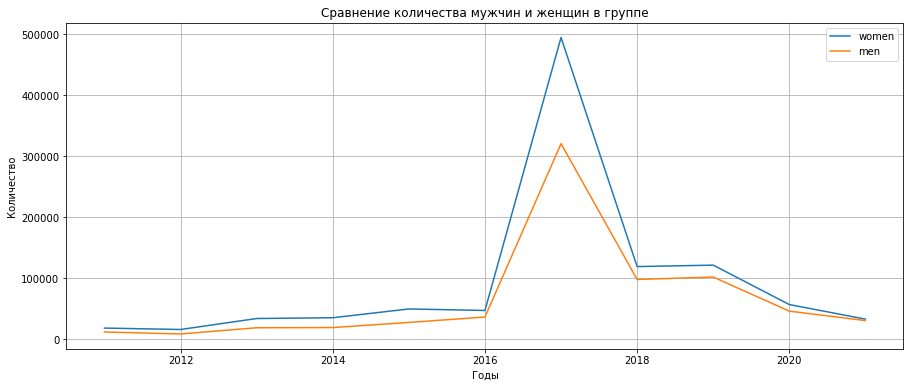

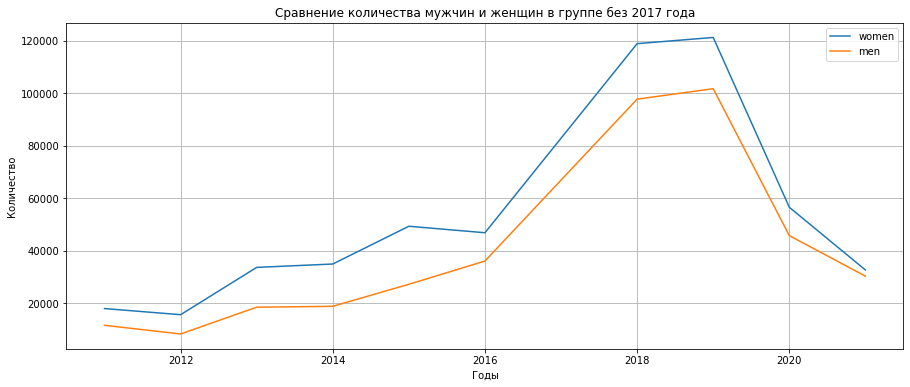

In [20]:
#Строим столбчатую диаграмму
yt = vk_gen_plot.plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин и женщин в группе")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt = vk_gen_plot.query('year != 2017').plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин и женщин в группе без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим линейную диаграмму
yt = vk_gen_plot.plot(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин и женщин в группе")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим линейную диаграмму
yt = vk_gen_plot.query('year != 2017').plot(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин и женщин в группе без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

**Выводы**

Количество женщин в группе ВК превышает количество мужчин. Соотношение на протяжении 2011-2016 годов было примерно 1 к 3, но с 2017 по нынешнее время начало меняться в сторону мужчин и к нынешнему времени почти уравнялось.

--------------------------------------

### Обратим внимание на количество просмотров

In [21]:
#Возьмём срез по критерию
vk_vie = vk_all.query('criterion == "views"').copy()
#Отрежем ненужные колонки 
vk_vie = vk_vie.drop(['param_2','criterion', 'param_1'], axis=1)
#Переименуем колонки
vk_vie = vk_vie.rename(columns={'value': 'views'})
vk_vie

date  views  year  month  day
0     2011-12-31     45  2011     12   31
34    2011-12-30     64  2011     12   30
74    2011-12-29     78  2011     12   29
130   2011-12-28    104  2011     12   28
179   2011-12-27    138  2011     12   27
...          ...    ...   ...    ...  ...
25769 2021-01-05    325  2021      1    5
25846 2021-01-04    367  2021      1    4
25918 2021-01-03    421  2021      1    3
25988 2021-01-02    421  2021      1    2
26063 2021-01-01    227  2021      1    1

[4014 rows x 5 columns]

In [124]:
# Количество просмотров за каждый код
vk_vie.groupby('year').agg({'views':'sum'}).style.background_gradient('coolwarm')

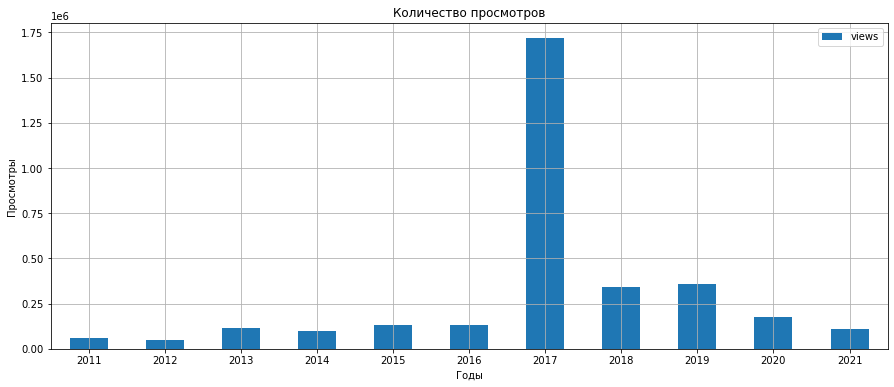

In [23]:
# Построим график количества просмотров по годам
vk_graph_bar(vk_vie, 'year','views', 'Количество просмотров', 'Просмотры')

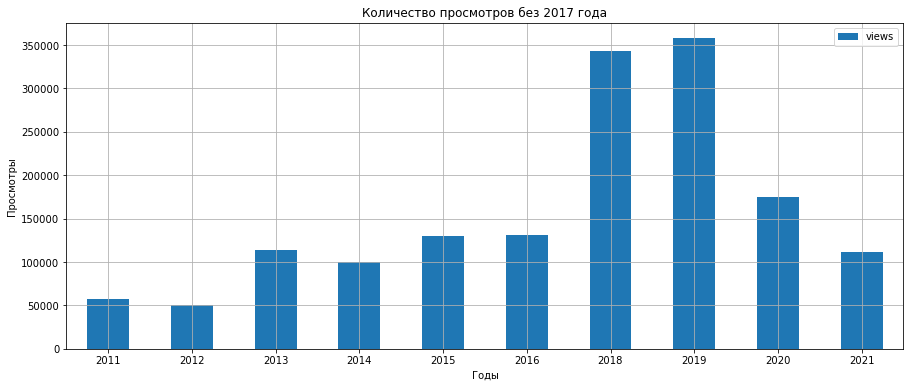

In [24]:
# Построим график количества просмотров по годам без 2017 года
vk_graph_bar(vk_vie.query('year != 2017'), 'year','views', 'Количество просмотров без 2017 года', 'Просмотры')

**Выводы**

По количеству участников/визитов наблюдается аномальный всплеск в 2017 году, а именно в июне. 2018-2019 также отмечены повышенным участием. В 2020-2021 годах интерес участников возвращается к среднему по периоду до 2017 года.

Динамика количества просмотров естественно совпадает с активностью в группе. 2017 год - абсолютный пик просмотров 1718000. Затем просмотры постепенно снижались, пока в 2021 году не достигли уровня 2013 года в чуть более 100000 просмотров. 

--------------------------------------------------

### Посмотрим статистику в разрезе уникальных посетителей

In [25]:
#Возьмём срез по критерию
vk_vis = vk_all.query('criterion == "visitors"').copy()

#Отрежем колонки 
vk_vis = vk_vis.drop(['param_2','criterion', 'param_1'], axis=1)
#Переименуем колонки
vk_vis = vk_vis.rename(columns={'value': 'visitors'})

display(vk_vis)

date  visitors  year  month  day
1     2011-12-31        25  2011     12   31
35    2011-12-30        34  2011     12   30
75    2011-12-29        43  2011     12   29
131   2011-12-28        57  2011     12   28
180   2011-12-27        67  2011     12   27
...          ...       ...   ...    ...  ...
25770 2021-01-05       240  2021      1    5
25847 2021-01-04       266  2021      1    4
25919 2021-01-03       257  2021      1    3
25989 2021-01-02       297  2021      1    2
26064 2021-01-01       168  2021      1    1

[4014 rows x 5 columns]

In [26]:
#Добавим колонку с номером недели
vk_vis['week'] = vk_vis['date'].dt.week
vk_vis

date  visitors  year  month  day  week
1     2011-12-31        25  2011     12   31    52
35    2011-12-30        34  2011     12   30    52
75    2011-12-29        43  2011     12   29    52
131   2011-12-28        57  2011     12   28    52
180   2011-12-27        67  2011     12   27    52
...          ...       ...   ...    ...  ...   ...
25770 2021-01-05       240  2021      1    5     1
25847 2021-01-04       266  2021      1    4     1
25919 2021-01-03       257  2021      1    3    53
25989 2021-01-02       297  2021      1    2    53
26064 2021-01-01       168  2021      1    1    53

[4014 rows x 6 columns]

In [27]:
#Посчитаем посещаемость по месяцам за каждый год
vis_m_plot = pd.pivot_table(vk_vis, 
                                index='month', 
                                columns='year', 
                                values='visitors', 
                                aggfunc='sum')
#Выведем тепловую карту посещений
vis_m_plot.style.background_gradient('coolwarm')

In [28]:
#Посчитаем посещаемость по дням за каждый год
vis_d_plot = pd.pivot_table(vk_vis, 
                                index='day', 
                                columns='year', 
                                values='visitors', 
                                aggfunc='sum')
#Выведем тепловую карту посещений
vis_d_plot.style.background_gradient('coolwarm')

In [29]:
#Посчитаем посещаемость по неделям за каждый год
vis_w_plot = pd.pivot_table(vk_vis, 
                                index='week', 
                                columns='year', 
                                values='visitors', 
                                aggfunc='sum')

#Удалим последнюю строку из-за лишних пропусков
vis_w_plot = vis_w_plot.drop(labels = [53],axis = 0)

#Вернём значения в целочисленный тип
vis_w_plot = vis_w_plot.astype('int64')

#Выведем тепловую карту посещений
vis_w_plot.style.background_gradient('coolwarm')

Построим графики

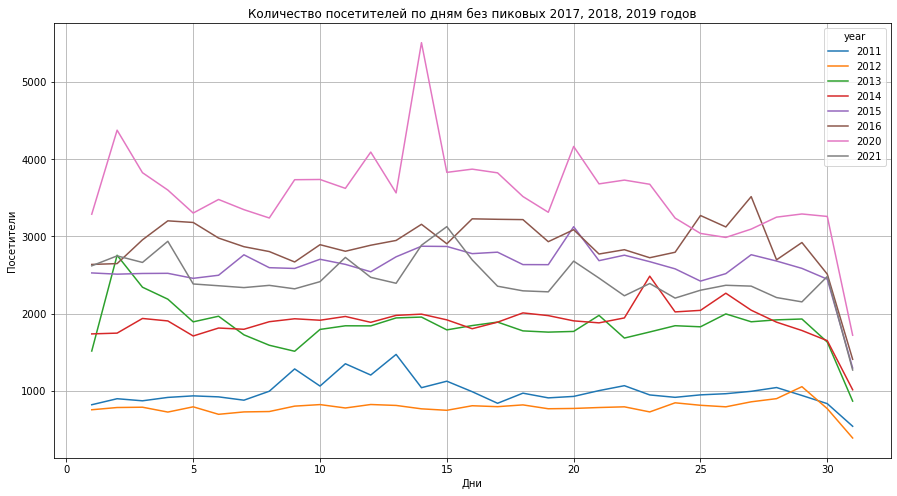

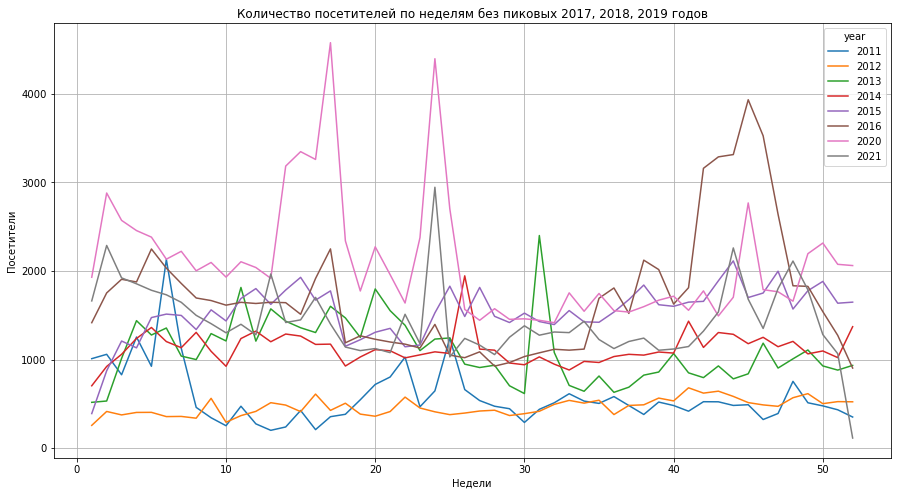

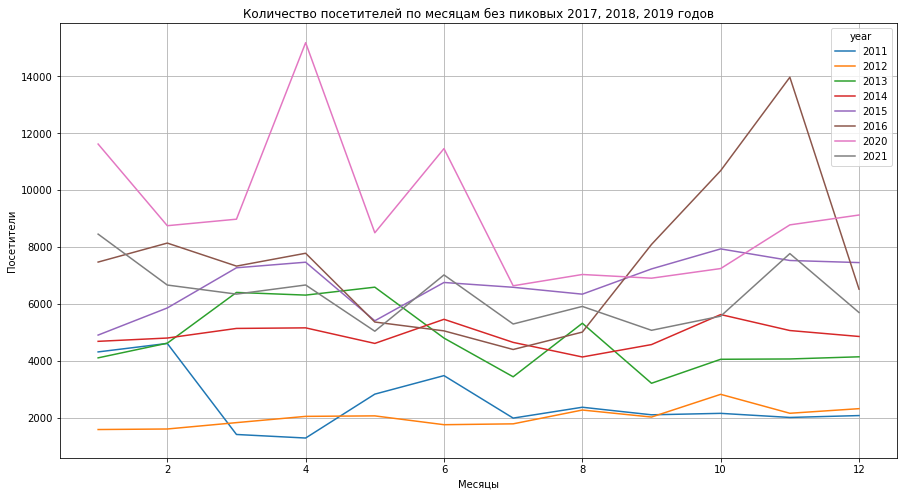

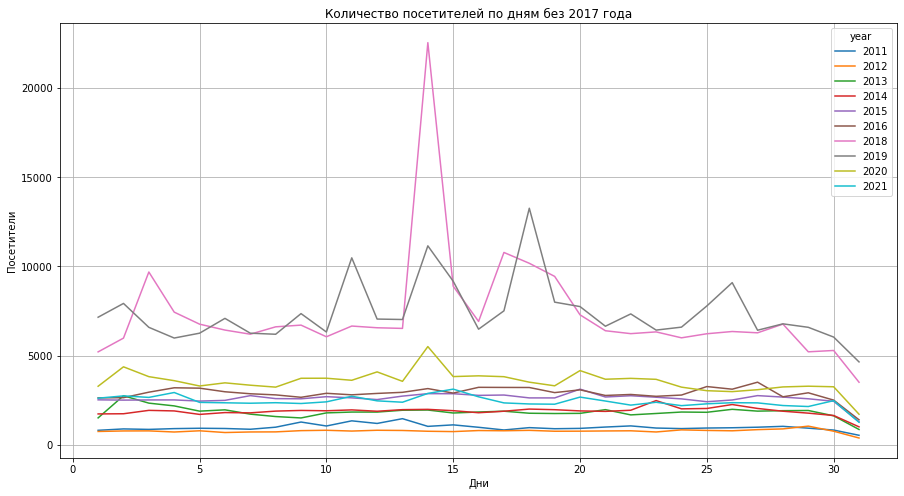

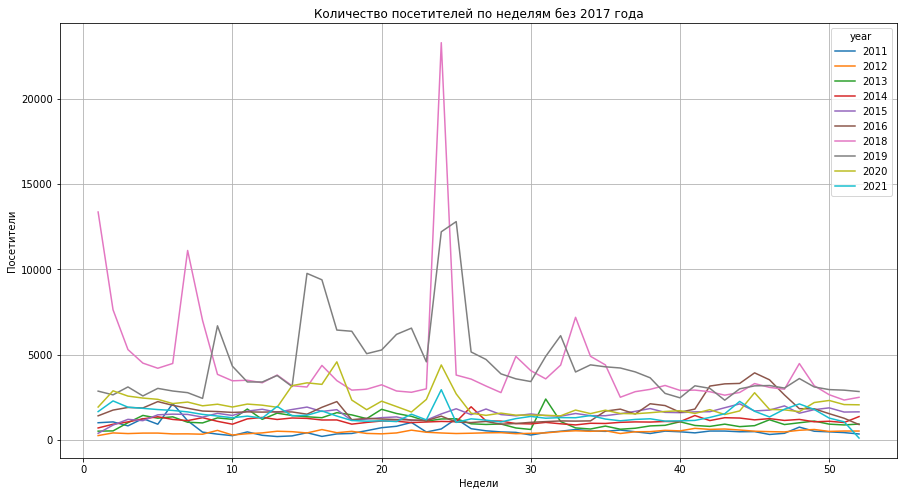

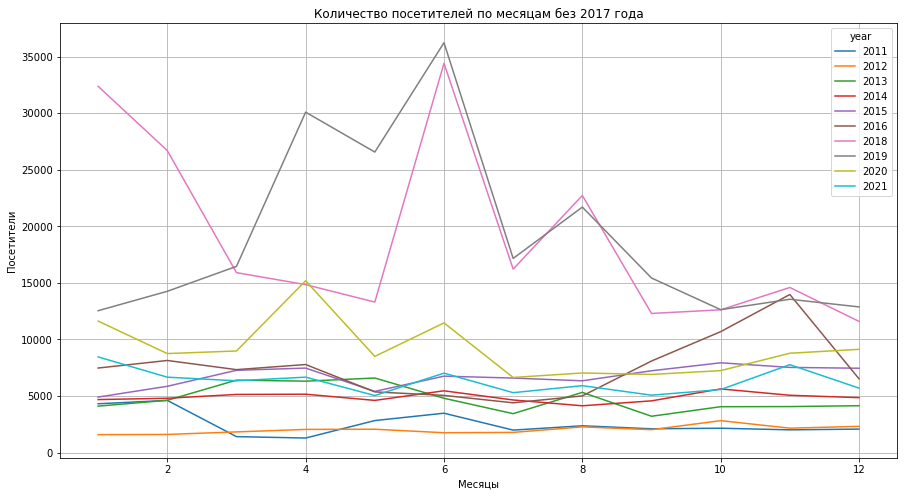

In [30]:
#Зададим список для группировок
group_date = ['day', 'week', 'month']

vis_list = [vis_d_plot,vis_w_plot,vis_m_plot]

#Словарь для подписей на графиках
groupd_label = {'day':'Дни', 
               'week':'Недели', 
               'month':'Месяцы'}
groupt_label = {'day':'дням', 
               'week':'неделям', 
               'month':'месяцам'}

#Строим линейную диаграмму
for vis in vis_list:
    dat = vis.drop([2017,2018,2019], axis=1).plot(figsize=(15,8));
    dat.set_title(f'Количество посетителей по {groupt_label[vis.index.name]} без пиковых 2017, 2018, 2019 годов')
    dat.set_xlabel(groupd_label[vis.index.name])
    dat.set_ylabel('Посетители')
    dat.axes.grid()
 

#Строим линейную диаграмму
for vis in vis_list:
    dat = vis.drop([2017], axis=1).plot(figsize=(15,8));
    dat.set_title(f'Количество посетителей по {groupt_label[vis.index.name]} без 2017 года')
    dat.set_xlabel(groupd_label[vis.index.name])
    dat.set_ylabel('Посетители')
    dat.axes.grid()
    

In [1]:
#Зададим список для группировок
group_date = ['day', 'week', 'month']

#Словарь для подписей на графиках
groupd_label = {'day':'Дни', 
               'week':'Недели', 
               'month':'Месяцы'}
groupt_label = {'day':'дням', 
               'week':'неделям', 
               'month':'месяцам'}

#Построим графики посещаемости в зависимости от временного периода
#for group in group_date:
#    for y in vk_vis['year'].unique():     
#        dat = vk_vis.query('year == @y').groupby(group).agg({'visitors':'sum'}).plot(figsize=(12,5));
#        dat.set_title(f'Количество посетителей по {groupt_label[group]} в {y} году')
#        dat.set_xlabel(groupd_label[group])
#        dat.set_ylabel('Посетители')
#        dat.axes.grid()

In [32]:
#Зададим список для группировок
group_date = ['day', 'week', 'month']

#Словарь для подписей
groupdwm_label = {'day':'DAU', 
               'week':'WAU', 
               'month':'MAU'}
dau =[]
mau=[]
wau=[]
year=vk_vis['year'].unique()

#Вычисляем среднюю посещаемость в зависимости от временного периода
for y in vk_vis['year'].unique():
    for group in group_date:
        total = vk_vis.query('year == @y').groupby(group).agg({'visitors':'sum'}).mean()
        if groupdwm_label[group] == 'DAU':
            dau.append(int(total))
        if groupdwm_label[group] == 'WAU':
            wau.append(int(total))
        if groupdwm_label[group] == 'MAU':
            mau.append(int(total))
        
dwm = pd.DataFrame({"year": year,"dau": dau,"wau": wau,"mau": mau})
dwm.style.background_gradient('coolwarm')

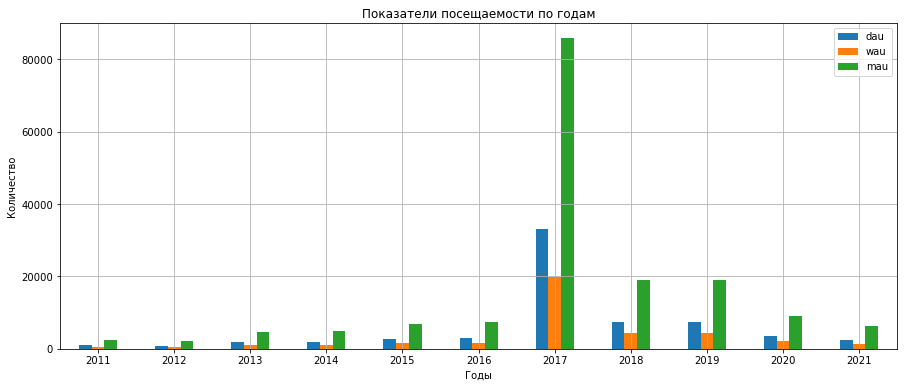

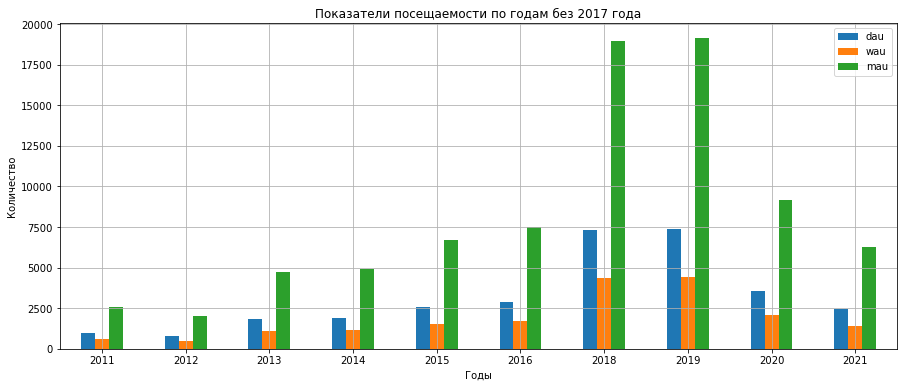

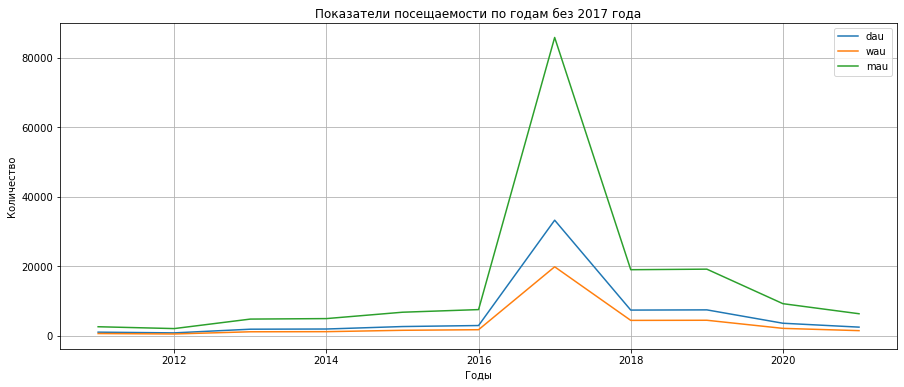

In [33]:
#Строим столбчатую диаграмму
yt = dwm.plot.bar(x='year',figsize=(15,6))
yt.set_title("Показатели посещаемости по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt = dwm.query('year != 2017').plot.bar(x='year',figsize=(15,6))
yt.set_title("Показатели посещаемости по годам без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()


#Строим линейную диаграмму
yt = dwm.plot(x='year',figsize=(15,6))
yt.set_title("Показатели посещаемости по годам без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

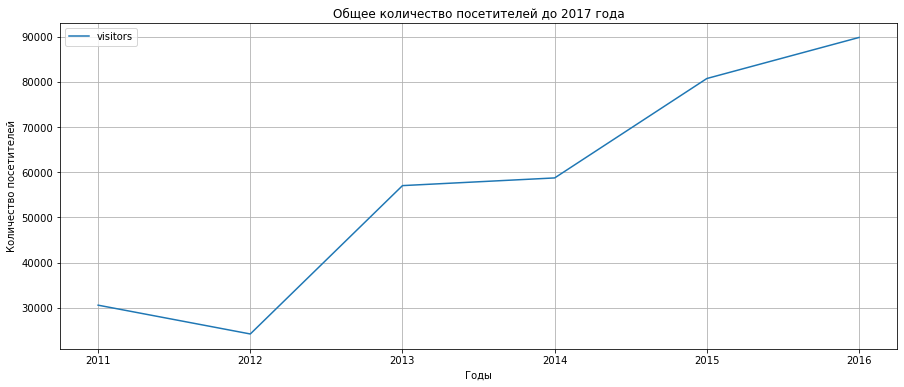

In [34]:
vk_graph(vk_vis.query('year < 2017'), 
         'year',
         'visitors',
         'Общее количество посетителей до 2017 года',
         'Количество посетителей')

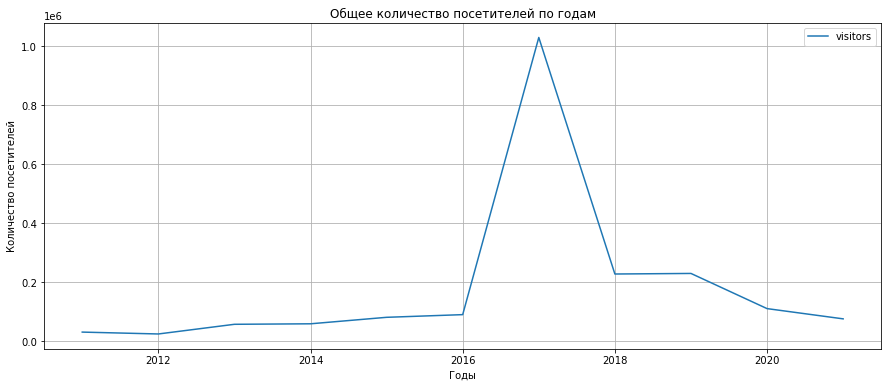

In [35]:
vk_graph(vk_vis, 'year','visitors','Общее количество посетителей по годам','Количество посетителей')

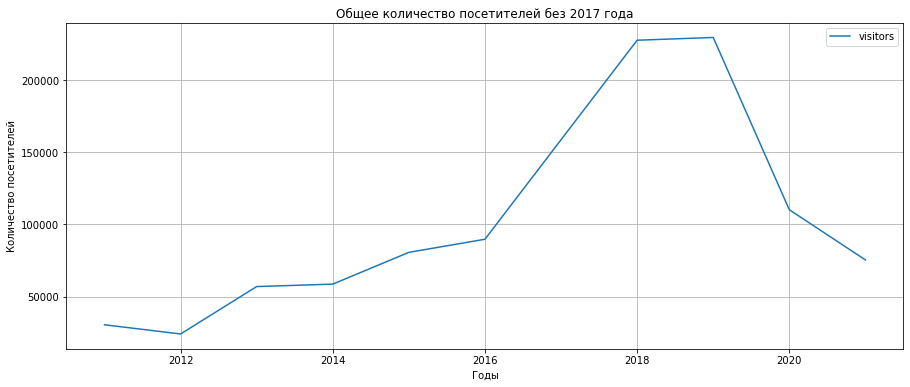

In [36]:
vk_graph(vk_vis.query('year != 2017'), 
         'year',
         'visitors',
         'Общее количество посетителей без 2017 года',
         'Количество посетителей')

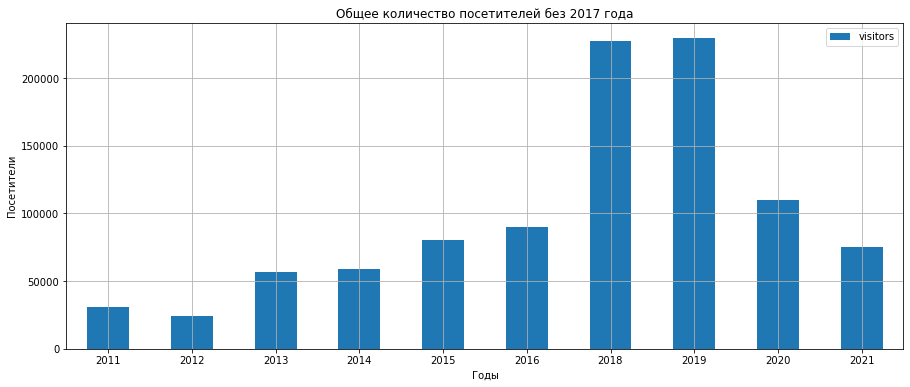

In [37]:
vk_graph_bar(vk_vis.query('year != 2017'), 
             'year',
             'visitors', 
             'Общее количество посетителей без 2017 года', 
             'Посетители')

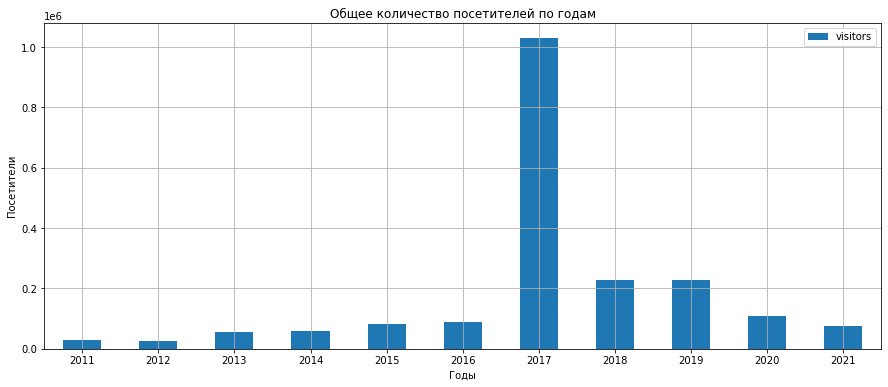

In [38]:
vk_graph_bar(vk_vis, 'year','visitors', 'Общее количество посетителей по годам', 'Посетители')

In [39]:
vk_vis_plot = vk_vis.groupby('year').agg({'visitors':'sum'})
vk_vis_plot.style.background_gradient('coolwarm')

**Выводы**

Количество уникальных посетителей также коррелирует с количеством просмотров и количеством участников. Плавное увеличение с 2011 по 2016 год от 30 до 90 тысяч, резкий пик в 2017 году - в 1 млн, и стремительный спад в течение последующих нескольких лет.

При этом повышенная активность, отмечается в июне начиная с 2017 года. Пики посещаемости ожидаемо отмечены в международный день донора крови - 14 июня.

-----------------------------------------

### Рассмотрим таблицу в разрезе возраста участников

In [40]:
#Выделим таблицу по критерию возраста
vk_age = vk_all.query('criterion == "age"').copy()

#Отрежем колонки 
vk_age = vk_age.drop(['param_2','criterion'], axis=1)
##Переименуем колонки
vk_age = vk_age.rename(columns={'param_1': 'age', 'value': 'age_value'})
display(vk_age)

date    age  age_value  year  month  day
4     2011-12-31   1-18          4  2011     12   31
5     2011-12-31  18-21          5  2011     12   31
6     2011-12-31  21-24          2  2011     12   31
7     2011-12-31  24-27          3  2011     12   31
8     2011-12-31  27-30          1  2011     12   31
...          ...    ...        ...   ...    ...  ...
26070 2021-01-01  24-27         24  2021      1    1
26071 2021-01-01  27-30         19  2021      1    1
26072 2021-01-01  30-35         11  2021      1    1
26073 2021-01-01  35-45         31  2021      1    1
26074 2021-01-01    45+          8  2021      1    1

[31689 rows x 6 columns]

In [41]:
#Cгруппируем данные для круговой диаграммы
vk_age_pie = vk_age.groupby(['year','age']).agg({'age_value':'sum'}).reset_index()
vk_age_pie

year    age  age_value
0   2011   1-18       3526
1   2011  18-21       6772
2   2011  21-24       5930
3   2011  24-27       3785
4   2011  27-30       1717
..   ...    ...        ...
83  2021  24-27       6934
84  2021  27-30       7222
85  2021  30-35      11126
86  2021  35-45      11289
87  2021    45+       4383

[88 rows x 3 columns]

In [42]:
#Посмотрим тепловые карты возрастов по годам
for y in vk_age_pie['year'].unique():
        display(y)
        display(vk_age_pie.query('year == @y')
#                .sort_values(by='age_value', ascending=False)
                .style.background_gradient('coolwarm'))

2011

2012

2013

2014

2015

2016

2017

2018

2019

2020

2021

Видно как с 2011 года, "тепло" уходит в нижнюю часть списка с более возрастными категориями.

Рисуем круговые диаграммы

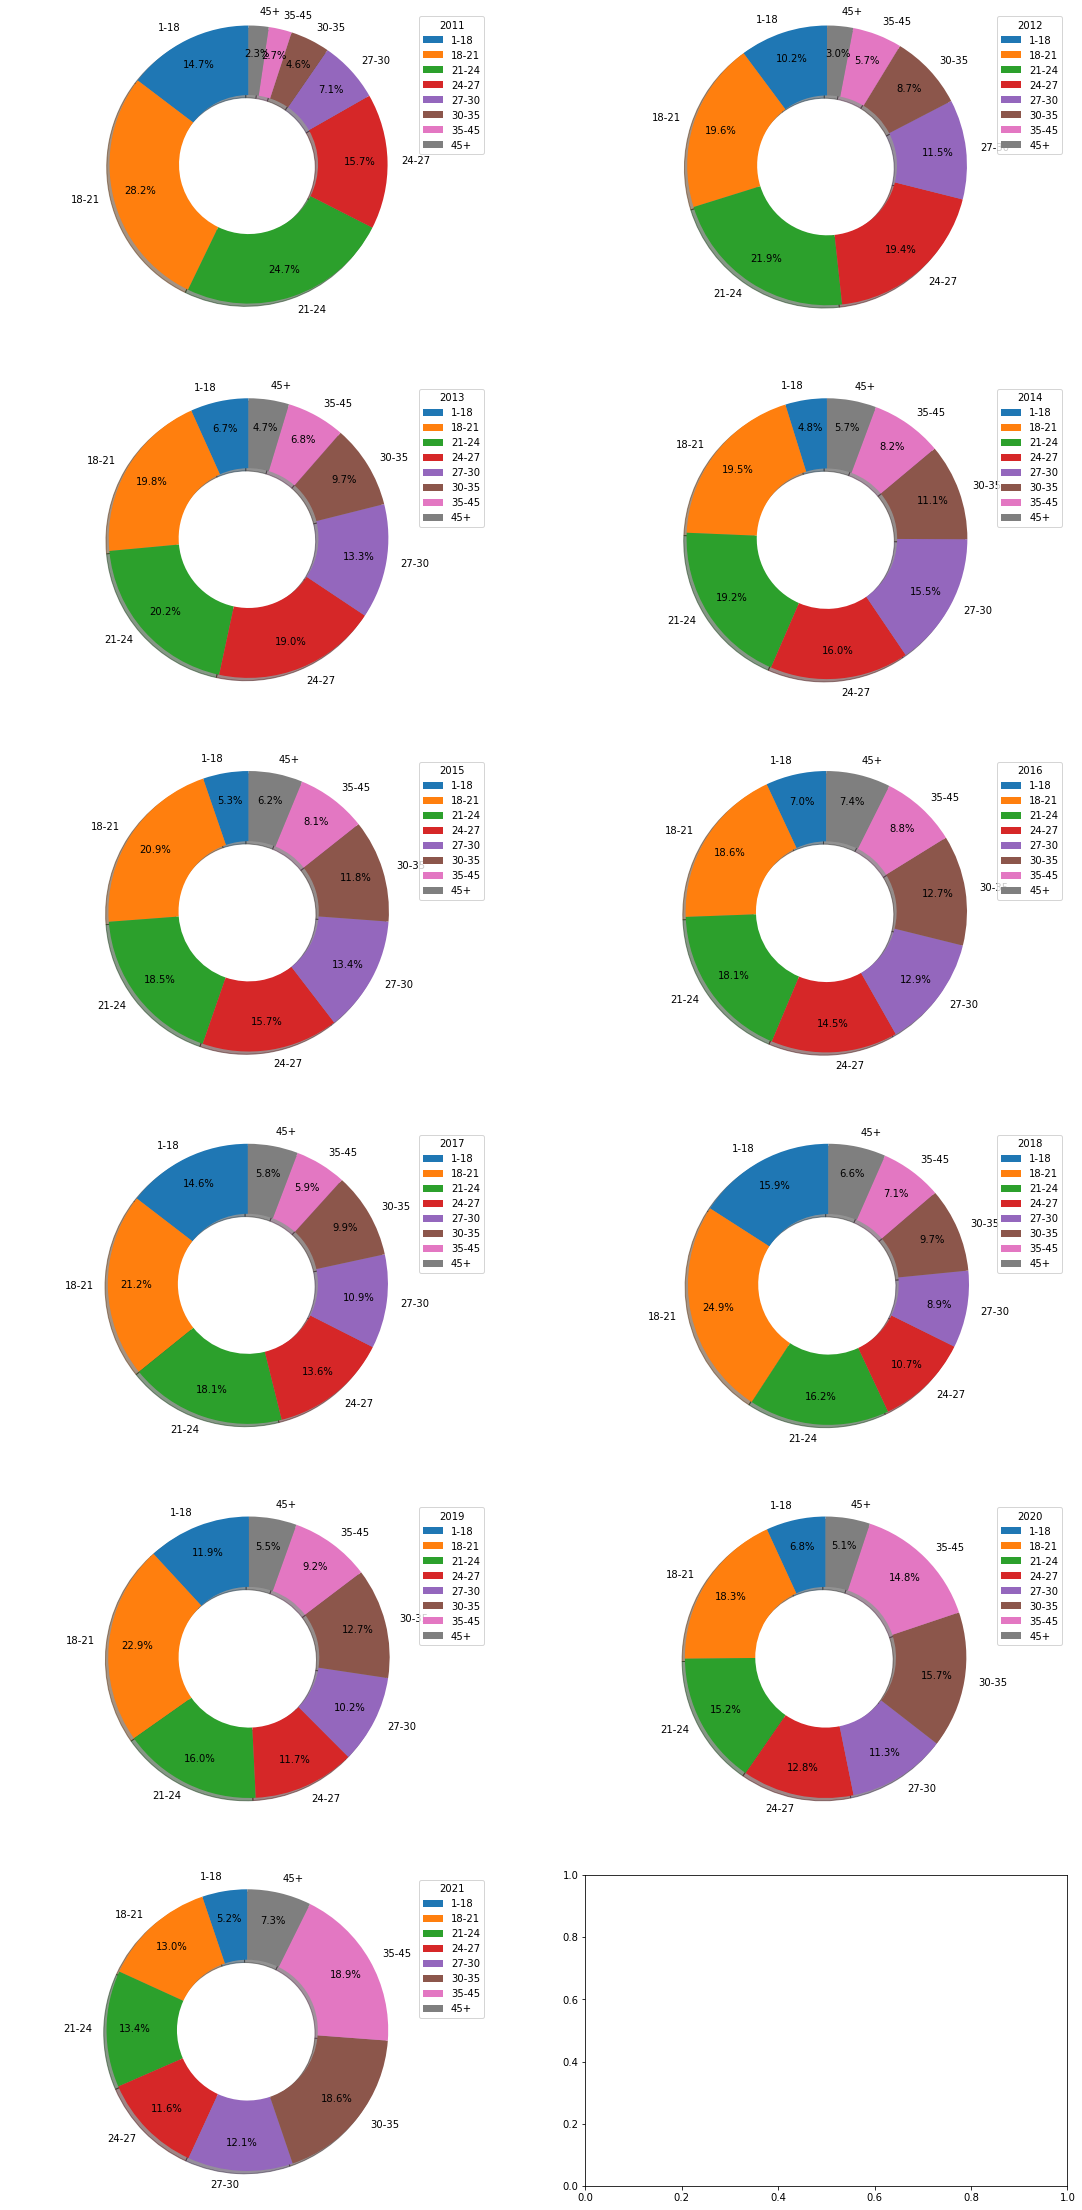

In [43]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(19, 40));

ax_dict = { 
    2011:(0,0),
    2012:(0,1),
    2013:(1,0),
    2014:(1,1),
    2015:(2,0),
    2016:(2,1),
    2017:(3,0),
    2018:(3,1),
    2019:(4,0),
    2020:(4,1),
    2021:(5,0)
}

#Рисуем круговые диаграммы
for y in vk_age_pie['year'].unique():
    i,j = ax_dict[y]
    axes[i,j].pie(vk_age_pie.query('year == @y')['age_value'],
        labels=vk_age_pie['age'].unique(),
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90,  
        wedgeprops={'width':0.5}, 
        pctdistance=0.8, 
        labeldistance=1.1)
    axes[i,j].legend(title = y)
    axes[i,j].axis('equal')  


In [44]:
#Соберём таблицу возрастов
vk_age_new = pd.pivot_table(vk_age, index='date', columns='age', values='age_value').reset_index()
vk_age_new['year'] = vk_age_new['date'].dt.year
vk_age_new['month'] = vk_age_new['date'].dt.month
#vk_all['week'] = vk_all['date'].dt.week
vk_age_new['day'] = vk_age_new['date'].dt.day
vk_age_new

age        date  1-18  18-21  21-24  24-27  27-30  30-35  35-45   45+  year  \
0    2011-01-01   NaN    4.0    7.0    4.0    NaN    NaN    1.0   1.0  2011   
1    2011-01-02   2.0    7.0   11.0    4.0    1.0    1.0    2.0   NaN  2011   
2    2011-01-03   4.0    9.0    3.0    6.0    1.0    NaN    2.0   NaN  2011   
3    2011-01-04   7.0   14.0   11.0    5.0    2.0    NaN    2.0   NaN  2011   
4    2011-01-05   6.0   22.0   22.0   18.0    2.0    2.0    4.0   1.0  2011   
...         ...   ...    ...    ...    ...    ...    ...    ...   ...   ...   
4009 2021-12-23   8.0   14.0   16.0   17.0   13.0   20.0   22.0  11.0  2021   
4010 2021-12-24  22.0   20.0   32.0    9.0   15.0   14.0   26.0  16.0  2021   
4011 2021-12-25  11.0   19.0   17.0    9.0   12.0   17.0   20.0  11.0  2021   
4012 2021-12-26  19.0   30.0   22.0   24.0   11.0   24.0   33.0   9.0  2021   
4013 2021-12-27   8.0   18.0   16.0    9.0    6.0   13.0   21.0  14.0  2021   

age   month  day  
0         1    1  
1         1    2  
2         1    3  
3         1    4  
4         1    5  
...     ...  ...  
4009     12   23  
4010     12   24  
4011     12   25  
4012     12   26  
4013     12   27  

[4014 rows x 12 columns]

In [45]:
#Сгруппируем таблицу по годам для построения графика
vk_age_plot = (vk_age_new.groupby('year')
.agg({'1-18':'sum', '18-21':'sum','21-24':'sum', '24-27':'sum','27-30':'sum','30-35':'sum','35-45':'sum','45+':'sum'}))

#Вернём значения в целочисленный тип
vk_age_plot = vk_age_plot.astype('int64')

vk_age_plot.style.background_gradient('coolwarm')

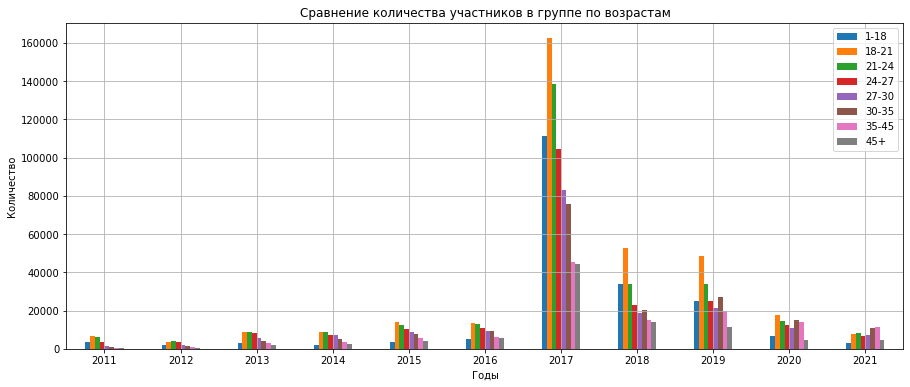

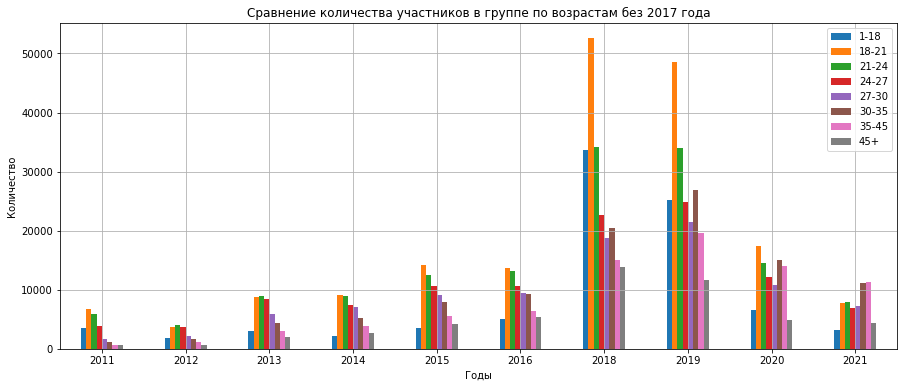

In [46]:
#Строим столбчатую диаграмму
yt = vk_age_plot.reset_index().plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества участников в группе по возрастам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt = vk_age_plot.reset_index().query('year != 2017').plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества участников в группе по возрастам без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

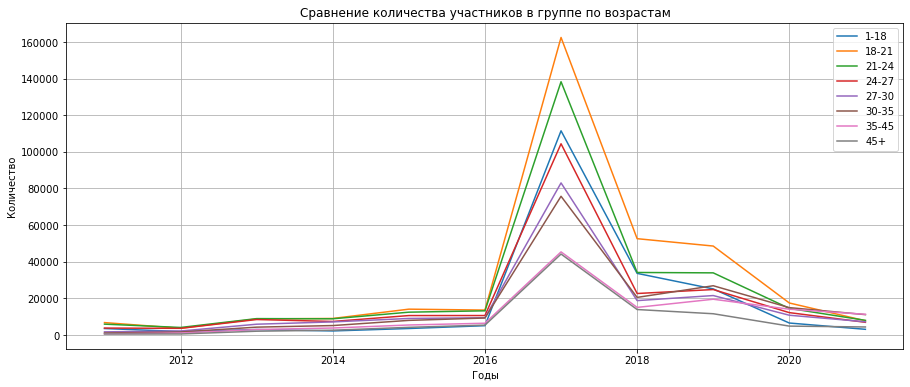

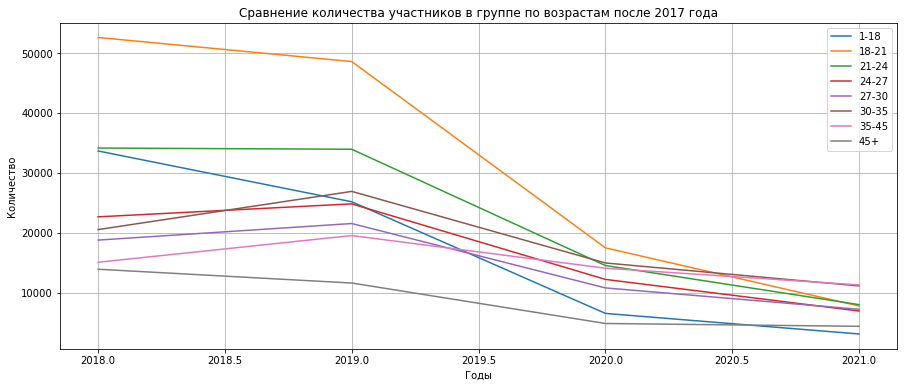

In [47]:
#Строим столбчатую диаграмму
yt = vk_age_plot.reset_index().plot(x='year',figsize=(15,6))
yt.set_title("Сравнение количества участников в группе по возрастам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt = vk_age_plot.reset_index().query('year > 2017').plot(x='year',figsize=(15,6))
yt.set_title("Сравнение количества участников в группе по возрастам после 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

**Выводы**

Начиная с 2011 года самыми населёнными возрастными группами являлись 18-21, 21-24, за ними с небольшим отставанием шла группа 24-27 и т.д. Населённость группы в целом была обратно пропорционально возрасту. Однако 2018 года группы 30-35, 35-45 стали быстро догонять более молодые группы и к 2021 вышли на первое место. Мы видим, что удержание у групп 30-35, 35-45 и 45+ несколько лучше, чем у остальных. "Старение" аудитории в группе может быть связано и с проблемами самого сервиса ВК, откуда молодые участники перетекают в более модные тикток или инстаграмм. 

---------------------------------

### Посмотрим срез по количеству новых и вышедших из группы участников

In [48]:
#Выбираем срез по критерию 
vk_mem = vk_all.query('criterion == "members"').copy()
#Отрежем колонки 
vk_mem = vk_mem.drop(['param_2','criterion'], axis=1)
#Переименуем колонки
vk_mem = vk_mem.rename(columns={'value': 'mem_value', 'param_1': 'members'})
vk_mem

date             members  mem_value  year  month  day
33    2011-12-31     Новые участники          4  2011     12   31
72    2011-12-30     Новые участники          5  2011     12   30
73    2011-12-30  Вышедшие участники          1  2011     12   30
128   2011-12-29     Новые участники          8  2011     12   29
129   2011-12-29  Вышедшие участники          3  2011     12   29
...          ...                 ...        ...   ...    ...  ...
25986 2021-01-03  Вышедшие участники         29  2021      1    3
26061 2021-01-02     Новые участники         13  2021      1    2
26062 2021-01-02  Вышедшие участники         42  2021      1    2
26135 2021-01-01     Новые участники          8  2021      1    1
26136 2021-01-01  Вышедшие участники         26  2021      1    1

[7912 rows x 6 columns]

In [49]:
#Соберём таблицу возрастов
vk_mem_new = pd.pivot_table(vk_mem, index='date', columns='members', values='mem_value').reset_index()
vk_mem_new = vk_mem_new.rename(columns={'Новые участники': 'new', 'Вышедшие участники': 'left' })
vk_mem_new['year'] = vk_mem_new['date'].dt.year
vk_mem_new['month'] = vk_mem_new['date'].dt.month
#vk_all['week'] = vk_all['date'].dt.week
vk_mem_new['day'] = vk_mem_new['date'].dt.day
vk_mem_new

members       date  left   new  year  month  day
0       2011-02-02  30.0  12.0  2011      2    2
1       2011-02-03  36.0  16.0  2011      2    3
2       2011-02-04  22.0  14.0  2011      2    4
3       2011-02-05  19.0  20.0  2011      2    5
4       2011-02-06  16.0  13.0  2011      2    6
...            ...   ...   ...   ...    ...  ...
3977    2021-12-23  18.0  10.0  2021     12   23
3978    2021-12-24  14.0  12.0  2021     12   24
3979    2021-12-25  15.0   7.0  2021     12   25
3980    2021-12-26  13.0  13.0  2021     12   26
3981    2021-12-27   8.0   9.0  2021     12   27

[3982 rows x 6 columns]

In [50]:
vk_mem_pie = vk_mem.groupby(['year','members']).agg({'mem_value':'sum'}).reset_index()

vk_mem_pie

year             members  mem_value
0   2011  Вышедшие участники       2274
1   2011     Новые участники       3625
2   2012  Вышедшие участники        955
3   2012     Новые участники       2923
4   2013  Вышедшие участники       2443
5   2013     Новые участники       6510
6   2014  Вышедшие участники       2906
7   2014     Новые участники       6736
8   2015  Вышедшие участники       3939
9   2015     Новые участники      10744
10  2016  Вышедшие участники       5119
11  2016     Новые участники      14354
12  2017  Вышедшие участники      65020
13  2017     Новые участники     316679
14  2018  Вышедшие участники      42447
15  2018     Новые участники      24235
16  2019  Вышедшие участники      27325
17  2019     Новые участники      27030
18  2020  Вышедшие участники      12554
19  2020     Новые участники       9446
20  2021  Вышедшие участники      56376
21  2021     Новые участники       5137

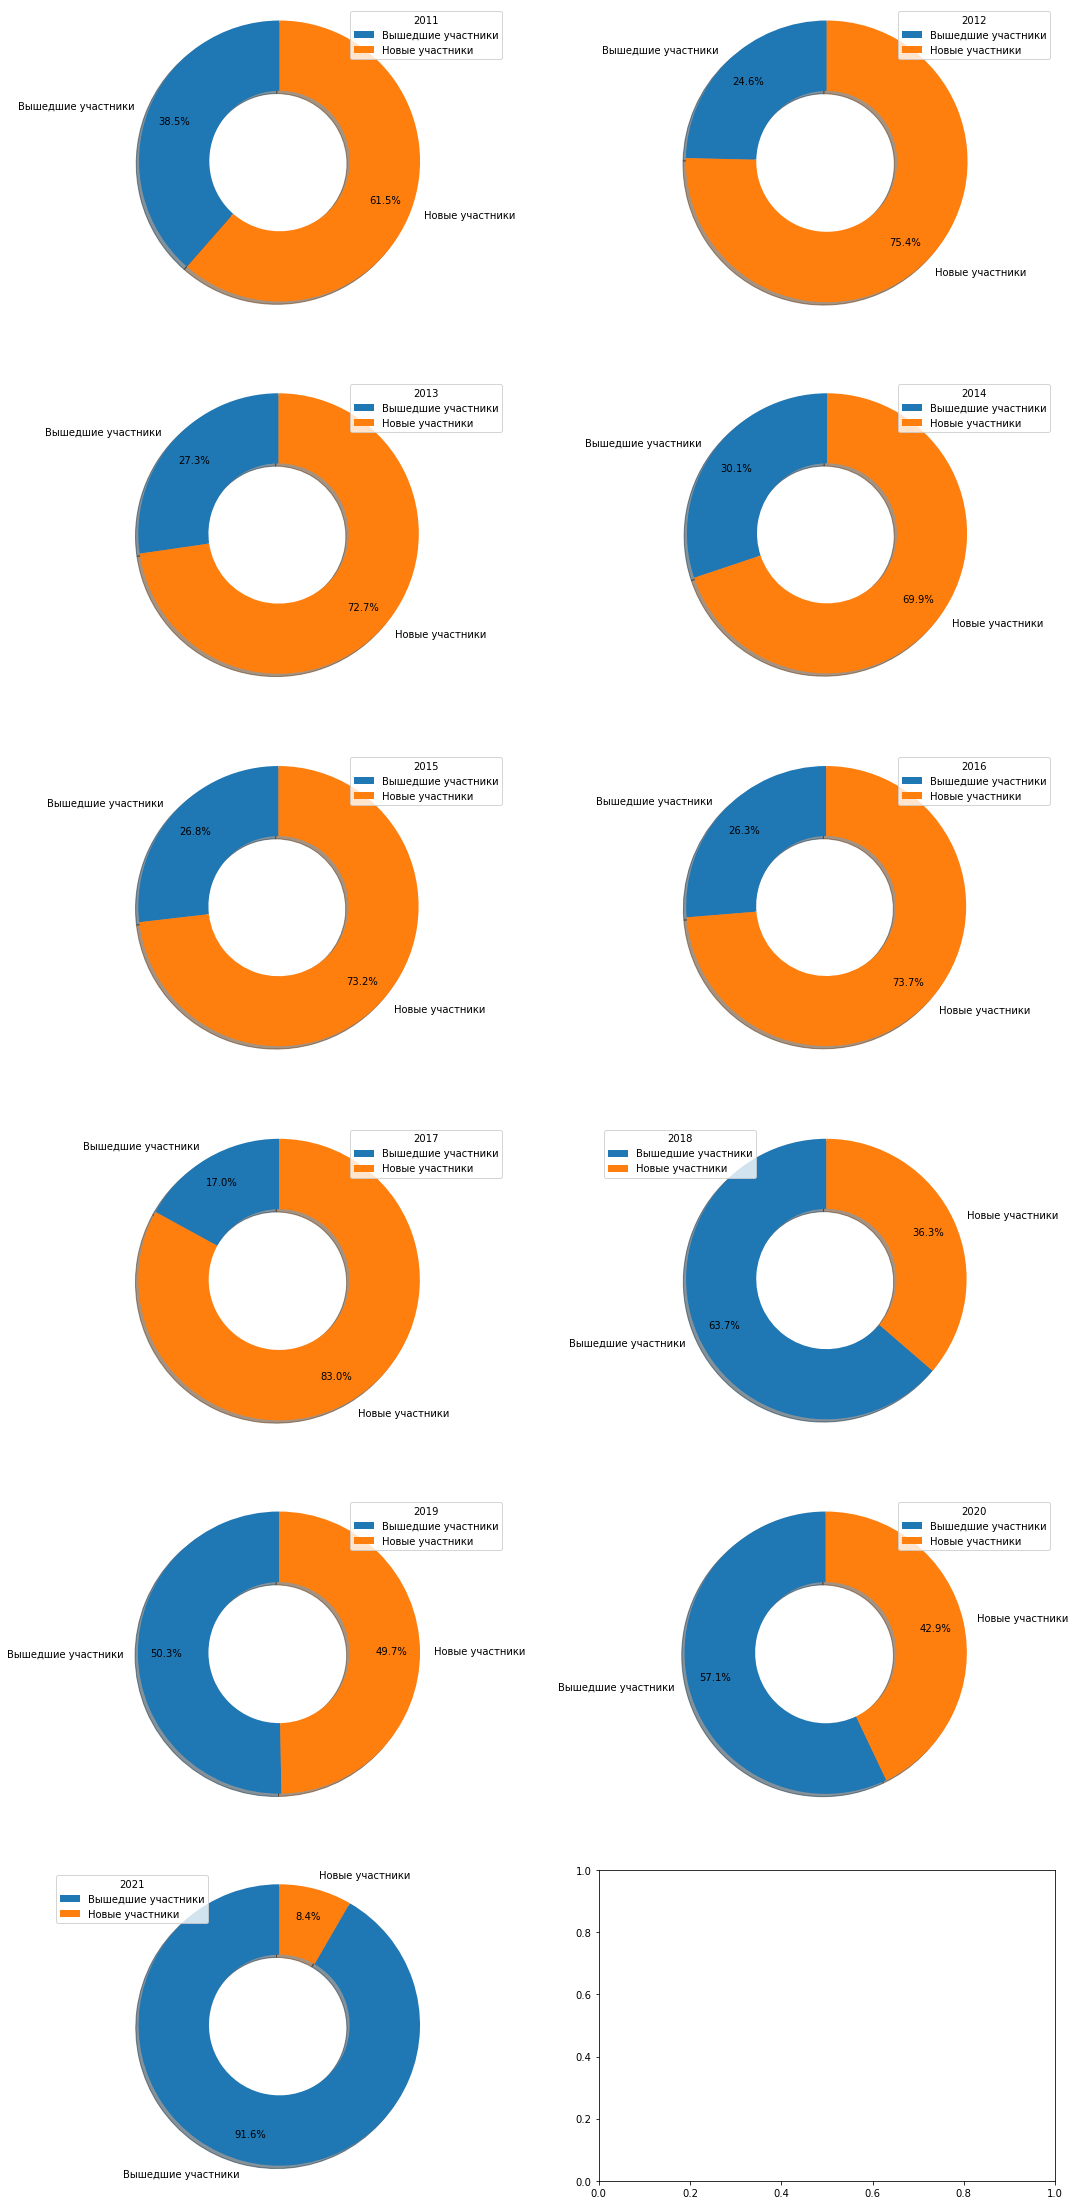

In [51]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(18, 40));

#Рисуем круговые диаграммы
for y in vk_mem_pie['year'].unique():
    i,j = ax_dict[y]
    axes[i,j].pie(vk_mem_pie.query('year == @y')['mem_value'],
        labels=vk_mem_pie['members'].unique(),
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90,  
        wedgeprops={'width':0.5}, 
        pctdistance=0.8, 
        labeldistance=1.1)
    axes[i,j].legend(title = y)
    axes[i,j].axis('equal')  

In [52]:
#Соберём таблицу для линейного графика
vk_mem_plot = vk_mem_new.groupby(['year']).agg({'new':'sum', 'left':'sum'})

#Вернём значения в целочисленный тип
vk_mem_plot = vk_mem_plot.astype('int64')

vk_mem_plot.style.background_gradient('coolwarm')

In [53]:
#Посчитаем процентное соотношение вышедших и новых участников
vk_mem_plot['rate'] = round((vk_mem_plot['new'] - vk_mem_plot['left']) / vk_mem_plot['new'] *100)

#Вернём значения в целочисленный тип
vk_mem_plot = vk_mem_plot.astype('int64')

vk_mem_plot.style.background_gradient('coolwarm')

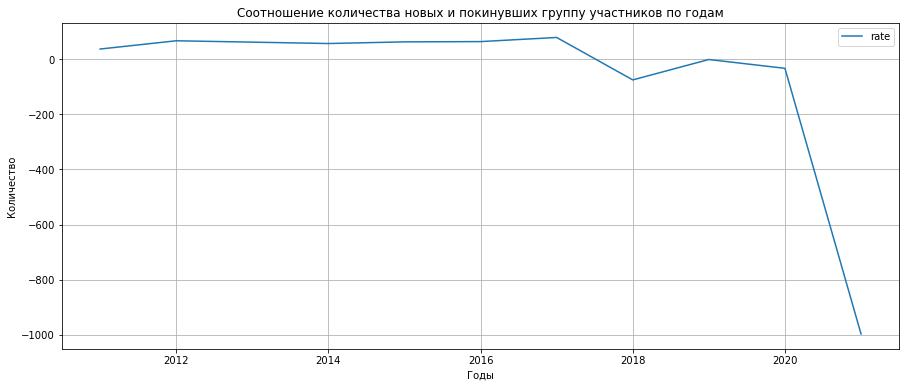

In [54]:
#Строим диаграмму соотношения притока и оттока
yt = vk_mem_plot.reset_index().plot(x='year', y='rate',figsize=(15,6))
yt.set_title("Соотношение количества новых и покинувших группу участников по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

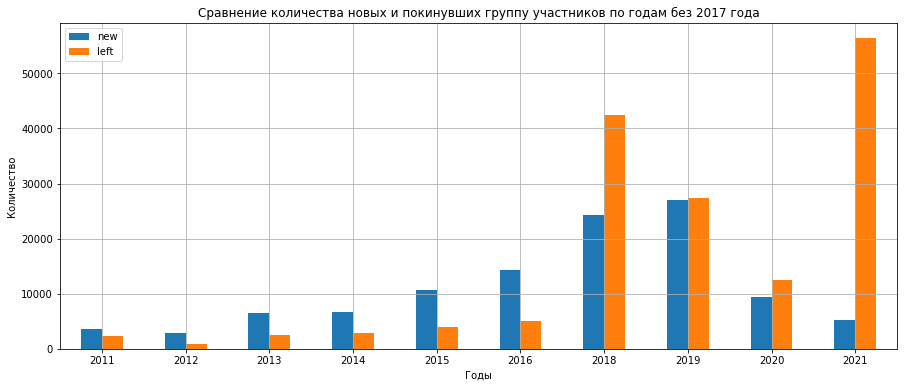

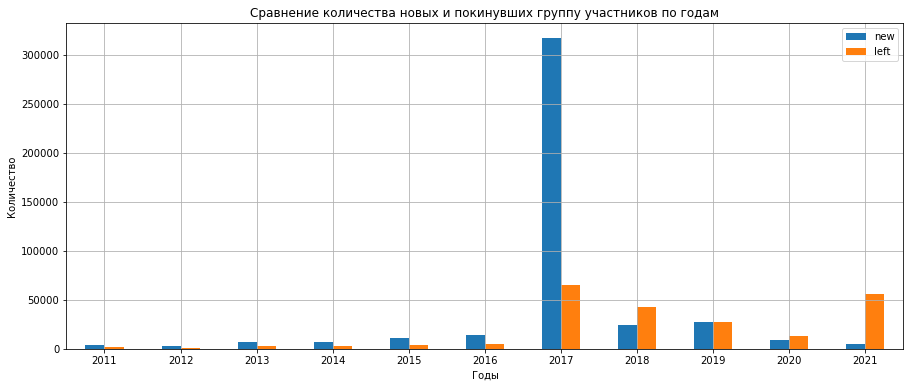

In [55]:
#Строим столбчатую диаграмму
yt = vk_mem_plot.reset_index().query('year != 2017').plot.bar(x='year', y=['new','left'],figsize=(15,6))
yt.set_title("Сравнение количества новых и покинувших группу участников по годам без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt = vk_mem_plot.reset_index().plot.bar(x='year', y=['new','left'],figsize=(15,6))
yt.set_title("Сравнение количества новых и покинувших группу участников по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

**Выводы**

До 2017 года приток стабильно опережал отток, начиная с 2018 года наблюдается обратная ситуация.
Есть вероятность, что часть участников схлынула после пикового 2017 года. Тем не менее с 2018 по 2020 год приток был сравним с оттоком, а в 2021-м году произошла резкая потеря участников, при крайне низком уровне пополнения.

-------------------------------

### Посмотрим доли участников по возрастам в разрезе пола

In [56]:
vk_gage = vk_all.query('criterion == "gender_age"').copy()

#Отрежем колонки criterion 
vk_gage = vk_gage.drop(['criterion'], axis=1)
#Переименуем колонку value в значение criterion
vk_gage = vk_gage.rename(columns={'param_1': 'gender_age', 'param_2': 'age_gender', 'value': 'gage_value'})

display(vk_gage)

date gender_age age_gender  gage_value  year  month  day
9     2011-12-31          Ж       1-18           3  2011     12   31
10    2011-12-31          Ж      18-21           3  2011     12   31
11    2011-12-31          Ж      21-24           1  2011     12   31
12    2011-12-31          Ж      24-27           1  2011     12   31
13    2011-12-31          Ж      27-30           1  2011     12   31
...          ...        ...        ...         ...   ...    ...  ...
26086 2021-01-01          М      24-27          18  2021      1    1
26087 2021-01-01          М      27-30           8  2021      1    1
26088 2021-01-01          М      30-35           9  2021      1    1
26089 2021-01-01          М      35-45          19  2021      1    1
26090 2021-01-01          М        45+           5  2021      1    1

[61591 rows x 7 columns]

In [57]:
vk_gage_pie = vk_gage.groupby(['year','gender_age', 'age_gender']).agg({'gage_value':'sum'}).reset_index()
vk_gage_pie

year gender_age age_gender  gage_value
0    2011          Ж       1-18        2013
1    2011          Ж      18-21        4117
2    2011          Ж      21-24        3543
3    2011          Ж      24-27        2101
4    2011          Ж      27-30        1022
..    ...        ...        ...         ...
171  2021          М      24-27        3496
172  2021          М      27-30        3515
173  2021          М      30-35        5756
174  2021          М      35-45        5609
175  2021          М        45+        1946

[176 rows x 4 columns]

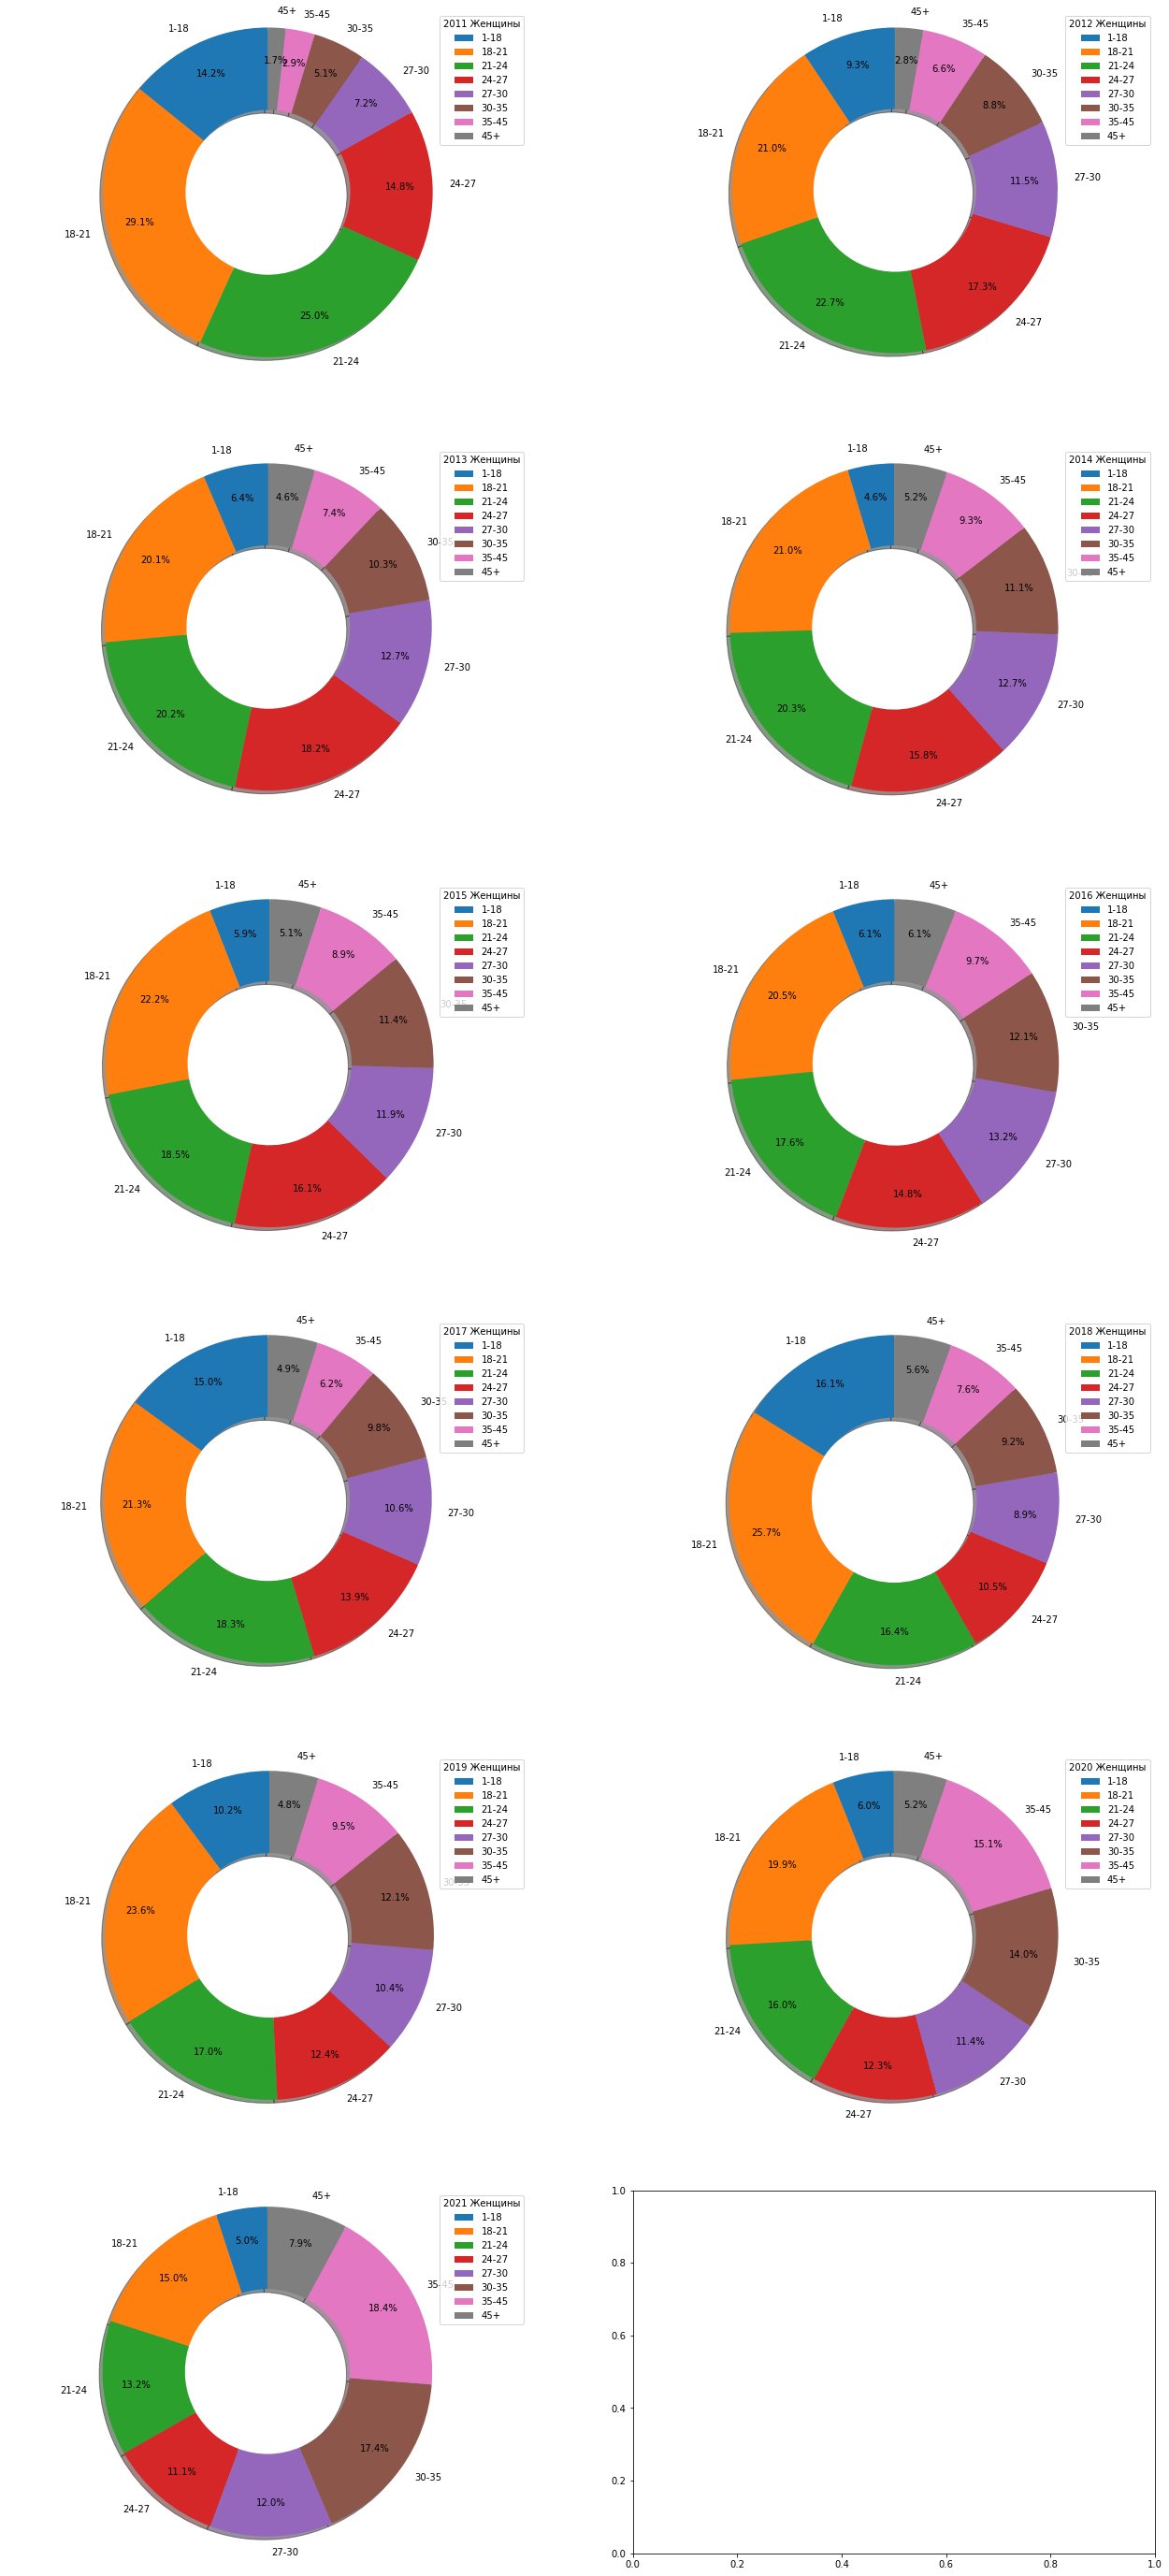

In [58]:
group_label = {"М":'Мужчины', 
               "Ж":'Женщины' 
            }

fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(22, 50));


#Рисуем круговые диаграммы для женщин
for y in vk_gage_pie['year'].unique():
    i,j = ax_dict[y]
    axes[i,j].pie(vk_gage_pie.query('year == @y & gender_age == "Ж"')['gage_value'],
        labels=vk_gage_pie['age_gender'].unique(),
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90,  
        wedgeprops={'width':0.5}, 
        pctdistance=0.8, 
        labeldistance=1.1)
    axes[i,j].legend(title = str(y) + " " + group_label["Ж"])
    axes[i,j].axis('equal')  
   

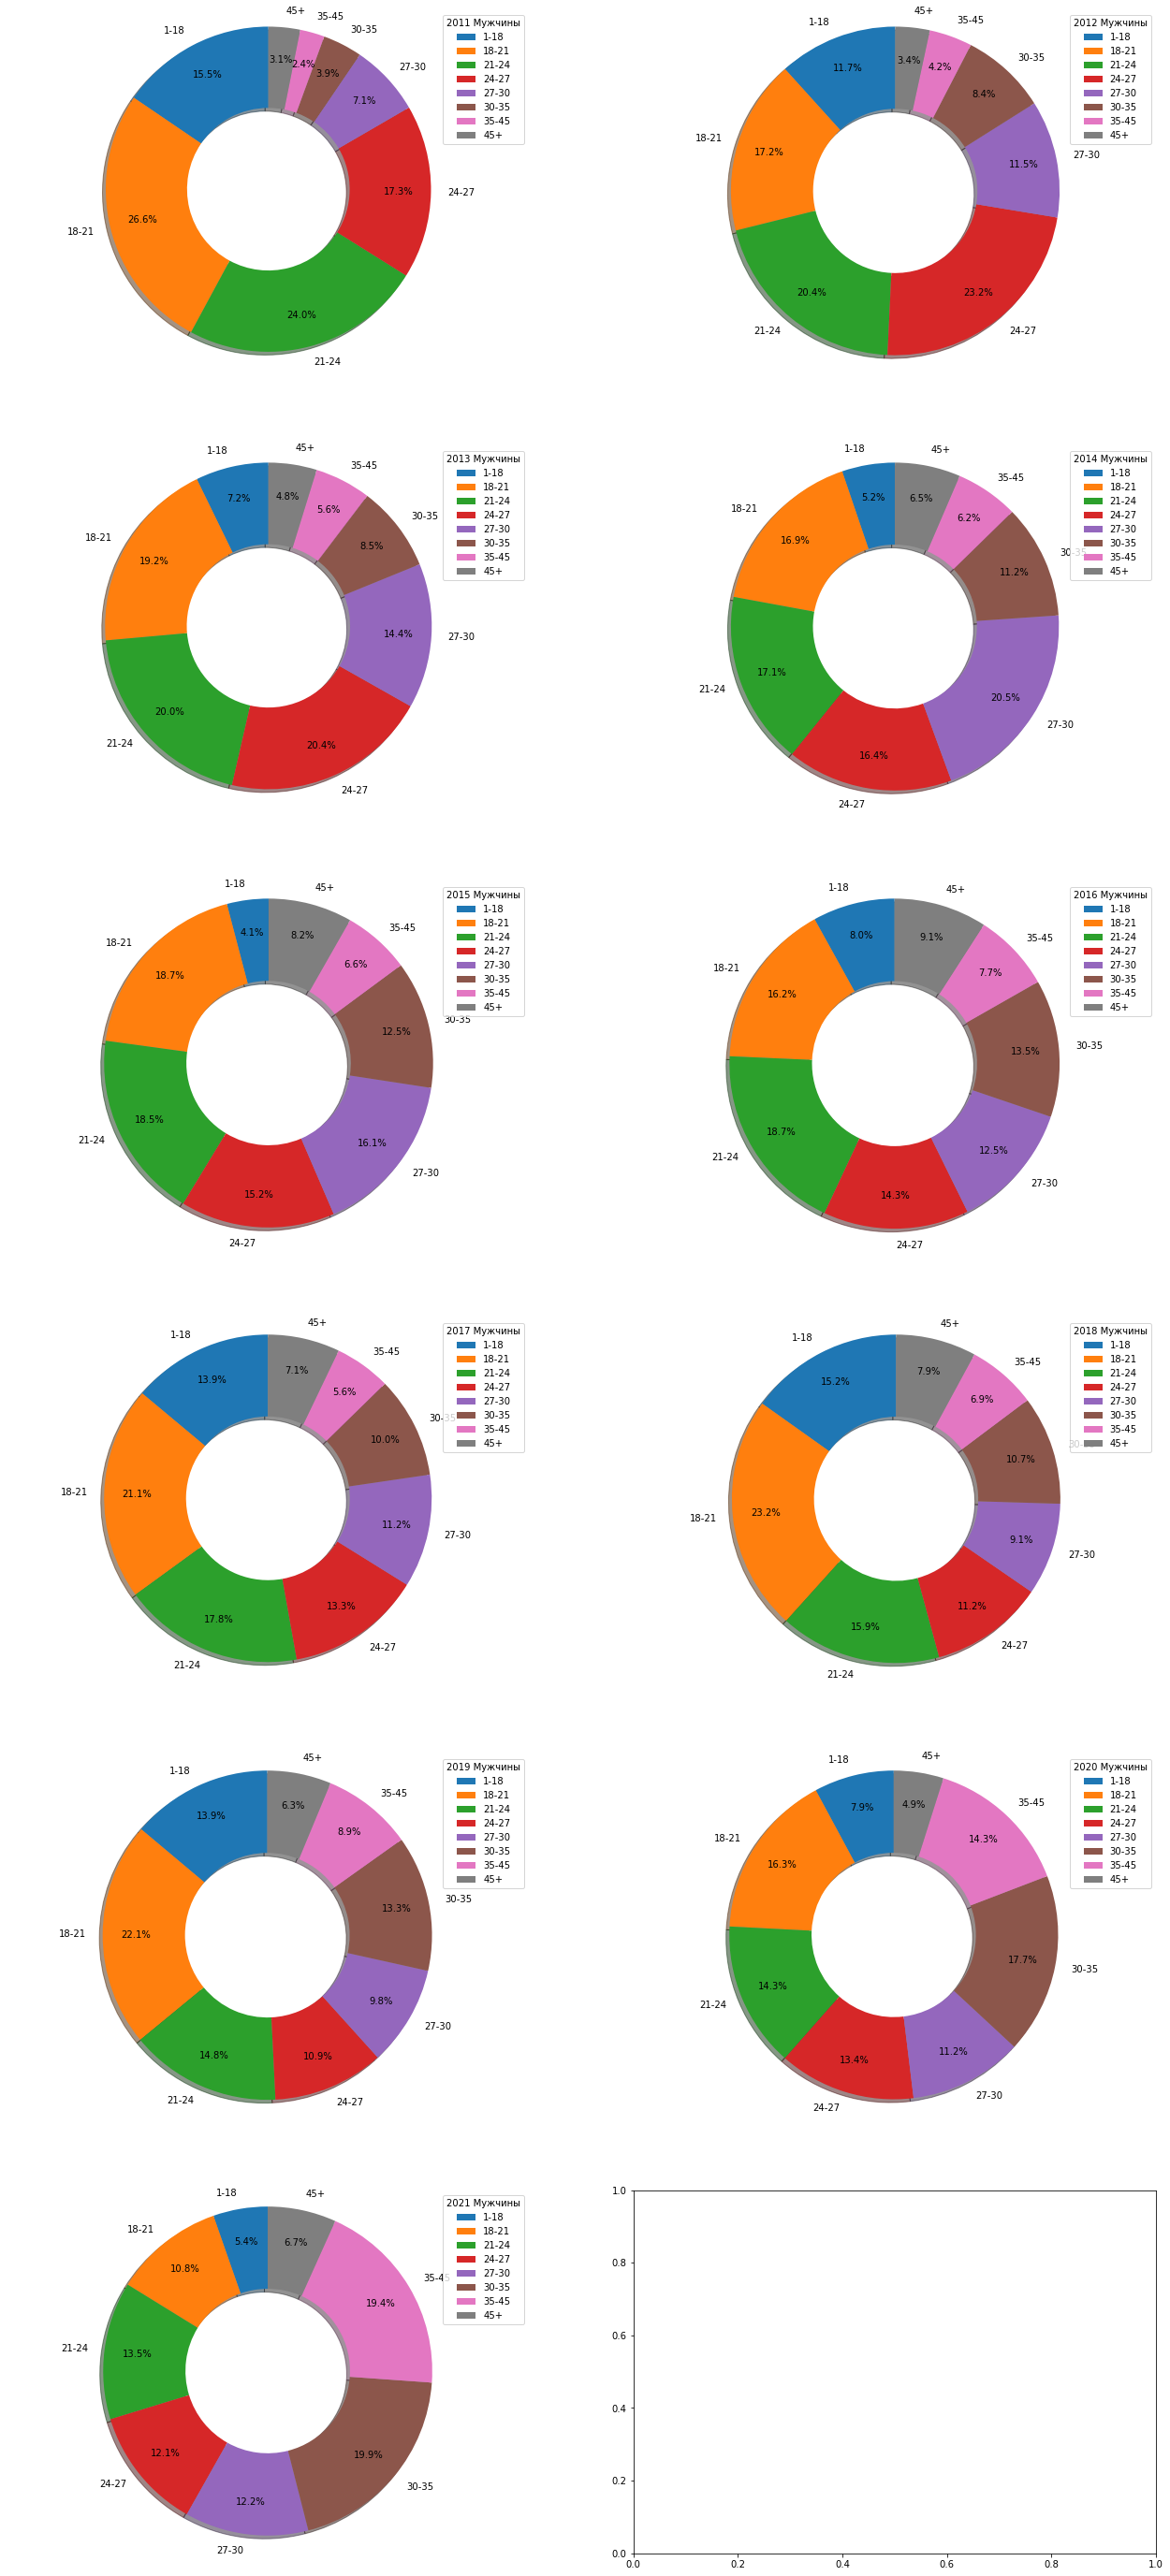

In [59]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(22, 50));

#Рисуем круговые диаграммы для мужчин
for y in vk_gage_pie['year'].unique():
    i,j = ax_dict[y]
    axes[i,j].pie(vk_gage_pie.query('year == @y & gender_age == "М"')['gage_value'],
        labels=vk_gage_pie['age_gender'].unique(),
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90,  
        wedgeprops={'width':0.5}, 
        pctdistance=0.8, 
        labeldistance=1.1)
    axes[i,j].legend(title = str(y) + " " + group_label["М"])
    axes[i,j].axis('equal')     

Построим столбчатые диаграммы

In [60]:
#Соберём таблицу возрастов для женщин
vk_gage_new_w = pd.pivot_table(vk_gage.query('gender_age == "Ж"'), 
                               index='date', columns='age_gender', 
                               values='gage_value').reset_index()
vk_gage_new_w['year'] = vk_gage_new_w['date'].dt.year
vk_gage_new_w['month'] = vk_gage_new_w['date'].dt.month
vk_gage_new_w['day'] = vk_gage_new_w['date'].dt.day
vk_gage_new_w.head()

age_gender       date  1-18  18-21  21-24  24-27  27-30  30-35  35-45  45+  \
0          2011-01-01   NaN    3.0    1.0    1.0    NaN    NaN    1.0  1.0   
1          2011-01-02   1.0    5.0    4.0    1.0    1.0    NaN    1.0  NaN   
2          2011-01-03   2.0    2.0    2.0    1.0    1.0    NaN    NaN  NaN   
3          2011-01-04   2.0    9.0    4.0    1.0    1.0    NaN    1.0  NaN   
4          2011-01-05   6.0   15.0   13.0    9.0    1.0    2.0    2.0  1.0   

age_gender  year  month  day  
0           2011      1    1  
1           2011      1    2  
2           2011      1    3  
3           2011      1    4  
4           2011      1    5

In [61]:
#Соберём таблицу возрастов для мужчин
vk_gage_new_m = pd.pivot_table(vk_gage.query('gender_age == "М"'), 
                              index='date', columns='age_gender', 
                               values='gage_value').reset_index()
vk_gage_new_m['year'] = vk_gage_new_m['date'].dt.year
vk_gage_new_m['month'] = vk_gage_new_m['date'].dt.month
vk_gage_new_m['day'] = vk_gage_new_m['date'].dt.day
vk_gage_new_m.head()

age_gender       date  1-18  18-21  21-24  24-27  27-30  30-35  35-45  45+  \
0          2011-01-01   NaN    1.0    6.0    3.0    NaN    NaN    NaN  NaN   
1          2011-01-02   1.0    2.0    7.0    3.0    NaN    1.0    1.0  NaN   
2          2011-01-03   2.0    7.0    1.0    5.0    NaN    NaN    2.0  NaN   
3          2011-01-04   5.0    5.0    7.0    4.0    1.0    NaN    1.0  NaN   
4          2011-01-05   NaN    6.0    8.0    9.0    1.0    NaN    2.0  NaN   

age_gender  year  month  day  
0           2011      1    1  
1           2011      1    2  
2           2011      1    3  
3           2011      1    4  
4           2011      1    5

In [62]:
#Сгруппируем таблицу по годам для построения графика для женщин
vk_gage_plot_w = (vk_gage_new_w.groupby('year')
.agg({'1-18':'sum', '18-21':'sum','21-24':'sum', '24-27':'sum','27-30':'sum','30-35':'sum', '35-45':'sum','45+':'sum'}))

#Вернём значения в целочисленный тип
vk_gage_plot_w = vk_gage_plot_w.astype('int64')

vk_gage_plot_w.style.background_gradient('coolwarm')

In [63]:
#Сгруппируем таблицу по годам для построения графика для мужчин
vk_gage_plot_m = (vk_gage_new_m.groupby('year')
.agg({'1-18':'sum', '18-21':'sum','21-24':'sum', '24-27':'sum','27-30':'sum','30-35':'sum','35-45':'sum','45+':'sum'}))

#Вернём значения в целочисленный тип
vk_gage_plot_m = vk_gage_plot_m.astype('int64')

vk_gage_plot_m.style.background_gradient('coolwarm')

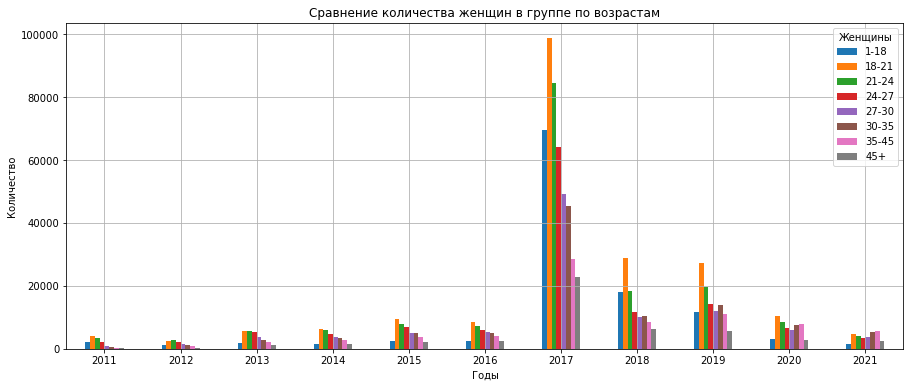

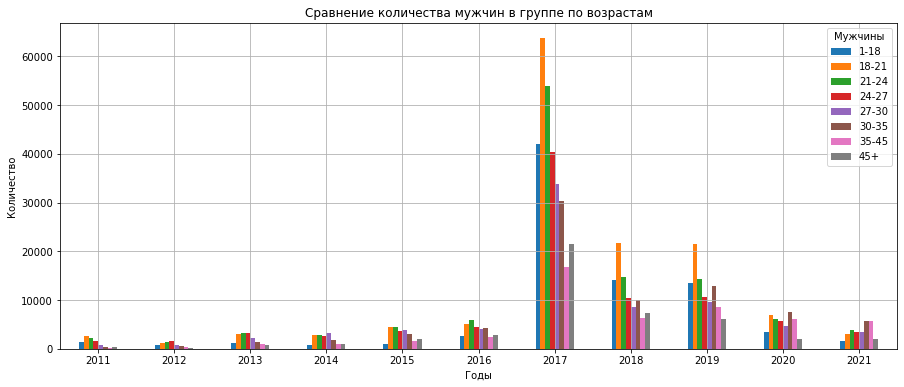

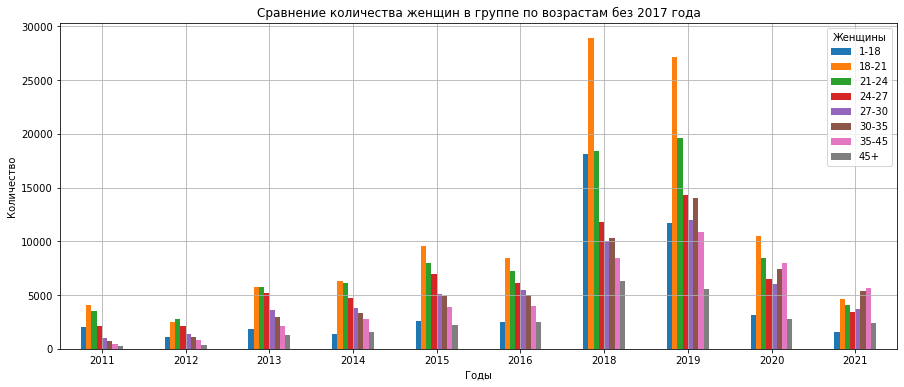

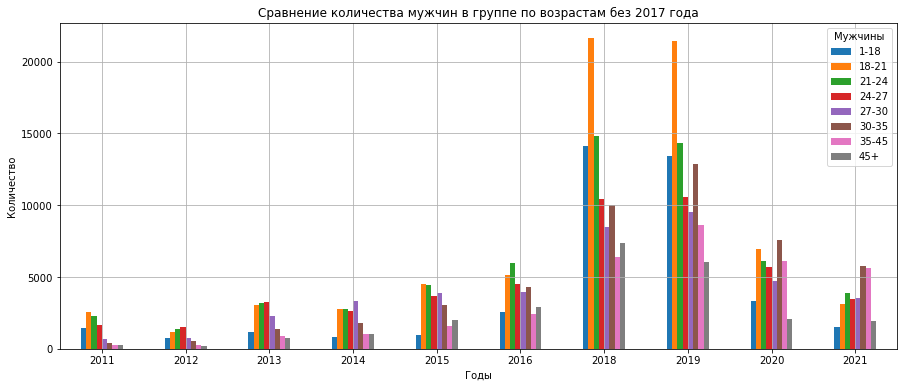

In [64]:
#Строим столбчатую диаграмму
yt = vk_gage_plot_w.reset_index().plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества женщин в группе по возрастам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
yt.legend(title = 'Женщины')
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt = vk_gage_plot_m.reset_index().plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин в группе по возрастам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
yt.legend(title = 'Мужчины')
plt.xticks(rotation=0)
plt.show()


#Строим столбчатую диаграмму
yt = vk_gage_plot_w.reset_index().query('year != 2017').plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества женщин в группе по возрастам без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
yt.legend(title = 'Женщины')
plt.xticks(rotation=0)
plt.show()


#Строим столбчатую диаграмму
yt = vk_gage_plot_m.reset_index().query('year != 2017').plot.bar(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин в группе по возрастам без 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
yt.legend(title = 'Мужчины')
plt.xticks(rotation=0)
plt.show()

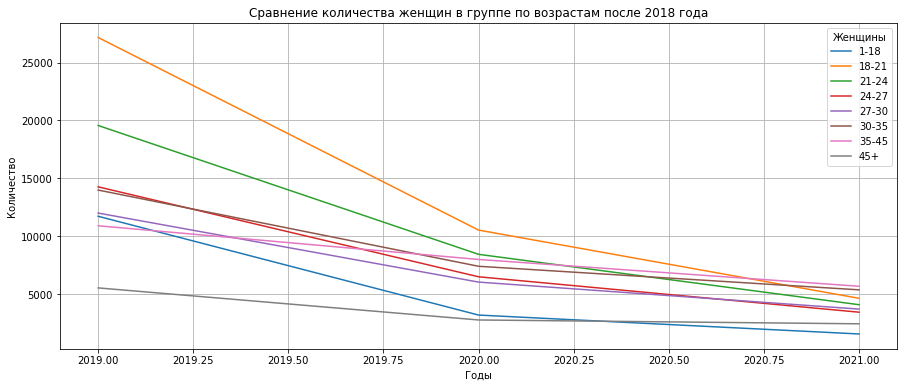

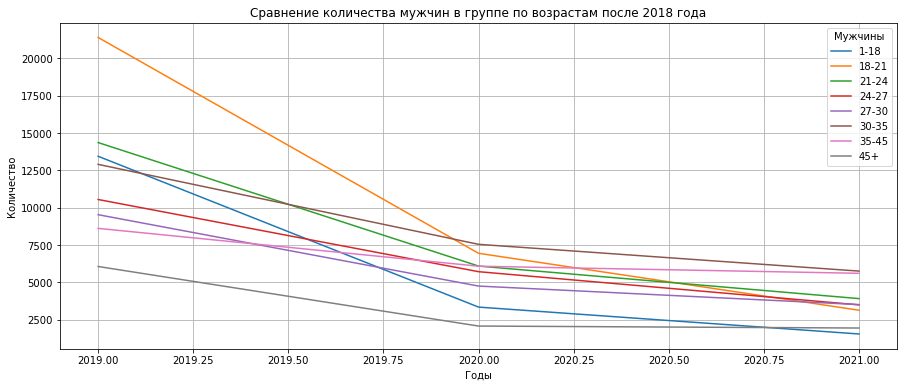

In [65]:
#Строим диаграмму
yt = vk_gage_plot_w.reset_index().query('year > 2018').plot(x='year',figsize=(15,6))
yt.set_title("Сравнение количества женщин в группе по возрастам после 2018 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
yt.legend(title = 'Женщины')
plt.xticks(rotation=0)
plt.show()


#Строим диаграмму
yt = vk_gage_plot_m.reset_index().query('year > 2018').plot(x='year',figsize=(15,6))
yt.set_title("Сравнение количества мужчин в группе по возрастам после 2018 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
yt.legend(title = 'Мужчины')
plt.xticks(rotation=0)
plt.show()

 **Выводы**


Общие тенденции и динамика состава группы сходны для мужчин и женщин. Однако удержание группы мужчин 30-45 лет всё же более ярко выражено среди мужчин, чем среди женщин. А вот женщины 18-21 года удерживатся значительно лучше аналогичной группы мужчин.

-----------------------------------------------

### Посмотрим срез по городам

In [66]:
vk_cit = vk_all.query('criterion == "cities"').copy()
vk_cit.info()
#Отрежем колонки criterion 
vk_cit = vk_cit.drop(['criterion', 'param_2'], axis=1)
#Переименуем колонку value в значение criterion
vk_cit = vk_cit.rename(columns={'param_1': 'cities', 'value': 'cit_value'})
vk_cit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99149 entries, 18 to 26115
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       99149 non-null  datetime64[ns]
 1   criterion  99149 non-null  object        
 2   param_1    99054 non-null  object        
 3   param_2    0 non-null      object        
 4   value      99149 non-null  int64         
 5   year       99149 non-null  int64         
 6   month      99149 non-null  int64         
 7   day        99149 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 6.8+ MB


date           cities  cit_value  year  month  day
18 2011-12-31           Казань          6  2011     12   31
19 2011-12-31           Москва          5  2011     12   31
20 2011-12-31        Череповец          1  2011     12   31
21 2011-12-31  Санкт-Петербург          1  2011     12   31
22 2011-12-31        Хабаровск          1  2011     12   31

In [67]:
#Создадим единый список городов с суммами участников по годам
vk_cit_gr = vk_cit.groupby(['year','cities']).agg({'cit_value':'sum'}).reset_index()
vk_cit_gr

year          cities  cit_value
0     2011   Adams Landing          1
1     2011  American Falls          1
2     2011       Amsterdam          2
3     2011         Antalya          1
4     2011            Arad          1
...    ...             ...        ...
7198  2021          Яровое          1
7199  2021       Ярославль        290
7200  2021          Ярцево          8
7201  2021      Ясиноватая          1
7202  2021          Яшалта          1

[7203 rows x 3 columns]

In [68]:
vk_cit.query('year == 2011 & cities == "Волгоград"')

date     cities  cit_value  year  month  day
159   2011-12-28  Волгоград          2  2011     12   28
218   2011-12-27  Волгоград          1  2011     12   27
481   2011-12-22  Волгоград          1  2011     12   22
596   2011-12-20  Волгоград          1  2011     12   20
854   2011-12-15  Волгоград          1  2011     12   15
...          ...        ...        ...   ...    ...  ...
17399 2011-02-06  Волгоград          9  2011      2    6
17463 2011-02-05  Волгоград          9  2011      2    5
18958 2011-01-08  Волгоград          1  2011      1    8
19044 2011-01-06  Волгоград          3  2011      1    6
19104 2011-01-05  Волгоград          1  2011      1    5

[82 rows x 6 columns]

In [69]:
#Посмотрим как выглядит топ 2011 года
vk_cit_2011 = vk_cit_gr.query('year == 2011').sort_values(by='cit_value', ascending=False).head(10)
vk_cit_2011.style.background_gradient('coolwarm')

In [70]:
#Соберём длинную таблицу из топ 10 городов по годам
vk_cit_list = []
for y in vk_cit_gr['year'].unique():
    vk_cit_y = vk_cit_gr.query('year == @y').sort_values(by='cit_value', ascending=False).head(10)
    vk_cit_list.append(vk_cit_y)
    
vk_cit_top = pd.concat(vk_cit_list)
vk_cit_top

year           cities  cit_value
671   2011  Санкт-Петербург       3584
511   2011           Москва       2703
337   2011           Казань       2676
365   2011             Киев        721
557   2011      Новосибирск        591
...    ...              ...        ...
6741  2021        Краснодар        597
7145  2021        Челябинск        551
6879  2021      Новосибирск        507
6750  2021       Красноярск        504
6547  2021        Волгоград        492

[110 rows x 3 columns]

In [71]:
top_list = vk_cit_top['cities'].unique()
top_list

array(['Санкт-Петербург', 'Москва', 'Казань', 'Киев', 'Новосибирск',
       'Уфа', 'Красноярск', 'Челябинск', 'Екатеринбург', 'Чебоксары',
       'Ярославль', 'Самара', 'Омск', 'Ростов-на-Дону', 'Краснодар',
       'Пермь', 'Нижний Новгород', 'Волгоград'], dtype=object)

In [72]:
vk_top_list = []
for cit in top_list:
    vk_cit_l = vk_cit.query('cities == @cit')
    vk_top_list.append(vk_cit_l)
    
vk_cit_top = pd.concat(vk_top_list)
vk_cit_top

date           cities  cit_value  year  month  day
21    2011-12-31  Санкт-Петербург          1  2011     12   31
54    2011-12-30  Санкт-Петербург          4  2011     12   30
101   2011-12-29  Санкт-Петербург          3  2011     12   29
154   2011-12-28  Санкт-Петербург          7  2011     12   28
203   2011-12-27  Санкт-Петербург         12  2011     12   27
...          ...              ...        ...   ...    ...  ...
25814 2021-01-05        Волгоград          2  2021      1    5
25878 2021-01-04        Волгоград          5  2021      1    4
25952 2021-01-03        Волгоград          3  2021      1    3
26036 2021-01-02        Волгоград          2  2021      1    2
26093 2021-01-01        Волгоград          5  2021      1    1

[45110 rows x 6 columns]

In [73]:
vk_cit_top_sum = vk_cit_top.groupby(['year', 'cities']).agg({'cit_value':'sum'}).reset_index()
vk_cit_top_sum

year           cities  cit_value
0    2011        Волгоград        159
1    2011     Екатеринбург        364
2    2011           Казань       2676
3    2011             Киев        721
4    2011        Краснодар        169
..    ...              ...        ...
193  2021  Санкт-Петербург       5084
194  2021              Уфа        270
195  2021        Чебоксары         76
196  2021        Челябинск        551
197  2021        Ярославль        290

[198 rows x 3 columns]

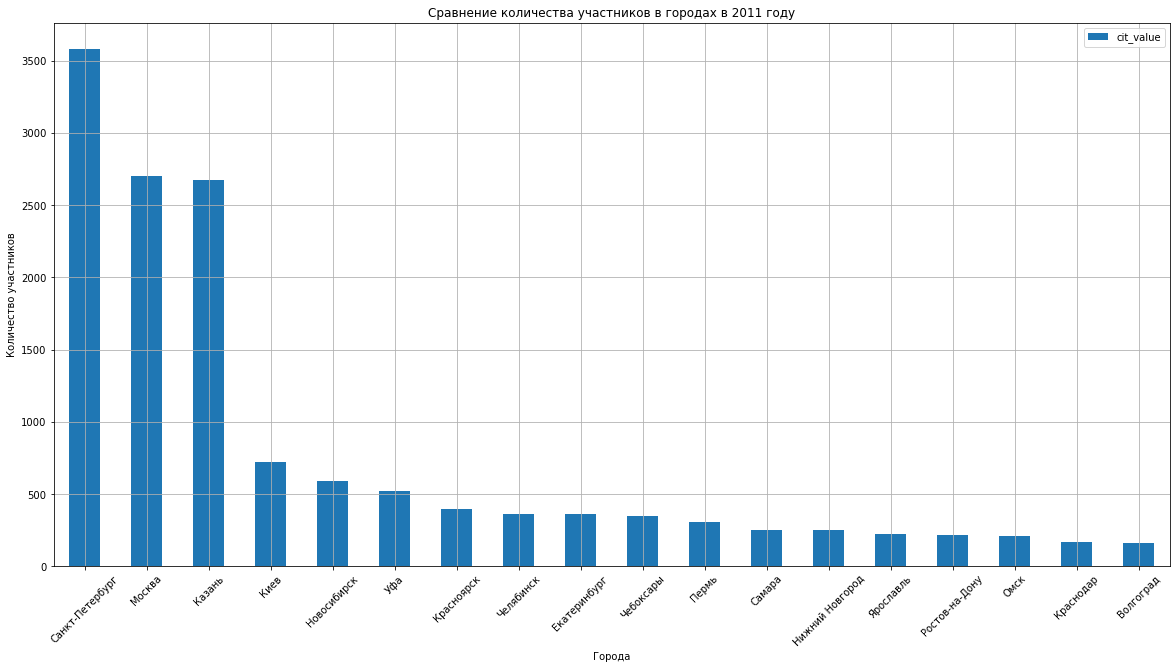

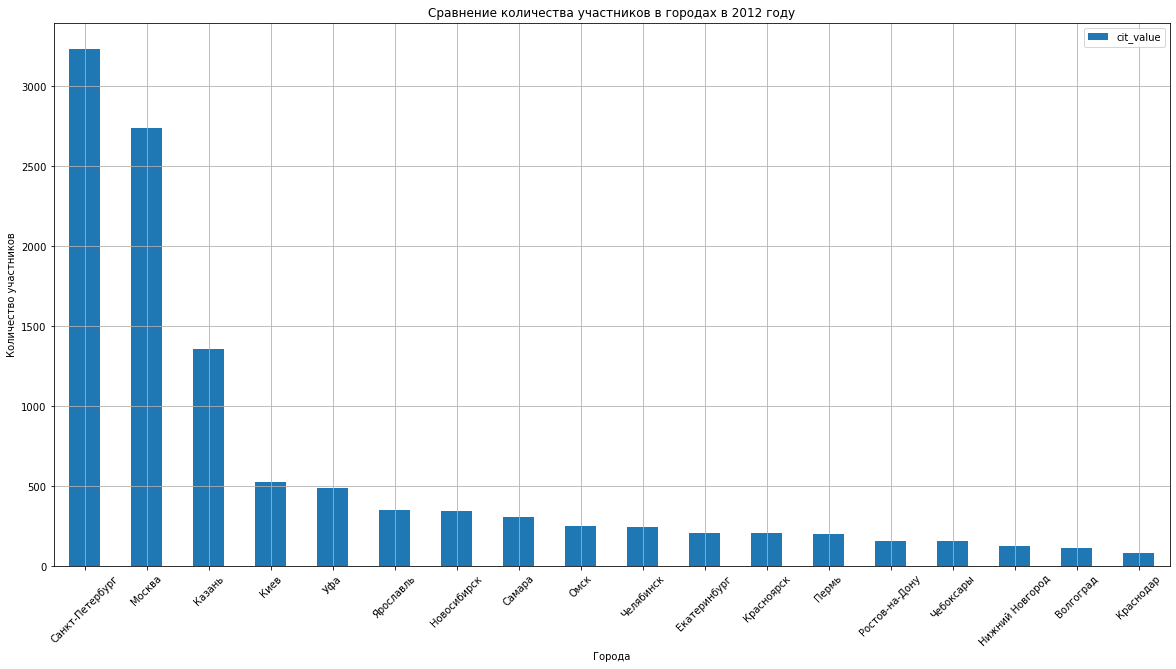

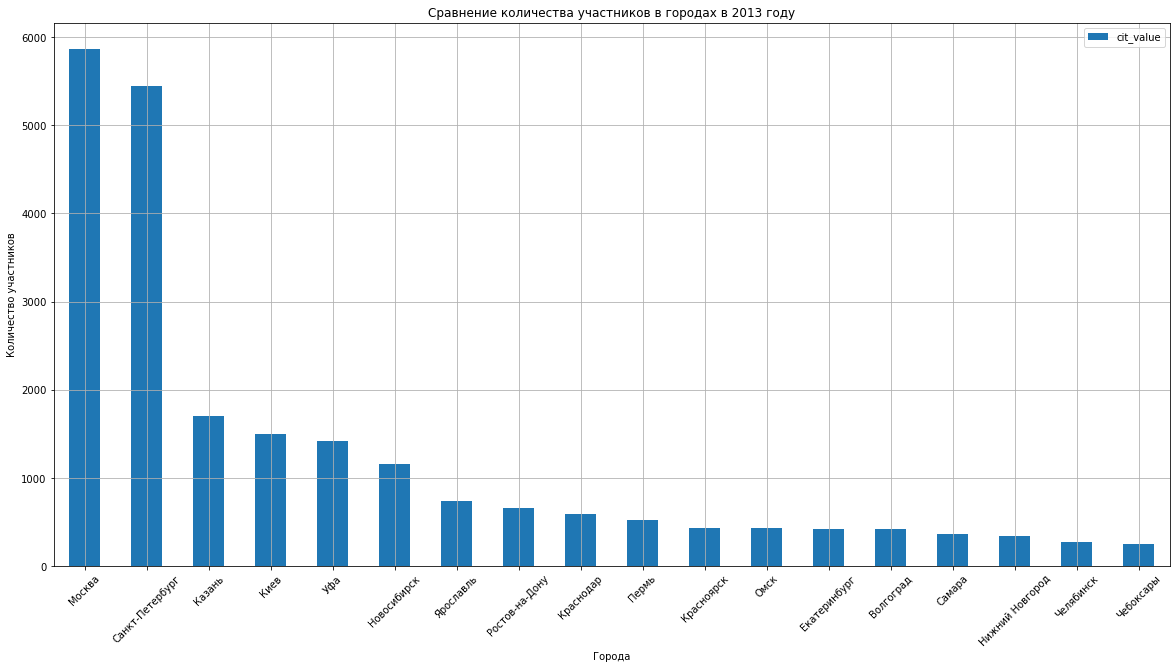

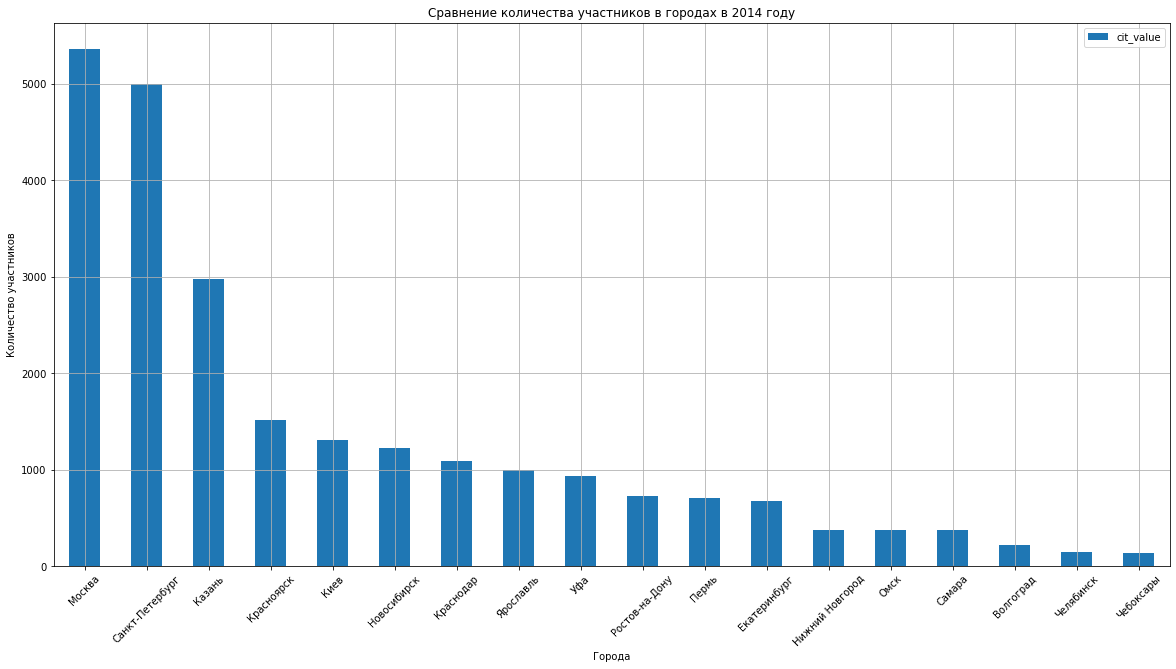

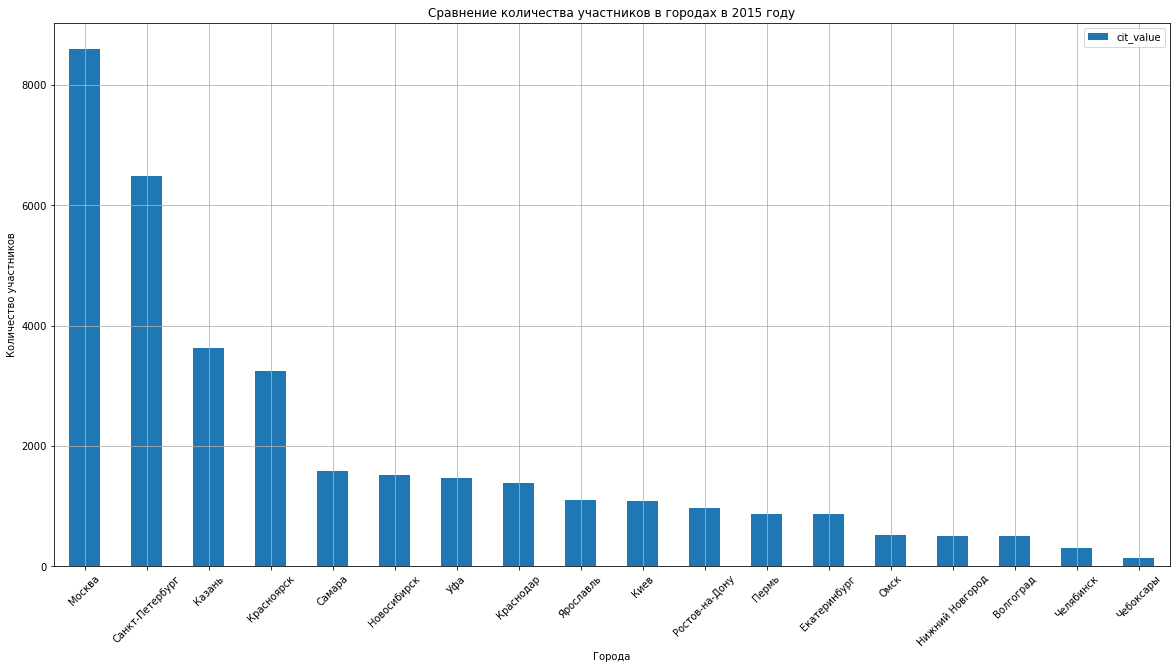

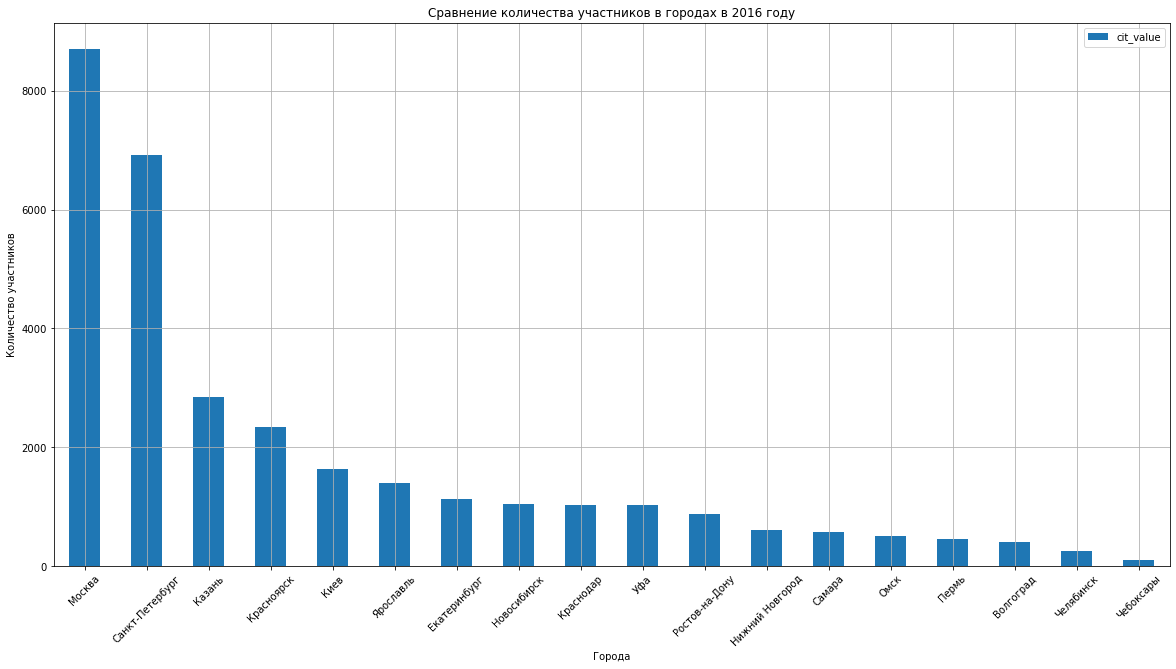

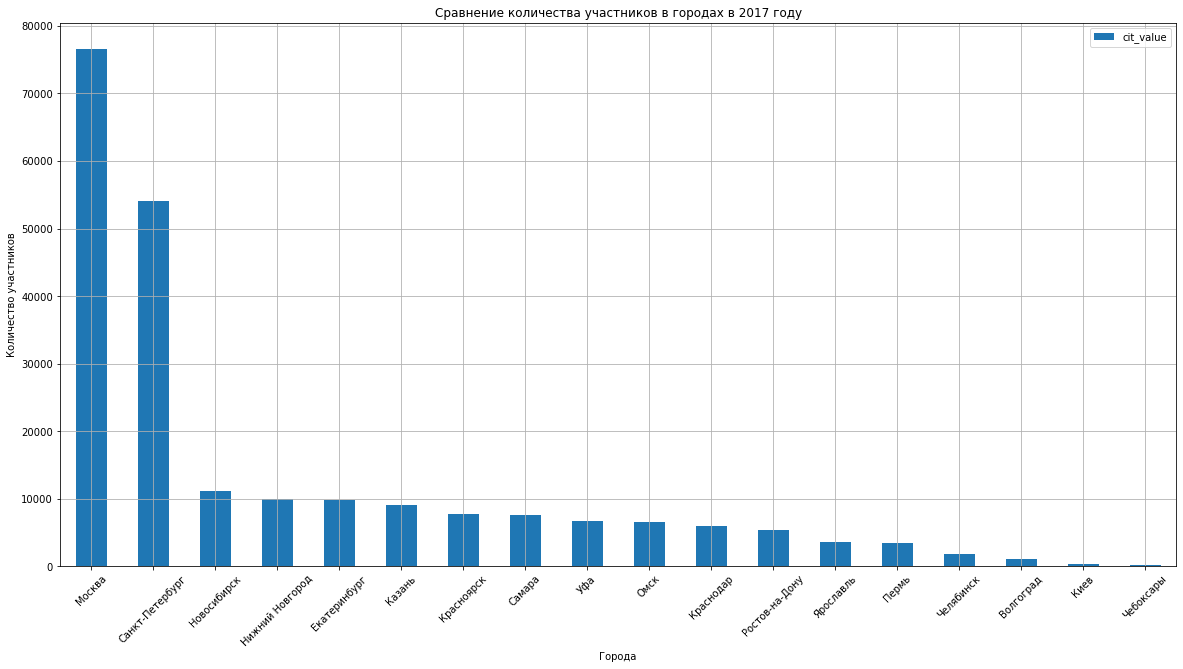

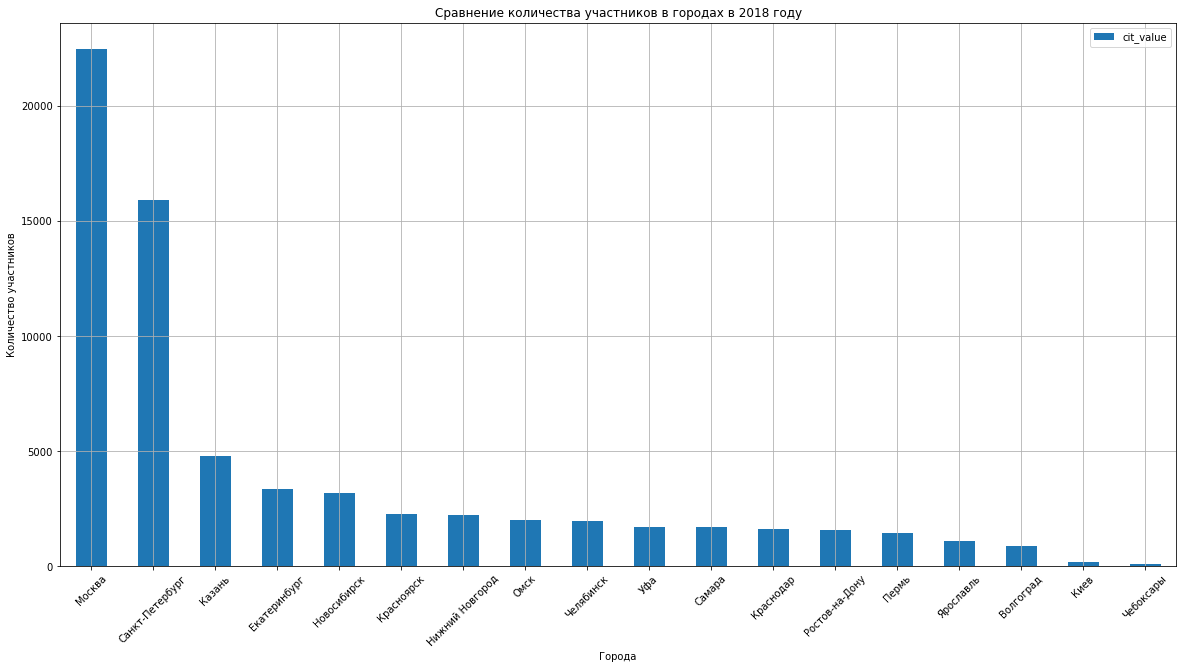

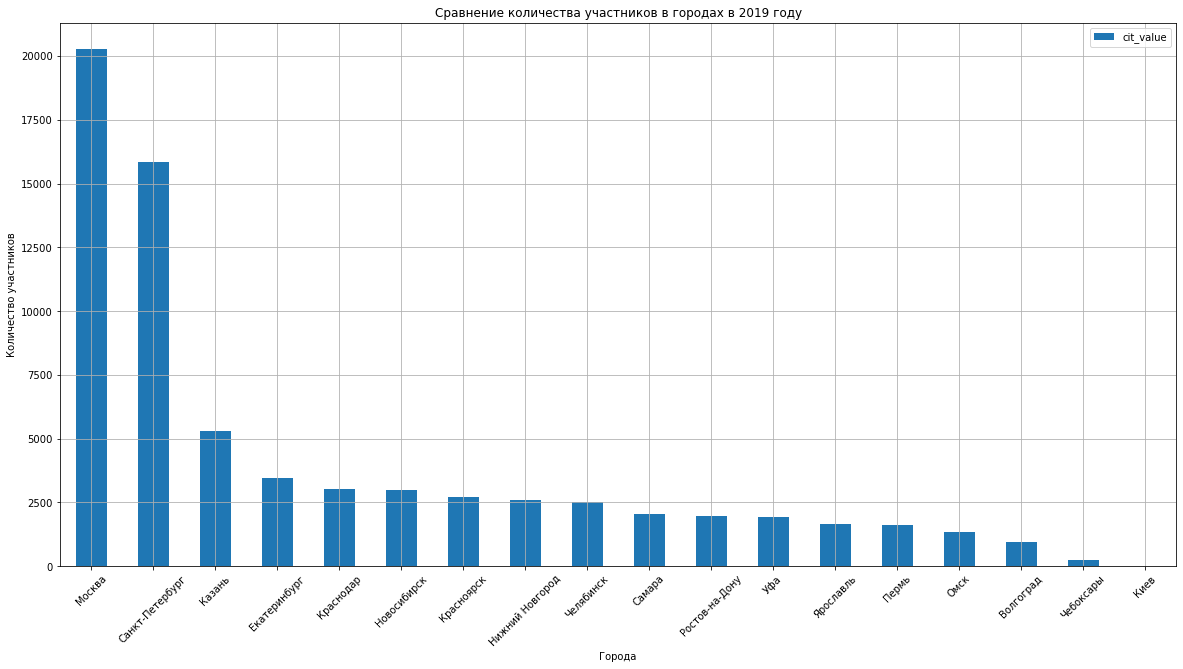

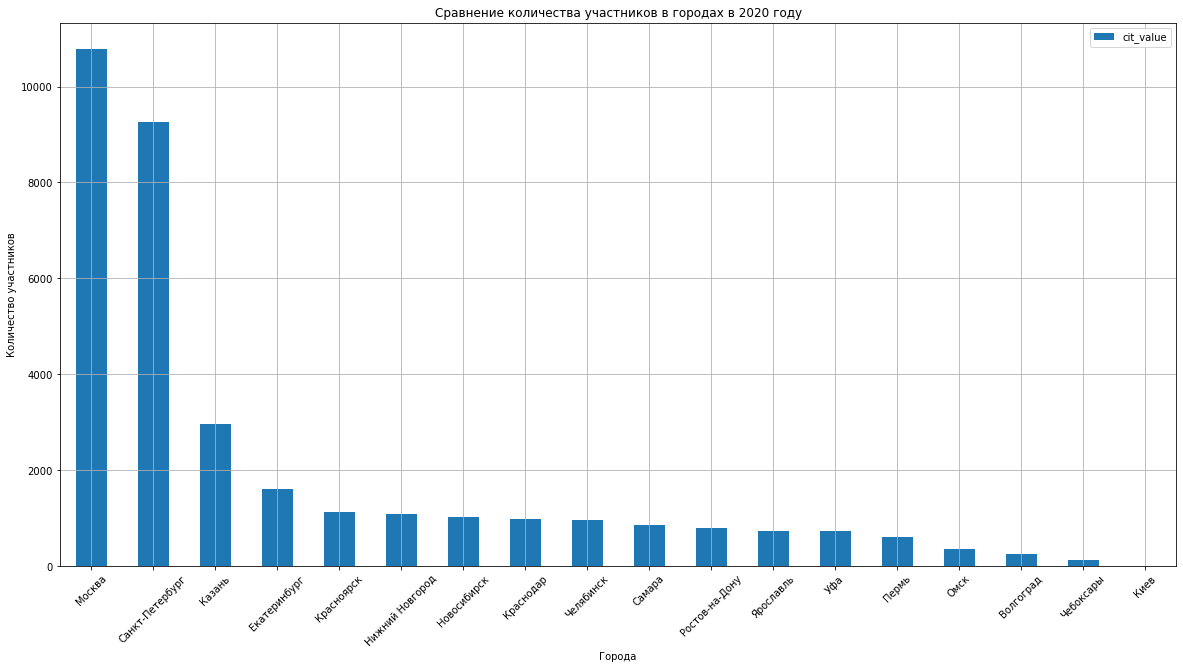

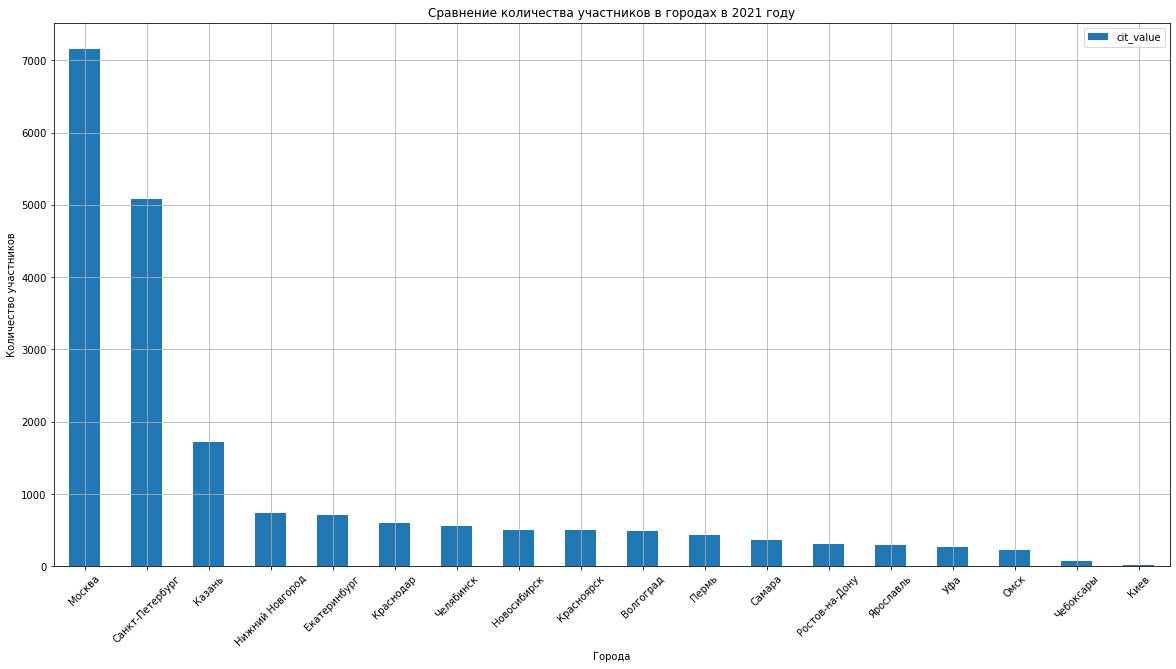

In [74]:
for y in vk_cit_top_sum.year.unique():
    #Строим столбчатую диаграмму
    yt =vk_cit_top_sum.query('year == @y').sort_values(by='cit_value', ascending=False).plot.bar(y='cit_value', x='cities',figsize=(20,10))
    yt.set_title(f'Сравнение количества участников в городах в {y} году')
    yt.set_xlabel('Города')
    yt.set_ylabel('Количество участников')
    yt.axes.grid()
    plt.xticks(rotation=45)
    plt.show()


In [75]:
vk_cit_top_sum

year           cities  cit_value
0    2011        Волгоград        159
1    2011     Екатеринбург        364
2    2011           Казань       2676
3    2011             Киев        721
4    2011        Краснодар        169
..    ...              ...        ...
193  2021  Санкт-Петербург       5084
194  2021              Уфа        270
195  2021        Чебоксары         76
196  2021        Челябинск        551
197  2021        Ярославль        290

[198 rows x 3 columns]

In [76]:
#Собираем таблицу топ 10 городов за каждый год
vk_cit_top_mean = pd.pivot_table(vk_cit_top_sum, index=['cities'], values='cit_value', aggfunc='sum')
vk_cit_top_mean.sort_values(by='cit_value', ascending=False).style.background_gradient('coolwarm')

In [77]:
#Собираем таблицу топ 10 городов за каждый год
vk_cit_top_plot = pd.pivot_table(vk_cit_top, index='year', columns='cities', values='cit_value', aggfunc='sum')
vk_cit_top_plot.style.background_gradient('coolwarm')

In [78]:
bar_label = vk_cit_top_plot.columns
bar_label

Index(['Волгоград', 'Екатеринбург', 'Казань', 'Киев', 'Краснодар',
       'Красноярск', 'Москва', 'Нижний Новгород', 'Новосибирск', 'Омск',
       'Пермь', 'Ростов-на-Дону', 'Самара', 'Санкт-Петербург', 'Уфа',
       'Чебоксары', 'Челябинск', 'Ярославль'],
      dtype='object', name='cities')

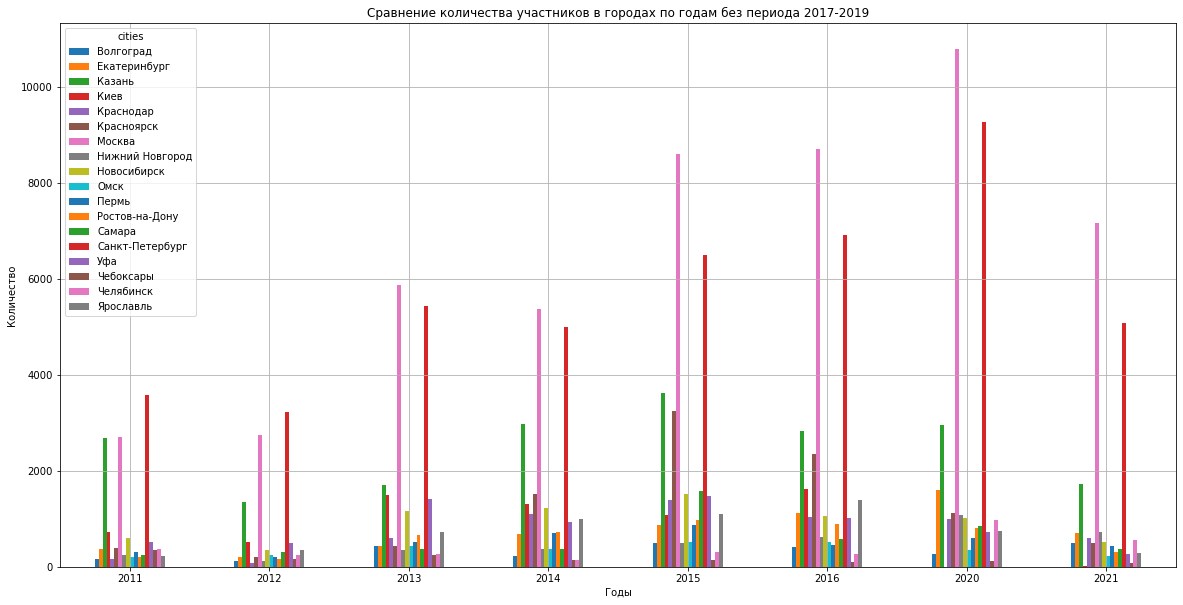

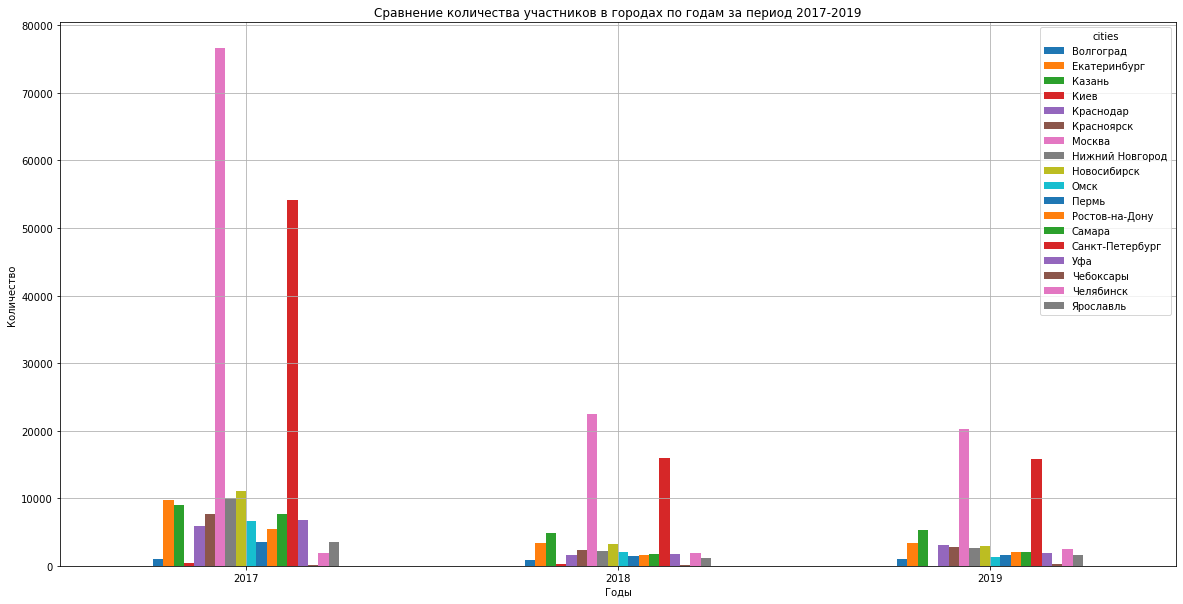

In [79]:
bar_label = vk_cit_top_plot.columns
#Строим столбчатую диаграмму
yt =vk_cit_top_plot.query('(year < 2017) or (year > 2019)').plot.bar(figsize=(20,10))
yt.set_title("Сравнение количества участников в городах по годам без периода 2017-2019")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()



#Строим столбчатую диаграмму
yt =vk_cit_top_plot.query('(year > 2016) & (year < 2020)').plot.bar(figsize=(20,10))
yt.set_title("Сравнение количества участников в городах по годам за период 2017-2019")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

In [80]:
cities.head()

id             region           municipality  settlement type  population  \
0   0  Орловская область             Болховский  Колонтаева    д           0   
1   1    Республика Крым                 Алушта     Пушкино    с         273   
2   2   Липецкая область  Лев-Толстовский район    Барятино    с           7   
3   3   Тверская область    Селижаровский район      Хилово    д           2   
4   4    Томская область     Парабельский район   Басмасово    д           6   

   children latitude_dms longitude_dms  latitude_dd  longitude_dd  \
0         0     53.22.07     035.54.36    53.368611     35.910000   
1         0     44.35.45     034.20.27    44.595833     34.340833   
2         1     53.15.46     039.30.14    53.262778     39.503889   
3         0     56.54.20     033.25.09    56.905556     33.419167   
4         0     58.38.12     082.02.40    58.636667     82.044444   

          oktmo  dadata  rosstat  
0  5.460442e+10       0        1  
1  3.570300e+10       0        1  
2  4.263641e+10       0        1  
3  2.865043e+10       0        1  
4  6.964444e+10       0        1

In [81]:
#Соберём таблицу из городов попавших в топ за какой либо год
cit_list = []
for c in top_list:
    cit = cities.query('settlement == @c')
    cit_list.append(cit)

cit_top = pd.concat(cit_list)

cit_top    

id                 region       municipality       settlement  \
10779    10779        Санкт-Петербург        Фрунзенский  Санкт-Петербург   
20559    20559        Санкт-Петербург         Московский  Санкт-Петербург   
29342    29342        Санкт-Петербург         Приморский  Санкт-Петербург   
43330    43330        Санкт-Петербург        Калининский  Санкт-Петербург   
52329    52329        Санкт-Петербург      Петроградский  Санкт-Петербург   
...        ...                    ...                ...              ...   
64535    64535     Краснодарский край    Город Краснодар        Краснодар   
78430    78430    Воронежская область  Богучарский район        Краснодар   
98152    98152          Пермский край              Пермь            Пермь   
98058    98058  Нижегородская область    Нижний Новгород  Нижний Новгород   
144090  144090  Волгоградская область    Город Волгоград        Волгоград   

       type  population  children latitude_dms longitude_dms  latitude_dd  \
10779     г      405308     62038     59.56.21     030.18.57    59.939167   
20559     г      337153     51536     59.56.21     030.18.57    59.939167   
29342     г      549774     85749     59.56.21     030.18.57    59.939167   
43330     г      530163     79678     59.56.21     030.18.57    59.939167   
52329     г      136613     18351     59.56.21     030.18.57    59.939167   
...     ...         ...       ...          ...           ...          ...   
64535     г      987828    190320     45.02.25     038.58.34    45.040278   
78430     х          90        27     49.53.45     040.14.33    49.895833   
98152     г     1048011    206573     58.00.37     056.14.03    58.010278   
98058     г     1276560    215400     56.19.37     044.00.22    56.326944   
144090    г     1030400    190092     48.42.38     044.31.00    48.710556   

        longitude_dd         oktmo  dadata  rosstat  
10779      30.315833  4.000000e+07       1        0  
20559      30.315833  4.000000e+07       1        0  
29342      30.315833  4.000000e+07       1        0  
43330      30.315833  4.000000e+07       1        0  
52329      30.315833  4.000000e+07       1        0  
...              ...           ...     ...      ...  
64535      38.976111  3.701000e+09       0        1  
78430      40.242500  2.060542e+10       0        1  
98152      56.234167  5.770100e+10       1        0  
98058      44.006111  2.270100e+07       1        0  
144090     44.516667  1.870100e+10       1        0  

[63 rows x 14 columns]

In [82]:
#Проверим сходится ли сумма в таблице с зарегистрированным населеннием города 
cities.query('settlement == "Москва"').groupby('settlement').agg({'population':'sum'})

population
settlement            
Москва        12380691

In [83]:
#Собираем таблицу топ 10 городов за каждый год
cit_pop = pd.pivot_table(cit_top,  columns='settlement', values='population', aggfunc='sum')

#Население Уфы и Киева возьмём вручную из открытых источников, поскольку в датасете этих данных нет
cit_pop['Уфа'] = cit_pop['Уфа'].replace(66,1125933)
cit_pop.insert(3, "Киев", 2954564)

cit_pop

settlement  Волгоград  Екатеринбург   Казань     Киев  Краснодар  Красноярск  \
population    1030400       1515832  1205655  2954564     987918     1067030   

settlement    Москва  Нижний Новгород  Новосибирск     Омск    Пермь  \
population  12380691          1276560      1618039  1178391  1048011   

settlement  Ростов-на-Дону   Самара  Санкт-Петербург      Уфа  Чебоксары  \
population         1125299  1157505          5225690  1125933     492428   

settlement  Челябинск  Ярославль  
population    1134643     604128

In [84]:
#Поделим столбцы таблицы на населения соответствующих городов 
vk_cit_rate = pd.concat([vk_cit_top_plot,cit_pop])
for i in vk_cit_rate.columns:
      vk_cit_rate[i] = vk_cit_rate[i] / vk_cit_rate[i]['population']
vk_cit_rate = vk_cit_rate.drop(['population'], axis=0)
vk_cit_rate.style.background_gradient('coolwarm')  

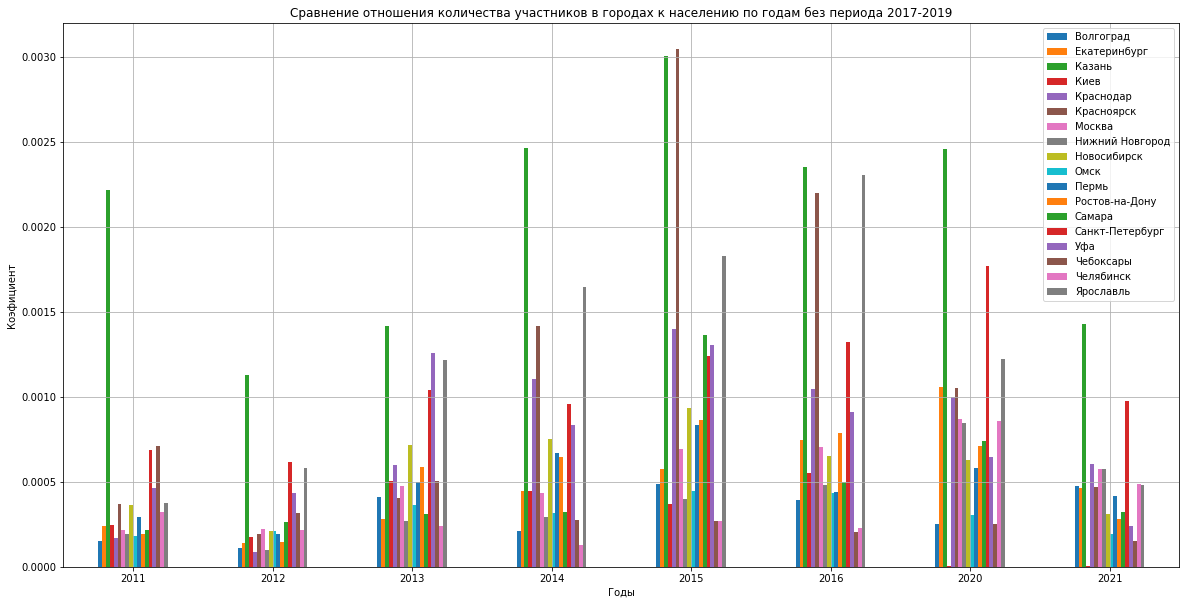

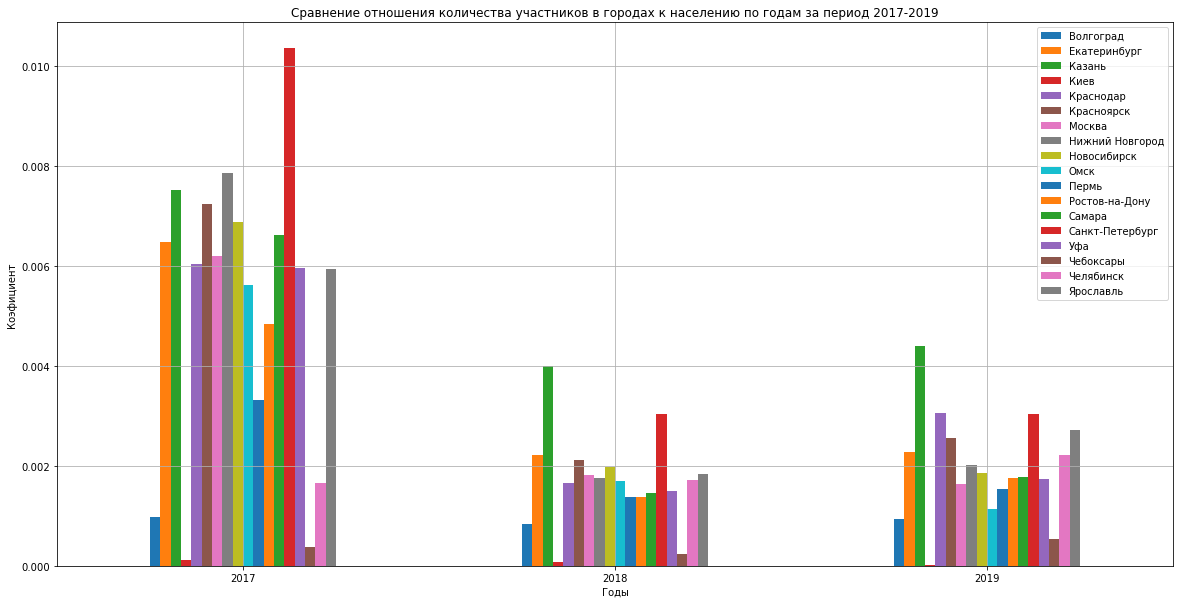

In [85]:
#Строим столбчатую диаграмму
yt =vk_cit_rate.query('(index < 2017) or (index > 2019)').plot.bar(figsize=(20,10))
yt.set_title("Сравнение отношения количества участников в городах к населению по годам без периода 2017-2019")
yt.set_xlabel('Годы')
yt.set_ylabel('Коэфициент')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt =vk_cit_rate.query('(index > 2016) & (index < 2020)').plot.bar(figsize=(20,10))
yt.set_title("Сравнение отношения количества участников в городах к населению по годам за период 2017-2019")
yt.set_xlabel('Годы')
yt.set_ylabel('Коэфициент')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

Нарисуем карты, воспользовавшись кодом из предыдущих проектов. (Оказалось бесполезно, но местами кросивое)

In [86]:
#запишем полученный ключ для геокодера
#key = '9bbdd575-786d-4647-aeed-98118ee28f44'
key = '8bee1db3-7fad-40ab-bb2a-58d12ae96052'
#key = '829464d8-67b4-4ca7-9b1a-160802a4efe0'

#зададим параметры запроса, чтобы получать в ответ на запрос json - файл
params = { # словарь с параметрами запроса
        "format" : "json", # определяем формат ответа на запрос
    }

In [87]:
#зададим функцию, которая на вход будет получать адрес и возвращать район
def mapmaker(address):
    
    #создадим url для запроса координат
    url = 'https://geocode-maps.yandex.ru/1.x/?apikey=' + key + '&geocode=' + address
    
    #сделаем запрос к геокодеру
    response = requests.get(url, params = params)

    #получим координаты точки
    try:
        coord = json.loads(response.text)['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
    except:
        coord = 'Не определен'
        
    #создадим url для запроса по координатам
    url_coord = 'https://geocode-maps.yandex.ru/1.x/?apikey=' + key + '&geocode=' + coord
    
    #делаем запрос по координатам
    response_coord = requests.get(url_coord, params = params)
    
    #получаем район из результатов запроса
#    try:
#        district = json.loads(response_coord.text)['response']['GeoObjectCollection']['featureMember'][2]['GeoObject']['metaDataProperty']['GeocoderMetaData']['AddressDetails']['Country']['AdministrativeArea']['Locality']['DependentLocality']['DependentLocality']['DependentLocalityName']
#    except:
#        district = 'Не определен'

    return(coord)

In [88]:
#Пример работы функции mapmaker
mapmaker('Москва')

'37.617698 55.755864'

In [89]:
#Расчитаем среднее соотношение участников к населению по городам
cit_mean= []
for i in vk_cit_rate.columns:
    cit_mean.append(vk_cit_rate[i].mean())
cit_mean

[0.00047845496894409934,
 0.0013547315629604433,
 0.0029437035545748238,
 0.00022695242159095368,
 0.0015242339767249729,
 0.001916023490862062,
 0.001258161526760428,
 0.0013447361374603337,
 0.0013891113648288847,
 0.000991104897193793,
 0.000921919539185961,
 0.001107907562991945,
 0.0012622761103329222,
 0.002276358807075325,
 0.0013897161489424973,
 0.0003492896423436523,
 0.0007588289885012291,
 0.0018319416956791817]

In [90]:
#Соберём таблицу с городами и соотношениями, выстроим в порядке убывания
data = {'city': vk_cit_rate.columns, 'rate': cit_mean} 
cit_map = pd.DataFrame(data)
cit_map_plot = cit_map.sort_values(by='rate', ascending=False)
cit_map_plot.style.background_gradient('coolwarm')

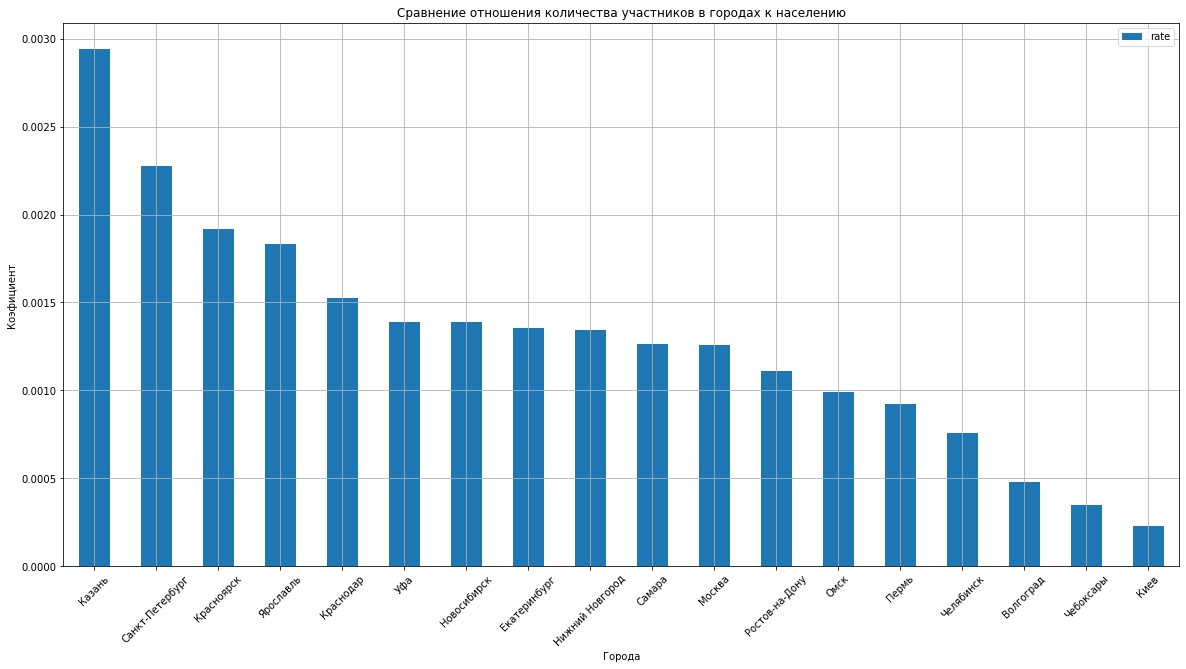

In [91]:
#Строим столбчатую диаграмму
yt =cit_map_plot.plot.bar(x='city', y='rate',figsize=(20,10))
yt.set_title("Сравнение отношения количества участников в городах к населению")
yt.set_xlabel('Города')
yt.set_ylabel('Коэфициент')
yt.axes.grid()
plt.xticks(rotation=45)
plt.show()

In [92]:
#Используем mapmaker, чтобы найти точные координаты центров городов из топ 10 
cit_map['info'] = cit_map['city'].apply(mapmaker)
cit_map

city      rate                 info
0         Волгоград  0.000478  44.516975 48.707067
1      Екатеринбург  0.001355  60.597474 56.838011
2            Казань  0.002944  49.106414 55.796127
3              Киев  0.000227   30.52355 50.450441
4         Краснодар  0.001524   38.975313 45.03547
5        Красноярск  0.001916  92.852572 56.010569
6            Москва  0.001258  37.617698 55.755864
7   Нижний Новгород  0.001345  44.006516 56.326797
8       Новосибирск  0.001389   82.92043 55.030204
9              Омск  0.000991  73.368221 54.989347
10            Пермь  0.000922  56.229443 58.010455
11   Ростов-на-Дону  0.001108  39.720358 47.222078
12           Самара  0.001262  50.100202 53.195878
13  Санкт-Петербург  0.002276  30.315644 59.938955
14              Уфа  0.001390  55.958736 54.735152
15        Чебоксары  0.000349  47.247728 56.139918
16        Челябинск  0.000759  61.402554 55.159902
17        Ярославль  0.001832  39.893813 57.626559

In [93]:
#Разделим координаты на две колонки - широта и долгота
coord_geo = cit_map['info'].str.split(' ',expand=True)
coord_geo.columns=['geo_lon','geo_lat']
coord_geo.head()

geo_lon    geo_lat
0  44.516975  48.707067
1  60.597474  56.838011
2  49.106414  55.796127
3   30.52355  50.450441
4  38.975313   45.03547

In [94]:
#Соберём таблицу в нужном виде
cit_map = pd.concat([cit_map[['city','rate']], coord_geo], axis=1)
cit_map.head()

city      rate    geo_lon    geo_lat
0     Волгоград  0.000478  44.516975  48.707067
1  Екатеринбург  0.001355  60.597474  56.838011
2        Казань  0.002944  49.106414  55.796127
3          Киев  0.000227   30.52355  50.450441
4     Краснодар  0.001524  38.975313   45.03547

In [95]:
#Переведём колонки с координатами в численный тип со сбросом нечисловых значений в NaN
cit_map['geo_lon'] = pd.to_numeric(cit_map['geo_lon'], errors='coerce')
cit_map['geo_lat'] = pd.to_numeric(cit_map['geo_lat'], errors='coerce')
cit_map

city      rate    geo_lon    geo_lat
0         Волгоград  0.000478  44.516975  48.707067
1      Екатеринбург  0.001355  60.597474  56.838011
2            Казань  0.002944  49.106414  55.796127
3              Киев  0.000227  30.523550  50.450441
4         Краснодар  0.001524  38.975313  45.035470
5        Красноярск  0.001916  92.852572  56.010569
6            Москва  0.001258  37.617698  55.755864
7   Нижний Новгород  0.001345  44.006516  56.326797
8       Новосибирск  0.001389  82.920430  55.030204
9              Омск  0.000991  73.368221  54.989347
10            Пермь  0.000922  56.229443  58.010455
11   Ростов-на-Дону  0.001108  39.720358  47.222078
12           Самара  0.001262  50.100202  53.195878
13  Санкт-Петербург  0.002276  30.315644  59.938955
14              Уфа  0.001390  55.958736  54.735152
15        Чебоксары  0.000349  47.247728  56.139918
16        Челябинск  0.000759  61.402554  55.159902
17        Ярославль  0.001832  39.893813  57.626559

Рисуем карту

In [96]:
#Задаём координаты для распределения точек на карте
fig = go.Figure(go.Scattermapbox(lat=cit_map['geo_lat'], lon=cit_map['geo_lon'], \
                                 text=cit_map['city'], 
                                 marker=dict(size=cit_map['rate'])))
fig = go.Figure()

#Создадим интерактивную легенду 
for group in cit_map['city'].unique():

    obj_group = cit_map[cit_map['city'] == group]

    fig.add_trace(
        go.Scattermapbox(
            lat=obj_group['geo_lat'], lon=obj_group['geo_lon'], text=obj_group['city'], name=group
        )
    )

#Определяем центр карты
map_center = {'lat': 55.753220, 'lon': 37.622513}

#Рисуем карту
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=2),\
                  title = 'Топ городов по количеству участников группы')

#Рисуем легенду
fig.update_traces(showlegend=True)

fig.show()

Попробуем собрать координаты всех городов, в которых больше одного участника из группы

In [97]:
#Ищем уникальные города
vk_cit_unique = vk_cit.groupby(['cities']).agg({'cit_value':'sum'}).reset_index()
vk_cit_unique = vk_cit_unique.query('cit_value > 1')
vk_cit_unique

cities  cit_value
1               Abu Dhabi          2
6         Amphoe Ko Samui          3
7               Amsterdam         10
9                  Ankara          2
10                Antalya          4
...                   ...        ...
2510  Ярославль (деревня)         53
2511               Ярцево         18
2512           Ясиноватая          5
2515               Яхрома          2
2517                   Яя          2

[1416 rows x 2 columns]

In [98]:
vk_cit_unique

cities  cit_value
1               Abu Dhabi          2
6         Amphoe Ko Samui          3
7               Amsterdam         10
9                  Ankara          2
10                Antalya          4
...                   ...        ...
2510  Ярославль (деревня)         53
2511               Ярцево         18
2512           Ясиноватая          5
2515               Яхрома          2
2517                   Яя          2

[1416 rows x 2 columns]

Узнаем координаты всех городов с помощью функции mapmaker. Поскольку количество городов значительно превышает возможности бесплатного акааунта, соберём такую таблицу по частям и запишем в csv файл.

In [99]:
#Используем mapmaker, чтобы найти точные координаты центров всех городов 

#vk_cit_unique['info'] = vk_cit_unique['cities'].apply(mapmaker)
#vk_cit_unique

In [100]:
#После отрабатывания функции записываем адреса и координаты в файл

#vk_cit_unique.to_csv('map_addr_un2.csv', encoding='utf-8', index=False)

In [101]:
#Считываем получившийся файл

cit_all = pd.read_csv('map_addr_all.csv')
cit_all

cities  cit_value                 info
0               Abu Dhabi          2   54.356564 24.48584
1         Amphoe Ko Samui          3   99.992786 9.502883
2               Amsterdam         10   4.892557 52.373057
3                  Ankara          2  32.854049 39.920763
4                 Antalya          4  30.701668 36.885851
...                   ...        ...                  ...
1411  Ярославль (деревня)         53  50.544248 58.579526
1412               Ярцево         18  32.688292 55.066123
1413           Ясиноватая          5   37.85921 48.129833
1414               Яхрома          2   37.483858 56.28989
1415                   Яя          2   86.45009 56.204394

[1416 rows x 3 columns]

In [102]:
#Разделим координаты на две колонки - широта и долгота
coord_geo = cit_all['info'].str.split(' ',expand=True)
coord_geo.columns=['geo_lon','geo_lat']
coord_geo.head()

geo_lon    geo_lat
0  54.356564   24.48584
1  99.992786   9.502883
2   4.892557  52.373057
3  32.854049  39.920763
4  30.701668  36.885851

In [103]:
#Соберём таблицу в нужном виде
cit_all = pd.concat([cit_all[['cities','cit_value']], coord_geo], axis=1)
cit_all.head()

cities  cit_value    geo_lon    geo_lat
0        Abu Dhabi          2  54.356564   24.48584
1  Amphoe Ko Samui          3  99.992786   9.502883
2        Amsterdam         10   4.892557  52.373057
3           Ankara          2  32.854049  39.920763
4          Antalya          4  30.701668  36.885851

In [104]:
#Переведём колонки с координатами в численный тип со сбросом нечисловых значений в NaN
cit_all['geo_lon'] = pd.to_numeric(cit_all['geo_lon'], errors='coerce')
cit_all['geo_lat'] = pd.to_numeric(cit_all['geo_lat'], errors='coerce')
cit_all

cities  cit_value    geo_lon    geo_lat
0               Abu Dhabi          2  54.356564  24.485840
1         Amphoe Ko Samui          3  99.992786   9.502883
2               Amsterdam         10   4.892557  52.373057
3                  Ankara          2  32.854049  39.920763
4                 Antalya          4  30.701668  36.885851
...                   ...        ...        ...        ...
1411  Ярославль (деревня)         53  50.544248  58.579526
1412               Ярцево         18  32.688292  55.066123
1413           Ясиноватая          5  37.859210  48.129833
1414               Яхрома          2  37.483858  56.289890
1415                   Яя          2  86.450090  56.204394

[1416 rows x 4 columns]

У нас получилась чудесная таблица с координатами городов и количеством пользователей оттуда, однако построить красивую карту с таким набором не вышло. Ноутбук тормозит. Но, если что, можно сократить таблицу до того уровня, когда не будет тормозить.

**Выводы**

В абсолютных значениях лидеры списка - наиболее населённые города:

Москва, Санкт-Петербург, Казань, Новосибирск, Екатеринбург, Красноярск, Нижний Новгород, Уфа, Краснодар, Самара. 

Однако, если учитывать соотношение количества участников группы к населению городов, то топ 10 меняется: 
Казань, Санкт-Петербург, Красноярск, Ярославль, Краснодар, Уфа, Новосибирск, Екатеринбург, Нижний Новгород, Самара.

Москва по второму показателю не попадает даже в первую десятку, а Казань, Петербург и Красноярск уверенно держат первую тройку, также в топ по соотношению участников к населению начинают входить Ярославль и Самара.

Необходимо заметить, что подсчёты приблизительные, поскольку не учитывалось изменение населения за 10 лет.

--------------------------------

### Посмотрим данные в разрезе по странам

In [105]:
vk_con = vk_all.query('criterion == "countries"').copy()
#    vk_con.info()
#Отрежем колонки criterion и param_2
vk_con = vk_con.drop(['param_2','criterion'], axis=1)
#Переименуем колонку value в значение criterion
vk_con = vk_con.rename(columns={'value': 'con_value', 'param_1': 'countries'})
vk_con

date   countries  con_value  year  month  day
29    2011-12-31         NaN         24  2011     12   31
70    2011-12-30         NaN         33  2011     12   30
124   2011-12-29         NaN         42  2011     12   29
174   2011-12-28         NaN         56  2011     12   28
228   2011-12-27         NaN         66  2011     12   27
...          ...         ...        ...   ...    ...  ...
26123 2021-01-01     Украина          1  2021      1    1
26124 2021-01-01       Чехия          1  2021      1    1
26125 2021-01-01       Китай          1  2021      1    1
26126 2021-01-01  Кыргызстан          1  2021      1    1
26127 2021-01-01   Бангладеш          1  2021      1    1

[37029 rows x 6 columns]

In [106]:
vk_con_gr = vk_con.groupby(['year','countries']).agg({'con_value':'sum'}).reset_index()
#.sort_values(by='year', ascending=False).head(50)
vk_con_gr

year                    countries  con_value
0    2012                    Австралия          1
1    2012                      Австрия          1
2    2012                  Азербайджан          4
3    2012                    Аргентина          1
4    2012                      Армения          2
..    ...                          ...        ...
810  2021                       Швеция         27
811  2021                      Эстония        207
812  2021                  Южная Корея          7
813  2021  Южно-Африканская Республика         14
814  2021                       Япония          2

[815 rows x 3 columns]

In [107]:
vk_con_list = []
for y in vk_con_gr['year'].unique():
    vk_con_y = vk_con_gr.query('year == @y').sort_values(by='con_value', ascending=False).head(5)
    vk_con_list.append(vk_con_y)

In [108]:
vk_con_top = pd.concat(vk_con_list)
vk_con_top.sample(5)

year countries  con_value
724  2020   Украина        903
175  2014       США       1661
455  2018  Беларусь       7285
757  2021   Израиль       5505
335  2016   Украина      10148

In [109]:
#Соберём таблицу на основе профилей из дат привлечения пользователей, каналов и стоимости привлечения
vk_con_top_plot = pd.pivot_table(vk_con_top, index='year', columns='countries', values='con_value')
vk_con_top_plot

countries  Беларусь  Германия  Израиль  Казахстан    Россия     США  Украина
year                                                                        
2012          241.0     159.0      NaN      120.0   16327.0     NaN   1843.0
2013          593.0       NaN      NaN      575.0   45293.0  1815.0   6665.0
2014          930.0       NaN      NaN      709.0   47457.0  1661.0   6331.0
2015         1063.0       NaN      NaN     1236.0   69481.0  1068.0   5855.0
2016         1848.0       NaN      NaN     1922.0   70629.0  2104.0  10148.0
2017        46086.0       NaN      NaN    39688.0  903275.0  4603.0  20897.0
2018         7285.0       NaN      NaN     8003.0  201049.0  2355.0   2791.0
2019         5022.0       NaN      NaN     5183.0  211290.0  1251.0   2099.0
2020         1408.0       NaN      NaN     1457.0  101139.0  1852.0    903.0
2021            NaN       NaN   5505.0      804.0   61940.0  3557.0    897.0

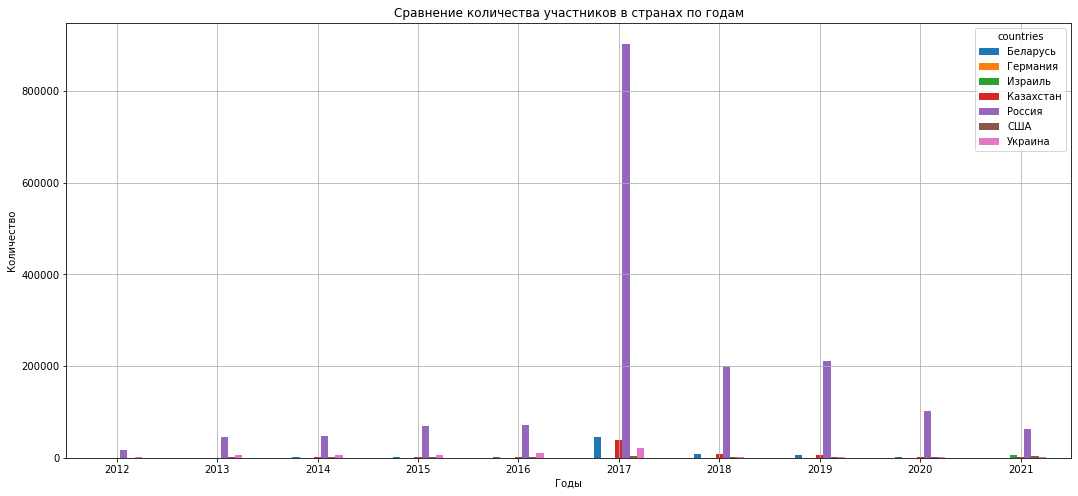

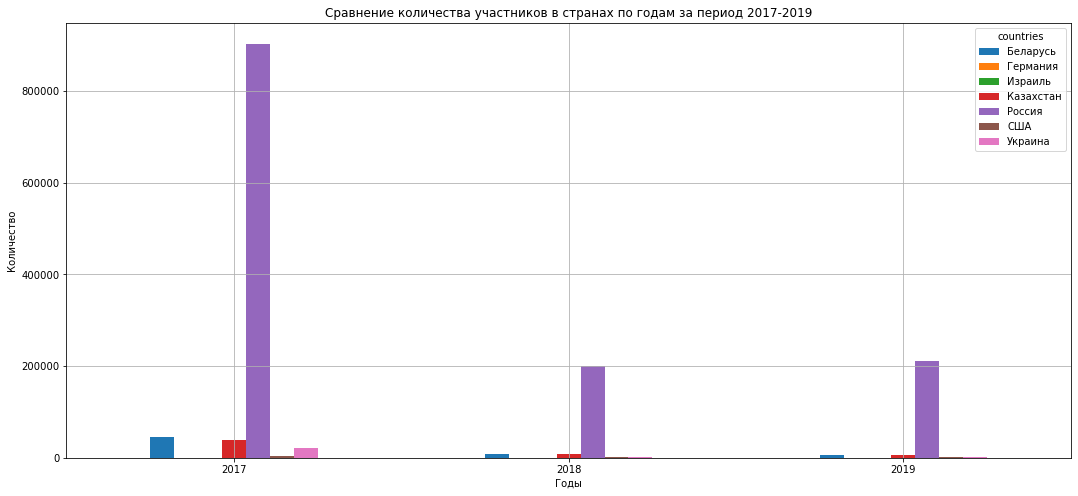

In [110]:
#Строим столбчатую диаграмму
yt =vk_con_top_plot.plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества участников в странах по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt =vk_con_top_plot.query('(year > 2016) & (year < 2020)').plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества участников в странах по годам за период 2017-2019")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

**Выводы**

Больших сюрпризов нет, подавляющую часть аудитории группы в ВК составляют жители России. До 2017 года процентов 10-15 участников приходили с Украины, однако после запрета доступа к соцсети украинский трафик упал до незначительных показателей. 

---------------------------------------------------

### Посмотрим на лайки и комментарии

In [111]:
vk_feed = vk_all.query('criterion == "feedback"').copy()
#    vk_feed.info()
#Отрежем колонки criterion и param_2
vk_feed = vk_feed.drop(['param_2','criterion'], axis=1)
#Переименуем колонку value в значение criterion
vk_feed = vk_feed.rename(columns={'value': 'feed_value', 'param_1': 'feedback'})
display(vk_feed)

date            feedback  feed_value  year  month  day
30    2011-12-31            Нравится           5  2011     12   31
31    2011-12-31  Рассказали друзьям           1  2011     12   31
32    2011-12-31         Комментарии           1  2011     12   31
71    2011-12-30         Комментарии           1  2011     12   30
127   2011-12-29         Комментарии           1  2011     12   29
...          ...                 ...         ...   ...    ...  ...
26059 2021-01-02  Рассказали друзьям          18  2021      1    2
26060 2021-01-02         Комментарии         127  2021      1    2
26132 2021-01-01            Нравится          63  2021      1    1
26133 2021-01-01  Рассказали друзьям           2  2021      1    1
26134 2021-01-01         Комментарии           1  2021      1    1

[11226 rows x 6 columns]

In [112]:
vk_feed_gr = vk_feed.groupby(['year','feedback']).agg({'feed_value':'sum'}).reset_index()
vk_feed_gr

year            feedback  feed_value
0   2011         Комментарии        1467
1   2011            Нравится        3102
2   2011  Рассказали друзьям        1609
3   2011          Упоминания           2
4   2012         Комментарии         685
5   2012            Нравится        1387
6   2012  Рассказали друзьям         538
7   2012          Упоминания           4
8   2013         Комментарии        2019
9   2013            Нравится        8935
10  2013  Рассказали друзьям        2904
11  2013          Упоминания           7
12  2014         Комментарии        2637
13  2014            Нравится       17924
14  2014  Рассказали друзьям        5338
15  2014          Упоминания          10
16  2015         Комментарии        4347
17  2015            Нравится       27599
18  2015  Рассказали друзьям        7297
19  2015          Упоминания           7
20  2016         Комментарии        2191
21  2016            Нравится       25703
22  2016  Рассказали друзьям        5919
23  2017         Комментарии       14022
24  2017            Нравится       70452
25  2017  Рассказали друзьям        9613
26  2017          Упоминания          10
27  2018         Комментарии       11933
28  2018            Нравится       64684
29  2018  Рассказали друзьям        6822
30  2018          Упоминания          15
31  2019         Комментарии       23166
32  2019            Нравится       90476
33  2019  Рассказали друзьям       10125
34  2019          Упоминания        6818
35  2020         Комментарии       20882
36  2020            Нравится       92326
37  2020  Рассказали друзьям        5744
38  2020          Упоминания         147
39  2021         Комментарии       13665
40  2021            Нравится       63213
41  2021  Рассказали друзьям        2217
42  2021          Упоминания         438

In [113]:
#Соберём таблицу 
vk_feed_plot = pd.pivot_table(vk_feed_gr, index='year', columns='feedback', values='feed_value')
vk_feed_plot

feedback  Комментарии  Нравится  Рассказали друзьям  Упоминания
year                                                           
2011           1467.0    3102.0              1609.0         2.0
2012            685.0    1387.0               538.0         4.0
2013           2019.0    8935.0              2904.0         7.0
2014           2637.0   17924.0              5338.0        10.0
2015           4347.0   27599.0              7297.0         7.0
2016           2191.0   25703.0              5919.0         NaN
2017          14022.0   70452.0              9613.0        10.0
2018          11933.0   64684.0              6822.0        15.0
2019          23166.0   90476.0             10125.0      6818.0
2020          20882.0   92326.0              5744.0       147.0
2021          13665.0   63213.0              2217.0       438.0

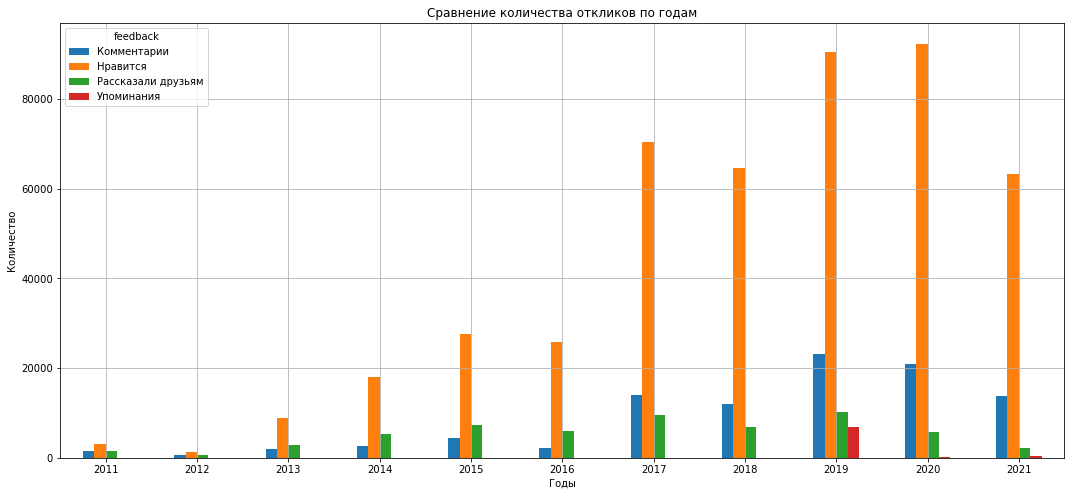

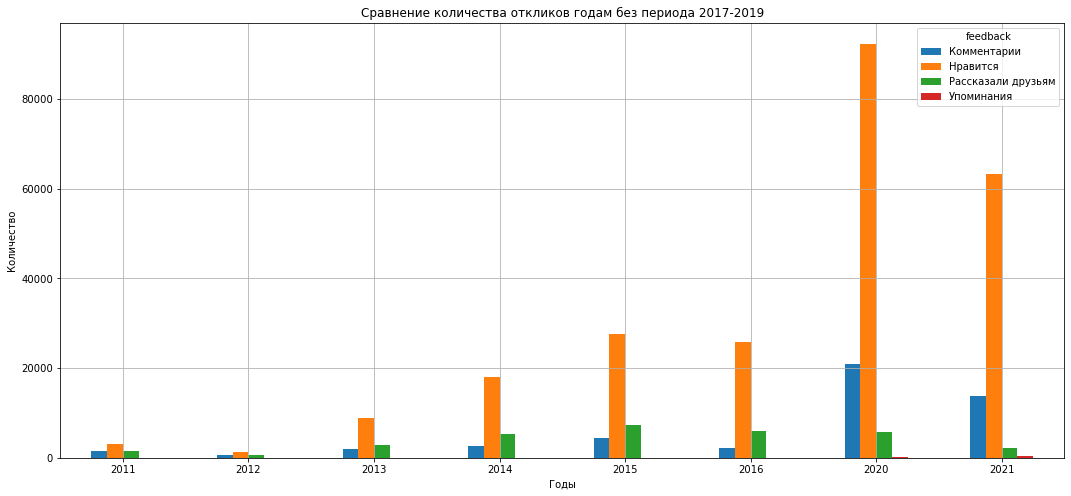

In [114]:
#Строим столбчатую диаграмму
yt =vk_feed_plot.plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества откликов по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt =vk_feed_plot.query('(year < 2017) or (year > 2019)').plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества откликов годам без периода 2017-2019")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

**Выводы**

Лайки - топливо соцсети. Что бы ни случилось, их всегда больше чем любых других реакций. За второе место борются комментарии и репосты. Однако в итоге комментарии побеждают, поскольку за них здесь денег не берут.

In [115]:
vk_act = vk_all.query('criterion == "activity"').copy()

#Отрежем колонки criterion и param_2
vk_act = vk_act.drop(['param_2','criterion'], axis=1)
#Переименуем колонку value в значение criterion
vk_act = vk_act.rename(columns={'value': 'act_value', 'param_1': 'activity'})
vk_act

date                   activity  act_value  year  month  day
125   2011-12-29  Комментарии к фотографиям          1  2011     12   29
126   2011-12-29  Комментарии к обсуждениям          2  2011     12   29
175   2011-12-28  Комментарии к обсуждениям          1  2011     12   28
439   2011-12-23  Комментарии к обсуждениям          6  2011     12   23
492   2011-12-22  Комментарии к обсуждениям          2  2011     12   22
...          ...                        ...        ...   ...    ...  ...
26056 2021-01-02      Добавления в закладки          5  2021      1    2
26057 2021-01-02      Голосования в опросах          2  2021      1    2
26129 2021-01-01  Комментарии к обсуждениям          3  2021      1    1
26130 2021-01-01      Добавления в закладки          1  2021      1    1
26131 2021-01-01      Голосования в опросах          1  2021      1    1

[7136 rows x 6 columns]

In [116]:
vk_act_gr = vk_act.groupby(['year','activity']).agg({'act_value':'sum'}).reset_index()
vk_act_gr

year                    activity  act_value
0   2011                 Видеозаписи          6
1   2011  Комментарии к видеозаписям         33
2   2011   Комментарии к обсуждениям        661
3   2011   Комментарии к фотографиям         66
4   2011          Сообщения на стене        318
..   ...                         ...        ...
58  2021  Комментарии к видеозаписям        178
59  2021   Комментарии к обсуждениям        800
60  2021   Комментарии к фотографиям       8360
61  2021             Темы обсуждений          1
62  2021                  Фотографии          6

[63 rows x 3 columns]

In [117]:
#Соберём таблицу на основе профилей из дат привлечения пользователей, каналов и стоимости привлечения
vk_act_plot = pd.pivot_table(vk_act_gr, index='year', columns='activity', values='act_value')
vk_act_plot

activity  Видеозаписи  Голосования в опросах  Добавления в закладки  \
year                                                                  
2011              6.0                    NaN                    NaN   
2012              1.0                    NaN                    NaN   
2013             10.0                    NaN                    NaN   
2014              1.0                    NaN                    NaN   
2015              NaN                    NaN                    NaN   
2016              NaN                    NaN                    NaN   
2017              NaN                    NaN                    NaN   
2018              NaN                 4970.0                  137.0   
2019              NaN                18290.0                 3196.0   
2020              NaN                17952.0                 1857.0   
2021              NaN                   66.0                  945.0   

activity  Комментарии к видеозаписям  Комментарии к обсуждениям  \
year                                                              
2011                            33.0                      661.0   
2012                             2.0                      482.0   
2013                            16.0                     1224.0   
2014                             4.0                     1591.0   
2015                             9.0                     1924.0   
2016                             1.0                     1412.0   
2017                            43.0                     2177.0   
2018                            17.0                     1080.0   
2019                           576.0                     1095.0   
2020                             4.0                      986.0   
2021                           178.0                      800.0   

activity  Комментарии к фотографиям  Сообщения на стене  Темы обсуждений  \
year                                                                       
2011                           66.0               318.0              9.0   
2012                          246.0                 2.0              2.0   
2013                          686.0                15.0              3.0   
2014                          793.0                 NaN             17.0   
2015                         1609.0                 NaN              1.0   
2016                         1220.0                 NaN              NaN   
2017                         3064.0                 NaN              2.0   
2018                         4179.0                 NaN              NaN   
2019                         7862.0                 NaN              1.0   
2020                        13108.0                 NaN              1.0   
2021                         8360.0                 NaN              1.0   

activity  Фотографии  
year                  
2011            22.0  
2012            65.0  
2013            14.0  
2014             NaN  
2015             NaN  
2016             NaN  
2017             NaN  
2018             NaN  
2019            79.0  
2020            12.0  
2021             6.0

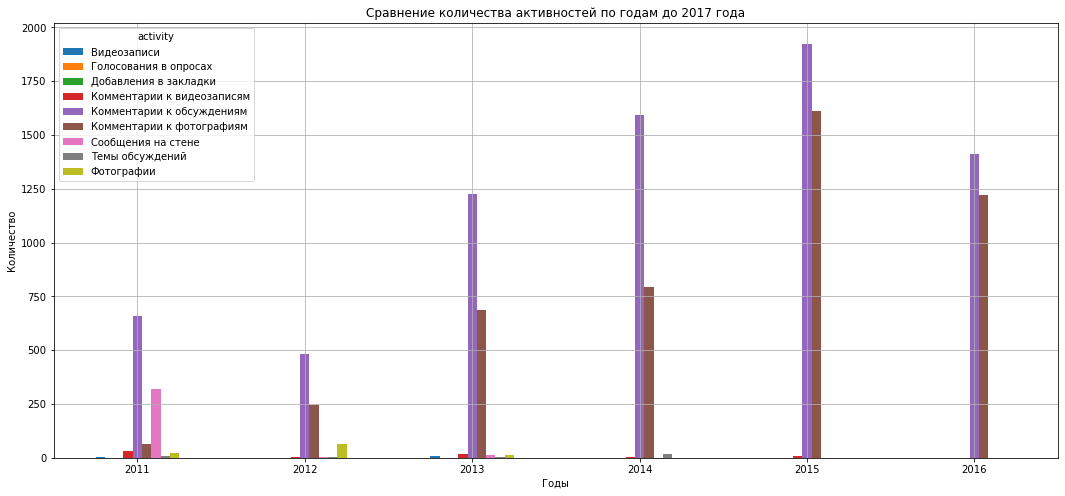

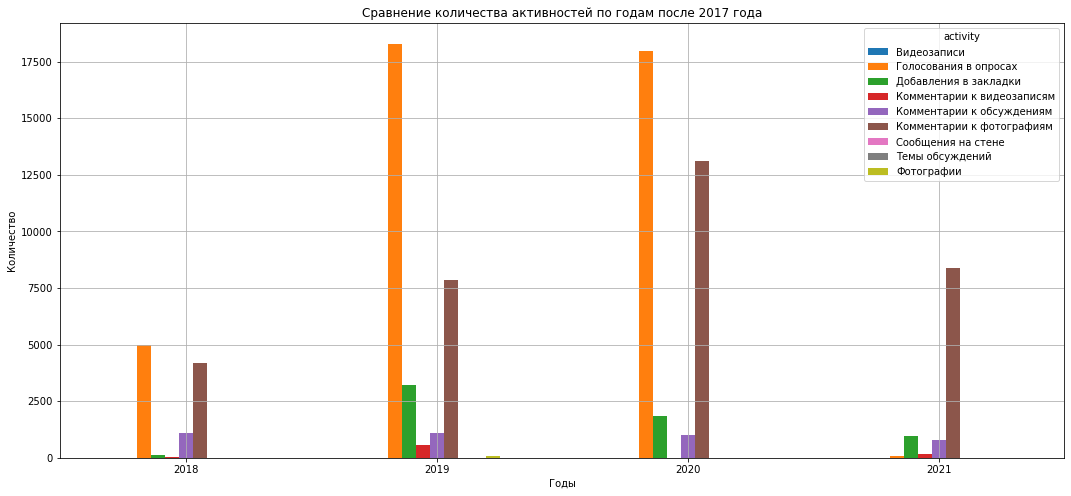

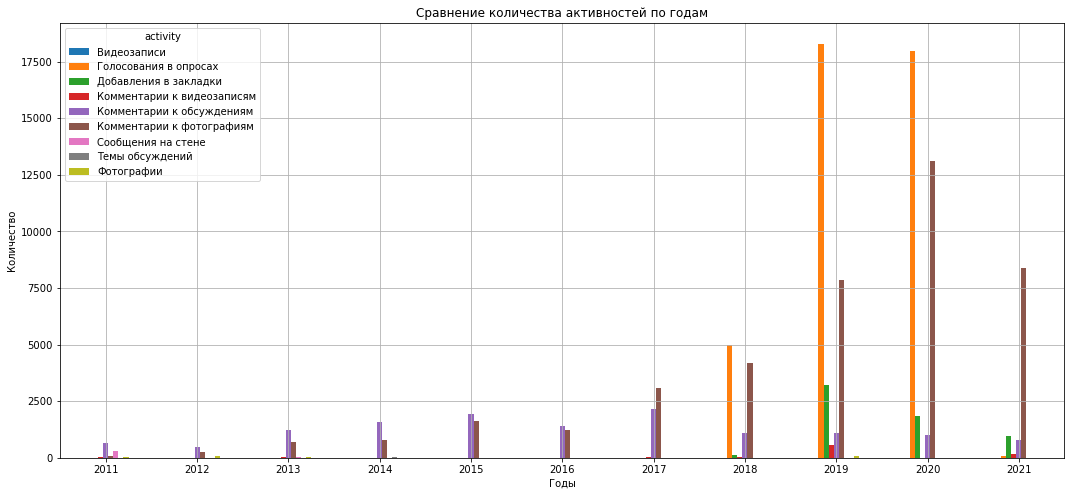

In [118]:
#Строим столбчатую диаграмму
yt =vk_act_plot.query('year < 2017').plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества активностей по годам до 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt =vk_act_plot.query('year > 2017').plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества активностей по годам после 2017 года")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

#Строим столбчатую диаграмму
yt =vk_act_plot.plot.bar(figsize=(18,8))
yt.set_title("Сравнение количества активностей по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=0)
plt.show()

**Выводы**

С годами виды активности в группе несколько менялась. С 2011 по 2017 годы были неизменно популярны "Комментарии к обсуждениям", хотя они и боролись с растущим количеством "Комментариев к фотографиям". Однако в 2018 году новая фича - "Голосования в опросах" затмила все основные активности. Так продолжалось с 2018 по 2020 годы. В 2021 году опросы резко пропали из популярных активностей, зато "Комментарии к фотографиям" стали основным видом активности. Также после 2018 года, а особенно в 2019-м "Добавление в закладки" вышло на третье, а затем на второе место по частоте использования.

---------------------------------------

In [119]:
vk_reach.head(2)

Дата                               Создатель записи  \
0  2021-12-27 17:57  Анастасия Сутягина (https://vk.com/id6385470)   
1  2021-12-26 19:06      Руслан Шекуров (https://vk.com/id1667407)   

                                   Запись  \
0        Друзья, будьте внимательны☝&#...   
1  Такие редкие и такие ценные истории...   

                                Ссылка  Охват подписчиков  Виральный охват  \
0  https://vk.com/wall-21179173_103092                549                3   
1  https://vk.com/wall-21179173_103058              17506             3598   

   Рекламный охват  Полный охват  Нравится  Поделились  Комментариев  \
0                0           549         8           0             1   
1                0         21104       672          25            29   

   Скрыли запись  Жалобы  Скрыли все записи  Переходы в сообщество  \
0              0       0                  0                      2   
1              6       0                  1                     63   

   Подписались на страницу  Переходы по ссылке  
0                        0                   0  
1                        1                   1

In [120]:
vk_reach.columns

Index(['Дата', 'Создатель записи', 'Запись', 'Ссылка', 'Охват подписчиков',
       'Виральный охват', 'Рекламный охват', 'Полный охват', 'Нравится',
       'Поделились', 'Комментариев', 'Скрыли запись', 'Жалобы',
       'Скрыли все записи', 'Переходы в сообщество', 'Подписались на страницу',
       'Переходы по ссылке'],
      dtype='object')

In [121]:
#Зададим формат даты
time_format = '%Y.%m.%d %H:%M'

#Переведём дату в нужный формат
vk_reach['Дата'] = pd.to_datetime(vk_reach['Дата'], format = time_format)
    

#Создадим колонки дат для соотвествующих группировок
vk_reach['year'] = vk_reach['Дата'].dt.year
vk_reach['month'] = vk_reach['Дата'].dt.month
vk_reach['day'] = vk_reach['Дата'].dt.day
vk_reach['date'] = vk_reach['Дата'].dt.date
vk_reach

Дата                               Создатель записи  \
0   2021-12-27 17:57:00  Анастасия Сутягина (https://vk.com/id6385470)   
1   2021-12-26 19:06:00      Руслан Шекуров (https://vk.com/id1667407)   
2   2021-12-24 19:49:00      Руслан Шекуров (https://vk.com/id1667407)   
3   2021-12-23 18:02:00  Анастасия Сутягина (https://vk.com/id6385470)   
4   2021-12-21 20:17:00  Анастасия Сутягина (https://vk.com/id6385470)   
..                  ...                                            ...   
995 2019-03-01 17:38:00  Анастасия Сутягина (https://vk.com/id6385470)   
996 2019-03-01 10:44:00  Анастасия Сутягина (https://vk.com/id6385470)   
997 2019-02-28 17:35:00  Анастасия Сутягина (https://vk.com/id6385470)   
998 2019-02-28 12:05:00        Нина Гусева (https://vk.com/id40434992)   
999 2019-02-27 18:35:00  Анастасия Сутягина (https://vk.com/id6385470)   

                                     Запись  \
0          Друзья, будьте внимательны☝&#...   
1    Такие редкие и такие ценные истории...   
2            Новый год уже близко😍 Давай...   
3        Здравствуйте! Хочется поделитьс...   
4    Друзья, вашей помощи сейчас очень ж...   
..                                      ...   
995  Миллионы людей по всему миру благод...   
996      Зима кончилась, друзья!<br><br>...   
997  Периодически мы отвечаем на вопросы...   
998          🔥 Участвуй в конкурсе с при...   
999  Вы часто спрашивали нас, есть ли ка...   

                                  Ссылка  Охват подписчиков  Виральный охват  \
0    https://vk.com/wall-21179173_103092                549                3   
1    https://vk.com/wall-21179173_103058              17506             3598   
2    https://vk.com/wall-21179173_102976               5005              216   
3    https://vk.com/wall-21179173_102916               9768             1017   
4    https://vk.com/wall-21179173_102863               6725             1067   
..                                   ...                ...              ...   
995   https://vk.com/wall-21179173_49080               6658             1228   
996   https://vk.com/wall-21179173_49035              11674             4091   
997   https://vk.com/wall-21179173_48955              14430             4882   
998   https://vk.com/wall-21179173_48895               4960              872   
999   https://vk.com/wall-21179173_48718              13384             2317   

     Рекламный охват  Полный охват  Нравится  Поделились  Комментариев  \
0                  0           549         8           0             1   
1                  0         21104       672          25            29   
2                  0          5221        57           0            48   
3                  0         10444       349           5            84   
4                  1          7793       118          31             7   
..               ...           ...       ...         ...           ...   
995                0          7873       109           9             3   
996                0         15765       102           6            12   
997                0         19312       193          25             9   
998                6          5838        65           7            33   
999                1         15702        92          10            30   

     Скрыли запись  Жалобы  Скрыли все записи  Переходы в сообщество  \
0                0       0                  0                      2   
1                6       0                  1                     63   
2                4       0                  0                      7   
3                3       0                  0                     25   
4                2       0                  0                     10   
..             ...     ...                ...                    ...   
995              2       0                  0                      8   
996              6       0                  2                     21   
997              4       0                  0                     4

In [122]:
vk_reach_viral_add = vk_reach.groupby(['year','month']).agg({'Охват подписчиков':'sum',
                                                   'Виральный охват':'sum', 
                                                   'Рекламный охват':'sum'})
vk_reach_viral_add

Охват подписчиков  Виральный охват  Рекламный охват
year month                                                     
2019 2                  32774             8071                7
     3                 626350           227789            12590
     4                 734271           267488            40332
     5                 508401           265093            29621
     6                 514720           244274             8566
     7                 461007           144228            27570
     8                 384171           146724            10893
     9                 348237           110754              545
     10                306696           132115              175
     11                353231           107528             3507
     12                303845            88667              225
2020 1                 406829           140197            12234
     2                 327099           117406            17882
     3                 339003           207005            91370
     4                 335995           224277           109026
     5                 323977            83880            55788
     6                 427791           116554             2928
     7                 445415            96466              201
     8                 525736           106907               86
     9                 477963            76941            33506
     10                558981            90249               95
     11                417543            95841            70839
     12                476100            77129             5517
2021 1                 444822           104384            29943
     2                 335210            51340               57
     3                 288038            49557               21
     4                 321067            52073             7134
     5                 368951            65795              118
     6                 326498            68355             1525
     7                 287132            51807              553
     8                 268934            50358               36
     9                 264297            59068             4467
     10                262064            51956              235
     11                207308            50096             1307
     12                152535            32233            18109

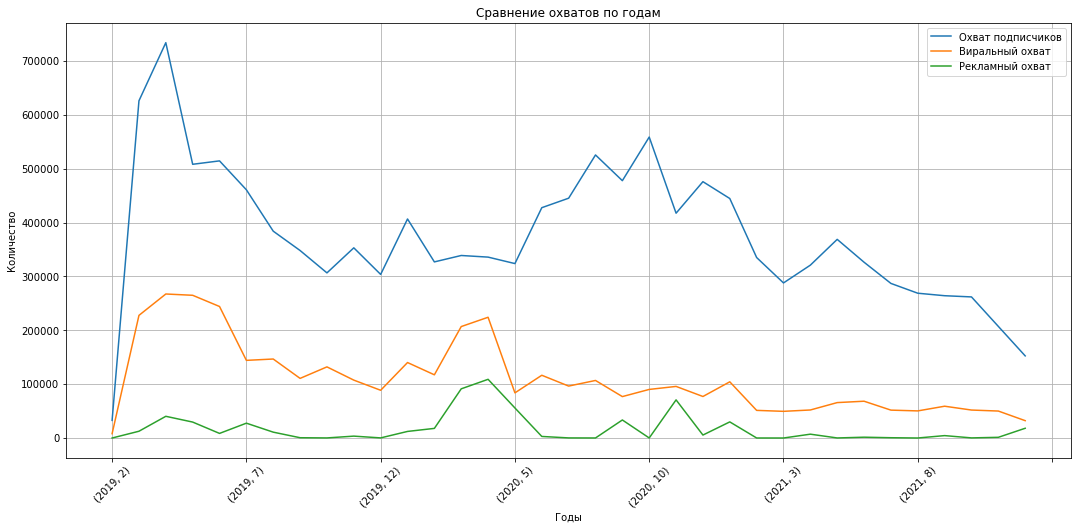

In [123]:
#Строим столбчатую диаграмму
yt =vk_reach_viral_add.plot(figsize=(18,8))
yt.set_title("Сравнение охватов по годам")
yt.set_xlabel('Годы')
yt.set_ylabel('Количество')
yt.axes.grid()
plt.xticks(rotation=45)
plt.show()

**Выводы**

Данные имеются только за 2019-2021 годы, однако можно проследить, что в 2019 году посты достаточно хорошо завирусились, подняв охваты при небольшом вложении в рекламу в ВК.Затем на графике виден результат рекламной кампании в первой половине 2020 года. Далее виральный и рекламный охваты не радуют пиками, зато охват подписчиков показывает заметный рост. В 2021 году происходит затяжной спад, охваты падают, что коррелирует с беспрецедентным оттоком участников группы.